In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [ ]:
prod_data = pd.read_csv("/content/spe_africa_dseats_datathon_2025_wells_dataset.csv")

In [ ]:
reservoir_data = pd.read_csv("/content/reservoir_info.csv")

In [ ]:
sample_submission = pd.read_csv("/content/Innovisors_DSEATS_Africa_2025_Classification.csv")

In [ ]:
prod_data.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0  15-Feb-14   Well_#1            0.0                             4,050   
1  16-Feb-14   Well_#1            0.0                             3,961   
2  17-Feb-14   Well_#1            0.0                             3,961   
3  18-Feb-14   Well_#1            0.0                             3,964   
4  19-Feb-14   Well_#1            0.0                             3,965   

   DOWNHOLE_TEMPERATURE (deg F) ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                   0         1.17951   
1                       189.945                   0         2.99440   
2                       190.004                   0         1.90349   
3                       190.020                   0         0.00000   
4                       190.107                   0        30.20760   

  WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.46                         50.864   
1                  328.601                         47.668   
2                  387.218                         48.962   
3                   308.98                         46.636   
4                  196.057                         47.297   

  CUMULATIVE_OIL_PROD (STB) CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                         0                                    0   
1                         0                                    0   
2                         0                                    0   
3                         0                                    0   
4                         0                                    0   

  CUMULATIVE_TOTAL_GAS_PROD (MSCF) CUMULATIVE_WATER_PROD (BBL)  
0                                0                           0  
1                                0                           0  
2                                0                           0  
3                                0                           0  
4                                0                           0

In [ ]:
reservoir_data.head()

Reservoir Name Initial Reservoir Pressure (PSI) Bubble Point Pressure (PSI)  \
0           ACHI                            3,500                       3,300   
1           KEMA                            4,200                       4,000   
2           MAKO                            3,500                       3,500   
3           DEPU                            2,800                       2,800   
4           JANI                            4,500                       4,300   

  Current Average Reservoir Pressure (PSI) Solution Gas-Oil-Ratio (SCF/BBL)  \
0                                    2,700                              800   
1                                    3,900                              600   
2                                    3,000                              500   
3                                    2,400                            1,200   
4                                    4,200                            1,000   

   Formation Volume Factor (RB/STB)  
0                              1.20  
1                              1.45  
2                              1.15  
3                              1.37  
4                              1.30

In [ ]:
prod_data.shape

(7955, 13)

## Data Preprocessing

In [ ]:
prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PROD_DATE                             7955 non-null   object 
 1   WELL_NAME                             7955 non-null   object 
 2   ON_STREAM_HRS                         7955 non-null   float64
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   object 
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 5   ANNULUS_PRESS (PSI)                   7955 non-null   object 
 6   CHOKE_SIZE (%)                        7955 non-null   float64
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   object 
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   object 
 10  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   object 
 11  CUMULATIVE_TOTAL_

**Noticeably, the data are not in the right dtypes.**

In [ ]:
# --- 1. Convert PROD_DATE to datetime ---------------------------------------
prod_data['PROD_DATE'] = pd.to_datetime(
    prod_data['PROD_DATE'].str.strip(),
    format='%d-%b-%y',
    errors='coerce'
)

# --- 2. Work out which columns should be numeric ----------------------------
non_numeric = {'PROD_DATE', 'WELL_NAME'}          # keep these as-is
numeric_cols = [c for c in prod_data.columns if c not in non_numeric]

# --- 3. Strip commas and cast to float --------------------------------------
for col in numeric_cols:
    # If the column is already numeric (float64/int64), skip; otherwise clean
    if not pd.api.types.is_numeric_dtype(prod_data[col]):
        prod_data[col] = (
            prod_data[col]
              .astype(str)
              .str.replace(',', '', regex=False)
              .str.strip()
              .replace({'': np.nan})
              .astype(float)
        )


print(prod_data.dtypes)

PROD_DATE                               datetime64[ns]
WELL_NAME                                       object
ON_STREAM_HRS                                  float64
BOTTOMHOLE_FLOWING_PRESSURE (PSI)              float64
DOWNHOLE_TEMPERATURE (deg F)                   float64
ANNULUS_PRESS (PSI)                            float64
CHOKE_SIZE (%)                                 float64
WELL_HEAD_PRESSURE (PSI)                       float64
WELL_HEAD_TEMPERATURE (deg F)                  float64
CUMULATIVE_OIL_PROD (STB)                      float64
CUMULATIVE_FORMATION_GAS_PROD (MSCF)           float64
CUMULATIVE_TOTAL_GAS_PROD (MSCF)               float64
CUMULATIVE_WATER_PROD (BBL)                    float64
dtype: object


In [ ]:
prod_data.head()

NameError: name 'prod_data' is not defined

In [ ]:
# checking for missing dataset

prod_data.isnull().any().any()

False

In [ ]:
sample_submission.head()

Well Reservoir Name Reservoir Type Well Type Production Type  \
0     1           KEMA      Saturated        GL        Unsteady   
1     2            NaN            NaN       NaN             NaN   
2     3            NaN            NaN       NaN             NaN   
3     4            NaN            NaN       NaN             NaN   
4     5            NaN            NaN       NaN             NaN   

  Formation GOR Trend Watercut Trend Oil Productivity Index  
0             aSolGOR           Flat                   Decr  
1                 NaN            NaN                    NaN  
2                 NaN            NaN                    NaN  
3                 NaN            NaN                    NaN  
4                 NaN            NaN                    NaN

## Creating daily production columns from cumulatives :


In [ ]:

prod_map = {
    "CUMULATIVE_OIL_PROD (STB)":           "OIL_PROD (STB)",
    "CUMULATIVE_FORMATION_GAS_PROD (MSCF)": "FORM_GAS_PROD (MSCF)",
    "CUMULATIVE_TOTAL_GAS_PROD (MSCF)":     "TOTAL_GAS_PROD (MSCF)",
    "CUMULATIVE_WATER_PROD (BBL)":          "WATER_PROD (BBL)"
}


prod_data = prod_data.sort_values(["WELL_NAME", "PROD_DATE"]).copy()


for cum_col, daily_col in prod_map.items():
    prod_data[daily_col] = (
        prod_data.groupby("WELL_NAME")[cum_col]
            .diff()
            .fillna(prod_data[cum_col])
            .clip(lower=0)
    )

In [ ]:

prod_data[
    ["WELL_NAME", "PROD_DATE"] +
    list(prod_map.keys()) +
    list(prod_map.values())
    ].head(10)

WELL_NAME  PROD_DATE  CUMULATIVE_OIL_PROD (STB)  \
0   Well_#1 2014-02-15                        0.0   
1   Well_#1 2014-02-16                        0.0   
2   Well_#1 2014-02-17                        0.0   
3   Well_#1 2014-02-18                        0.0   
4   Well_#1 2014-02-19                        0.0   
5   Well_#1 2014-02-20                        0.0   
6   Well_#1 2014-02-21                        0.0   
7   Well_#1 2014-02-22                        0.0   
8   Well_#1 2014-02-23                        0.0   
9   Well_#1 2014-02-24                        0.0   

   CUMULATIVE_FORMATION_GAS_PROD (MSCF)  CUMULATIVE_TOTAL_GAS_PROD (MSCF)  \
0                                   0.0                               0.0   
1                                   0.0                               0.0   
2                                   0.0                               0.0   
3                                   0.0                               0.0   
4                                   0.0                               0.0   
5                                   0.0                               0.0   
6                                   0.0                               0.0   
7                                   0.0                               0.0   
8                                   0.0                               0.0   
9                                   0.0                               0.0   

   CUMULATIVE_WATER_PROD (BBL)  OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  \
0                          0.0             0.0                   0.0   
1                          0.0             0.0                   0.0   
2                          0.0             0.0                   0.0   
3                          0.0             0.0                   0.0   
4                          0.0             0.0                   0.0   
5                          0.0             0.0                   0.0   
6                          0.0             0.0                   0.0   
7                          0.0             0.0                   0.0   
8                          0.0             0.0                   0.0   
9                          0.0             0.0                   0.0   

   TOTAL_GAS_PROD (MSCF)  WATER_PROD (BBL)  
0                    0.0               0.0  
1                    0.0               0.0  
2                    0.0               0.0  
3                    0.0               0.0  
4                    0.0               0.0  
5                    0.0               0.0  
6                    0.0               0.0  
7                    0.0               0.0  
8                    0.0               0.0  
9                    0.0               0.0

## Production Plot (Oil, Gas, and Water) Per Well

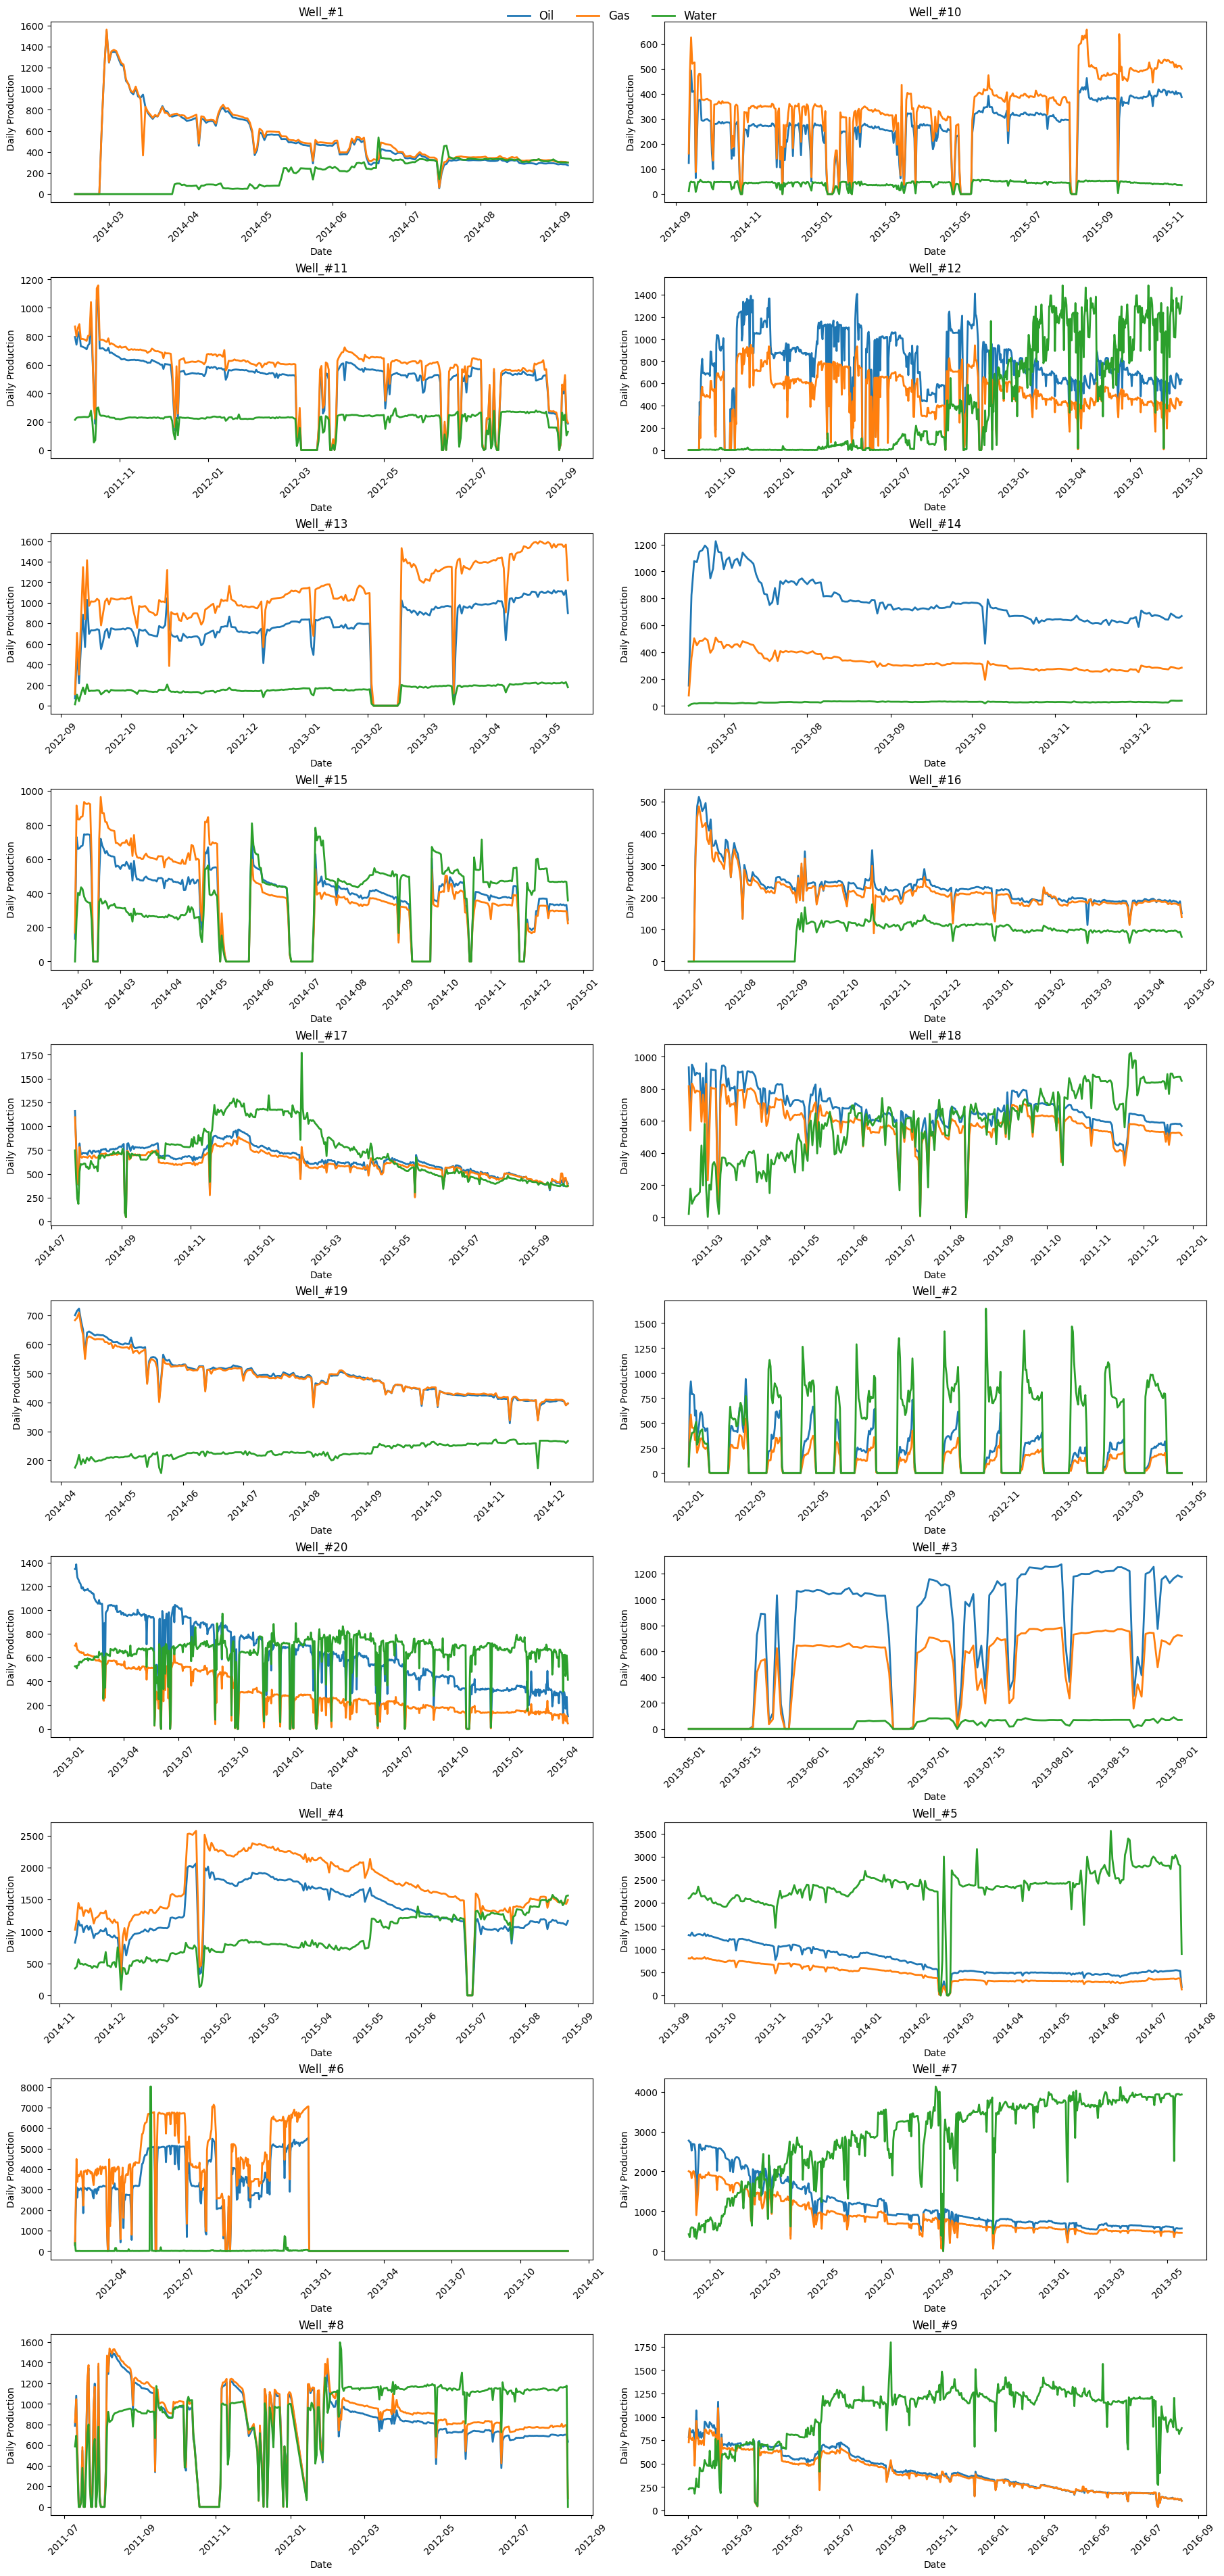

In [ ]:
oil_col  = "OIL_PROD (STB)"
gas_col  = "FORM_GAS_PROD (MSCF)"
water_col =  "WATER_PROD (BBL)"


well_list = sorted(prod_data["WELL_NAME"].unique())


fig, axes = plt.subplots(
    nrows=10,
    ncols=2,
    figsize=(18, 38),
    sharex=False,
    sharey=False,
    constrained_layout=True
)

axes = axes.flatten()


for ax, well in zip(axes, well_list):
    d = prod_data[prod_data["WELL_NAME"] == well].sort_values("PROD_DATE")

    ax.plot(d["PROD_DATE"], d[oil_col],   label="Oil",   linewidth=2)
    ax.plot(d["PROD_DATE"], d[gas_col],   label="Gas",   linewidth=2)
    ax.plot(d["PROD_DATE"], d[water_col], label="Water", linewidth=2)

    ax.set_title(well)
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Production")
    ax.tick_params(axis='x', rotation=45)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize="large"
)

plt.show()

## Observations from the production plots per well

These plots shows the daily production trends across all 20 wells. From these plots, the following observations trends are seen:


*   Wells 2, 5, 7, and 9 have very high water production which might indicate the presence of water drive or water breakthrough.
*   Wells 1, 14 and 19 shows steady decline in the oil and gas production
*   Wells 2 and 13 shows high gas production
*   Wells 2, 11, 12, 15, 18 and 20 shows sharp fluctuations and intermittent behaviour probably as a result of frequent well interventions or operational shut ins.





## Pressue_Production Time Series Plot Per Well

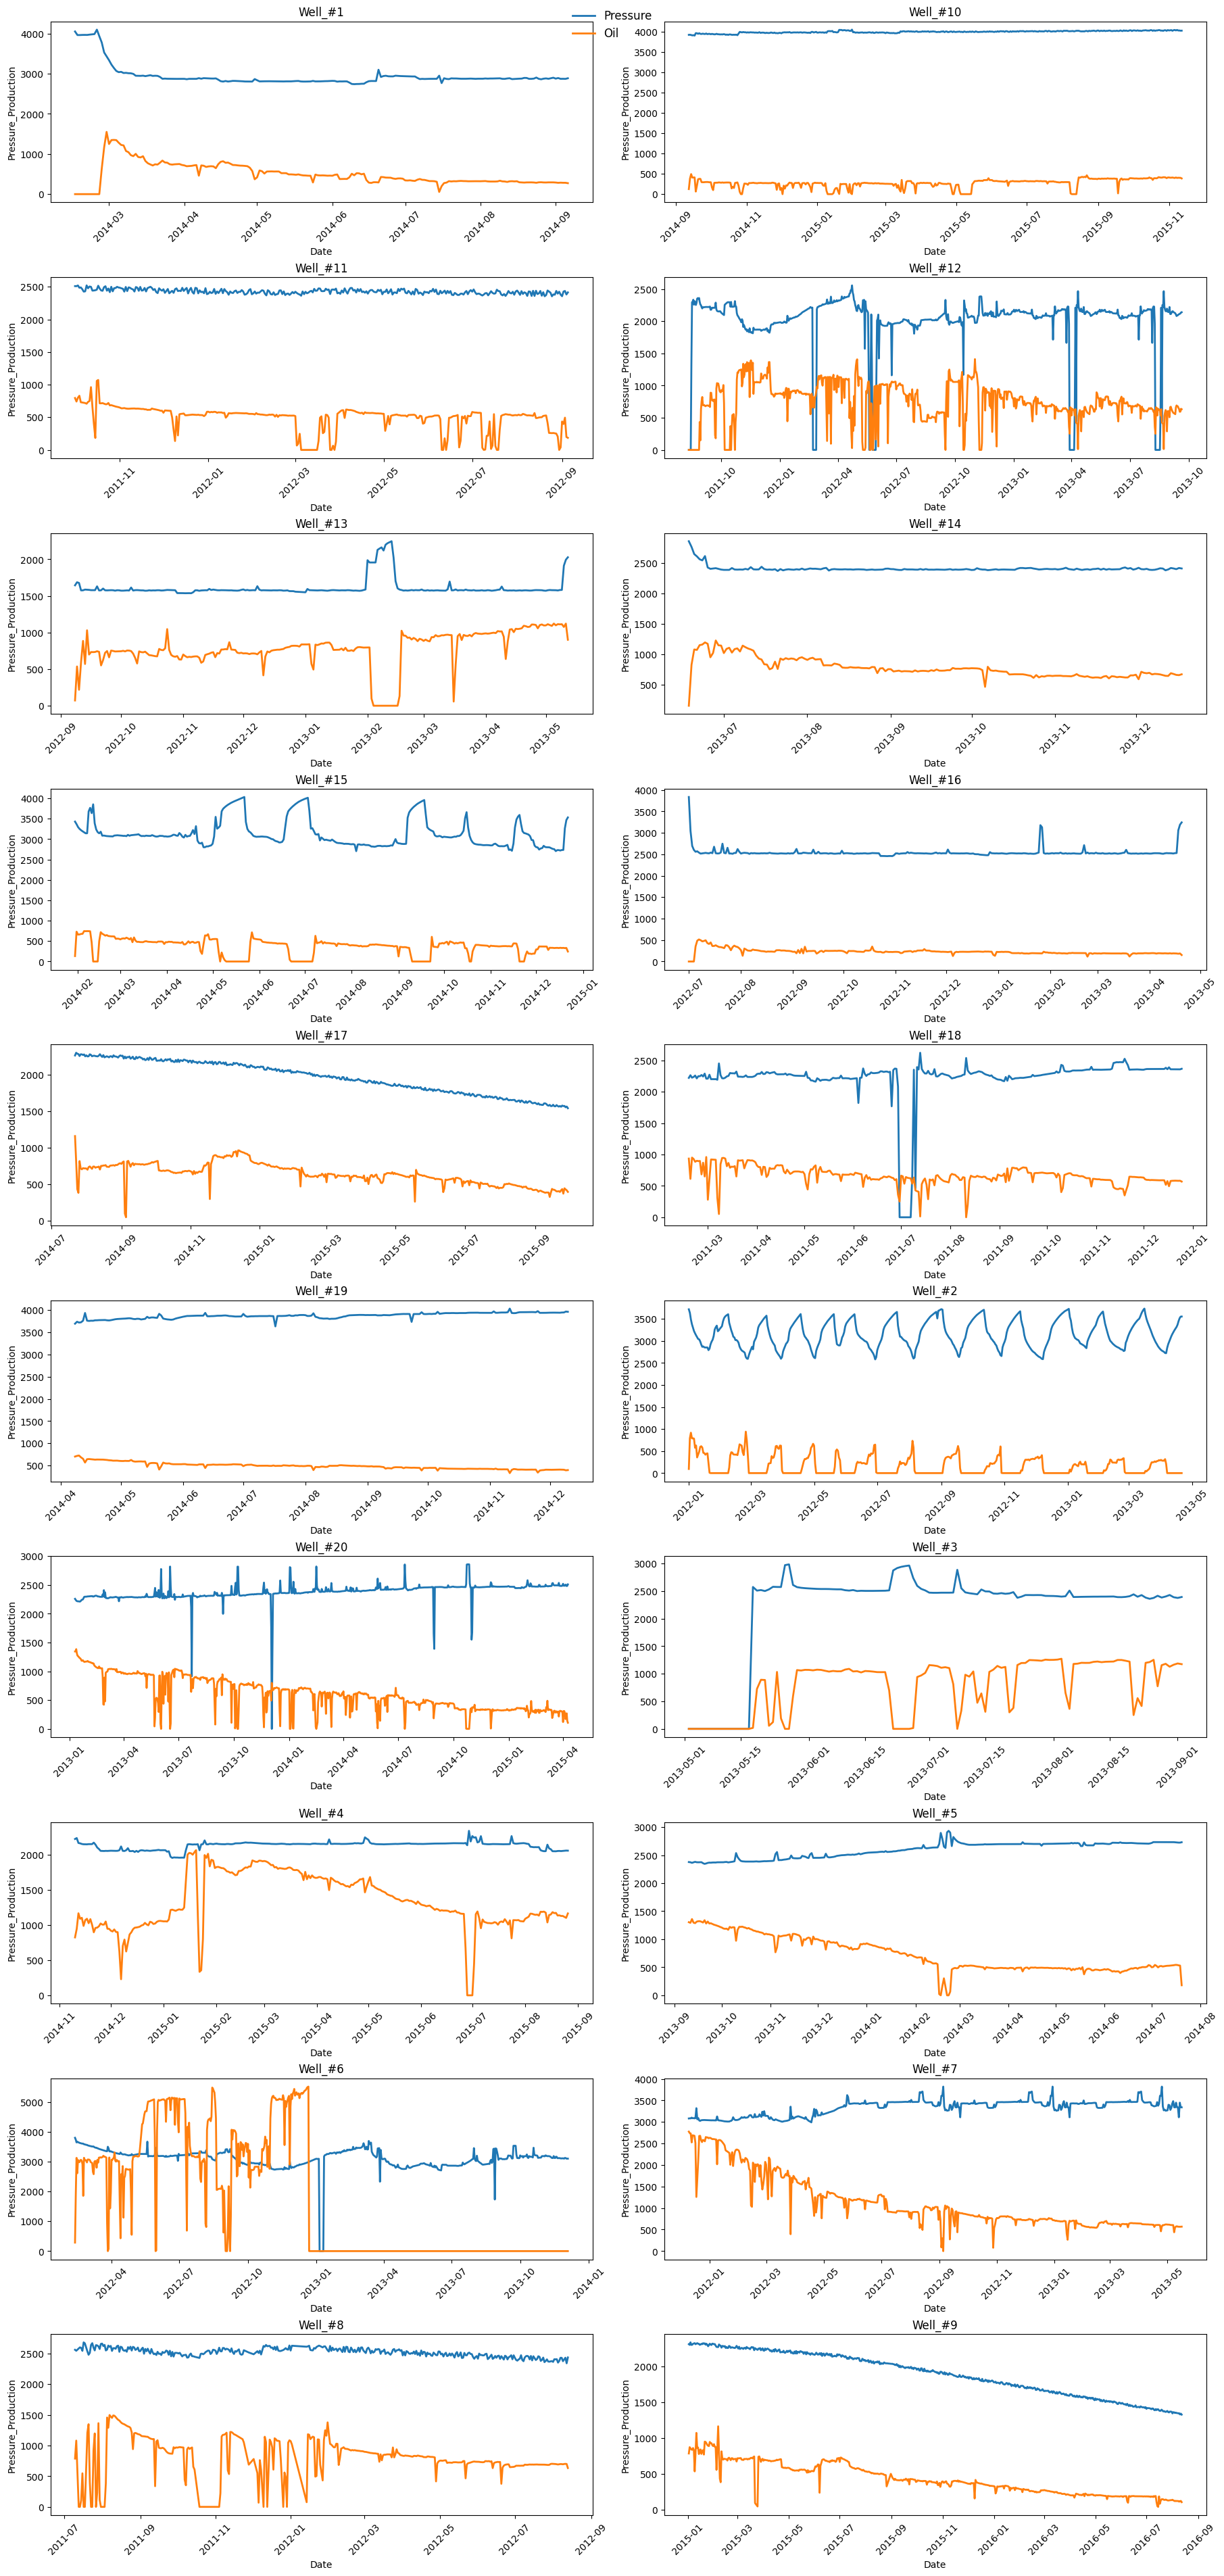

In [ ]:

pressure_col  = "BOTTOMHOLE_FLOWING_PRESSURE (PSI)"
oil_col  = "OIL_PROD (STB)"


well_list = sorted(prod_data["WELL_NAME"].unique())


fig, axes = plt.subplots(
    nrows=10,
    ncols=2,
    figsize=(18, 38),
    sharex=False,
    sharey=False,
    constrained_layout=True
)

axes = axes.flatten()

for ax, well in zip(axes, well_list):
    d = prod_data[prod_data["WELL_NAME"] == well].sort_values("PROD_DATE")

    ax.plot(d["PROD_DATE"], d[pressure_col],   label="Pressure",   linewidth=2)
    ax.plot(d["PROD_DATE"], d[oil_col],   label="Oil",   linewidth=2)


    ax.set_title(well)
    ax.set_xlabel("Date")
    ax.set_ylabel("Pressure_Production")
    ax.tick_params(axis='x', rotation=45)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=1,
    frameon=False,
    fontsize="large"
)

plt.show()

## Observations of Pressue_Production Time Series Plot Per Well

These plots shows the pressure production trends across all 20 wells. From these plots, the following observations trends are seen:


*   Wells like 1, 9, 14, and 17 shows steady reservoir decline behavior.
*   Wells 10, and 11 shows steady pressure levels but fluctuating oil production, which might indicate the use of artificial lift methods or pressure support from injection.




In [ ]:
# --- Static reservoir properties --------------------------------
reservoir_data = reservoir_data.rename(columns={
    "Reservoir Name": "RESERVOIR",
    "Initial Reservoir Pressure (PSI)": "P_INIT",
    "Bubble Point Pressure (PSI)": "P_BUBBLE",
    "Current Average Reservoir Pressure (PSI)": "P_AVG",
    "Solution Gas-Oil-Ratio (SCF/BBL)": "SOL_GOR",
    "Formation Volume Factor (RB/STB)": "BO",
})

reservoir_data.head()

RESERVOIR P_INIT P_BUBBLE  P_AVG SOL_GOR    BO
0      ACHI  3,500    3,300  2,700     800  1.20
1      KEMA  4,200    4,000  3,900     600  1.45
2      MAKO  3,500    3,500  3,000     500  1.15
3      DEPU  2,800    2,800  2,400   1,200  1.37
4      JANI  4,500    4,300  4,200   1,000  1.30

In [ ]:
reservoir_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RESERVOIR  5 non-null      object 
 1   P_INIT     5 non-null      object 
 2   P_BUBBLE   5 non-null      object 
 3   P_AVG      5 non-null      object 
 4   SOL_GOR    5 non-null      object 
 5   BO         5 non-null      float64
dtypes: float64(1), object(5)
memory usage: 372.0+ bytes


In [ ]:
non_numeric = {'RESERVOIR'}          # keep this as-is
numeric_cols = [c for c in reservoir_data.columns if c not in non_numeric]

for col in numeric_cols:
    # If the column is already numeric (float64/int64), skip; otherwise clean
    if not pd.api.types.is_numeric_dtype(reservoir_data[col]):
        reservoir_data[col] = (
            reservoir_data[col]
              .astype(str)
              .str.replace(',', '', regex=False)
              .str.strip()
              .replace({'': np.nan})
              .astype(float)
        )

print(reservoir_data.dtypes)

RESERVOIR     object
P_INIT       float64
P_BUBBLE     float64
P_AVG        float64
SOL_GOR      float64
BO           float64
dtype: object


# Task 1 - Reservoir Classification  
1. We find the maximum bottomhole flowing pressure, BHFP_MAX for each well.
2. We match each well to a reservoir for which the current average reservoir pressure must be ≥ BHFP_MAX, and within 200 psi

In [ ]:
#  for every well, find the maximum BHFP
max_bhfp = (
    prod_data.groupby("WELL_NAME")["BOTTOMHOLE_FLOWING_PRESSURE (PSI)"]
        .max()
        .rename("BHFP_MAX")
)


In [ ]:
reserv_class = max_bhfp.to_frame().reset_index()
display(reserv_class)

WELL_NAME  BHFP_MAX
0    Well_#1    4096.0
1   Well_#10    4051.0
2   Well_#11    2521.0
3   Well_#12    2557.0
4   Well_#13    2246.0
5   Well_#14    2857.0
6   Well_#15    4032.0
7   Well_#16    3836.0
8   Well_#17    2304.0
9   Well_#18    2621.0
10  Well_#19    4036.0
11   Well_#2    3735.0
12  Well_#20    2858.0
13   Well_#3    2985.0
14   Well_#4    2340.0
15   Well_#5    2933.0
16   Well_#6    3797.0
17   Well_#7    3821.0
18   Well_#8    2681.0
19   Well_#9    2333.0

In [ ]:
reservoir_data.head()

RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR    BO
0      ACHI  3500.0    3300.0  2700.0    800.0  1.20
1      KEMA  4200.0    4000.0  3900.0    600.0  1.45
2      MAKO  3500.0    3500.0  3000.0    500.0  1.15
3      DEPU  2800.0    2800.0  2400.0   1200.0  1.37
4      JANI  4500.0    4300.0  4200.0   1000.0  1.30

In [ ]:

def pick_reservoir(bhfp_max, resv_df, tol=200):
    """
    Reservoir assignment:
    1. Match to P_AVG (must be ≥ BHFP_MAX, and within 200 psi)
    """
    if np.isnan(bhfp_max):
        return np.nan

    #Try P_AVG ----------------------------------------
    diff_init = resv_df["P_AVG"] - bhfp_max
    valid_init = (diff_init >= 0) & (diff_init <= tol)

    if valid_init.any():
        best_idx = diff_init[valid_init].idxmin()
        return resv_df.loc[best_idx, "RESERVOIR"]


    # --- No match ---------------------------------------------------
    return np.nan



reserv_class["RESERVOIR"] = reserv_class["BHFP_MAX"].apply(
    lambda p: pick_reservoir(p, reservoir_data, tol=200)
)



In [ ]:
display(reserv_class)

WELL_NAME  BHFP_MAX RESERVOIR
0    Well_#1    4096.0      JANI
1   Well_#10    4051.0      JANI
2   Well_#11    2521.0      ACHI
3   Well_#12    2557.0      ACHI
4   Well_#13    2246.0      DEPU
5   Well_#14    2857.0      MAKO
6   Well_#15    4032.0      JANI
7   Well_#16    3836.0      KEMA
8   Well_#17    2304.0      DEPU
9   Well_#18    2621.0      ACHI
10  Well_#19    4036.0      JANI
11   Well_#2    3735.0      KEMA
12  Well_#20    2858.0      MAKO
13   Well_#3    2985.0      MAKO
14   Well_#4    2340.0      DEPU
15   Well_#5    2933.0      MAKO
16   Well_#6    3797.0      KEMA
17   Well_#7    3821.0      KEMA
18   Well_#8    2681.0      ACHI
19   Well_#9    2333.0      DEPU

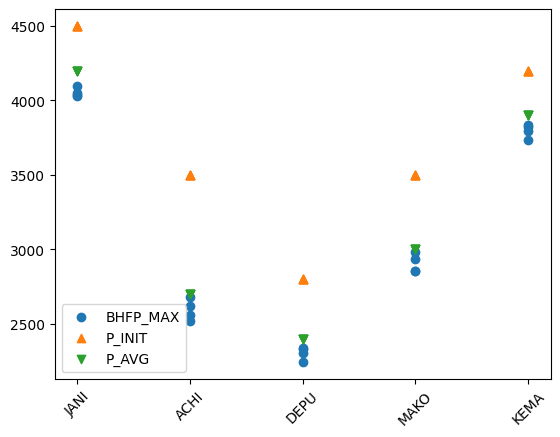

In [ ]:
import matplotlib.pyplot as plt

tmp = reserv_class.merge(reservoir_data, on="RESERVOIR", how="left")
plt.scatter(tmp["RESERVOIR"], tmp["BHFP_MAX"], label="BHFP_MAX")
plt.scatter(tmp["RESERVOIR"], tmp["P_INIT"],   marker='^', label="P_INIT")
plt.scatter(tmp["RESERVOIR"], tmp["P_AVG"],    marker='v', label="P_AVG")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Task 2 - Reservoir Type  
**To determine for each reservoir whether saturated or undersaturated using the initial condition**   
1. If P_INIT > P_BUBBLE, the reservoir is undersaturated at initial condition.
2. Else, it is saturated.

In [ ]:
reservoir_data.head()

RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR    BO
0      ACHI  3500.0    3300.0  2700.0    800.0  1.20
1      KEMA  4200.0    4000.0  3900.0    600.0  1.45
2      MAKO  3500.0    3500.0  3000.0    500.0  1.15
3      DEPU  2800.0    2800.0  2400.0   1200.0  1.37
4      JANI  4500.0    4300.0  4200.0   1000.0  1.30

In [ ]:
reserv = reservoir_data.copy()

# Assign reservoir type using the calculation
reserv["Reservoir Type"] = np.where(
    reserv["P_INIT"] > reserv["P_BUBBLE"],
    "Undersaturated",
    "Saturated"
)


reserv[["RESERVOIR", "P_INIT", "P_BUBBLE", "Reservoir Type"]].head()

RESERVOIR  P_INIT  P_BUBBLE  Reservoir Type
0      ACHI  3500.0    3300.0  Undersaturated
1      KEMA  4200.0    4000.0  Undersaturated
2      MAKO  3500.0    3500.0       Saturated
3      DEPU  2800.0    2800.0       Saturated
4      JANI  4500.0    4300.0  Undersaturated

In [ ]:
reserv = reserv_class.merge(reserv, on='RESERVOIR', how='left')
reserv.head()

WELL_NAME  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR    BO  \
0   Well_#1    4096.0      JANI  4500.0    4300.0  4200.0   1000.0  1.30   
1  Well_#10    4051.0      JANI  4500.0    4300.0  4200.0   1000.0  1.30   
2  Well_#11    2521.0      ACHI  3500.0    3300.0  2700.0    800.0  1.20   
3  Well_#12    2557.0      ACHI  3500.0    3300.0  2700.0    800.0  1.20   
4  Well_#13    2246.0      DEPU  2800.0    2800.0  2400.0   1200.0  1.37   

   Reservoir Type  
0  Undersaturated  
1  Undersaturated  
2  Undersaturated  
3  Undersaturated  
4       Saturated

# Task 3 - Well Type  
**To determine whether the well is naturally flowing or gas lifted**
1. Merge the reserv data with the production data.
2. If the annulus pressure is > 300 psi, well type is GL, else, NF.
3. We picked 300 psi as a threshold based on the Pressure-Choke profile plot per well.

In [ ]:
prod_df = prod_data.merge(
    reserv,
    on="WELL_NAME",
    how="left"
)

In [ ]:
prod_df.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
0               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
1               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
2               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
3               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
4               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   

    BO  Reservoir Type  
0  1.3  Undersaturated  
1  1.3  Undersaturated  
2  1.3  Undersaturated  
3  1.3  Undersaturated  
4  1.3  Undersaturated

## Pressure - Choke Profile Per Well

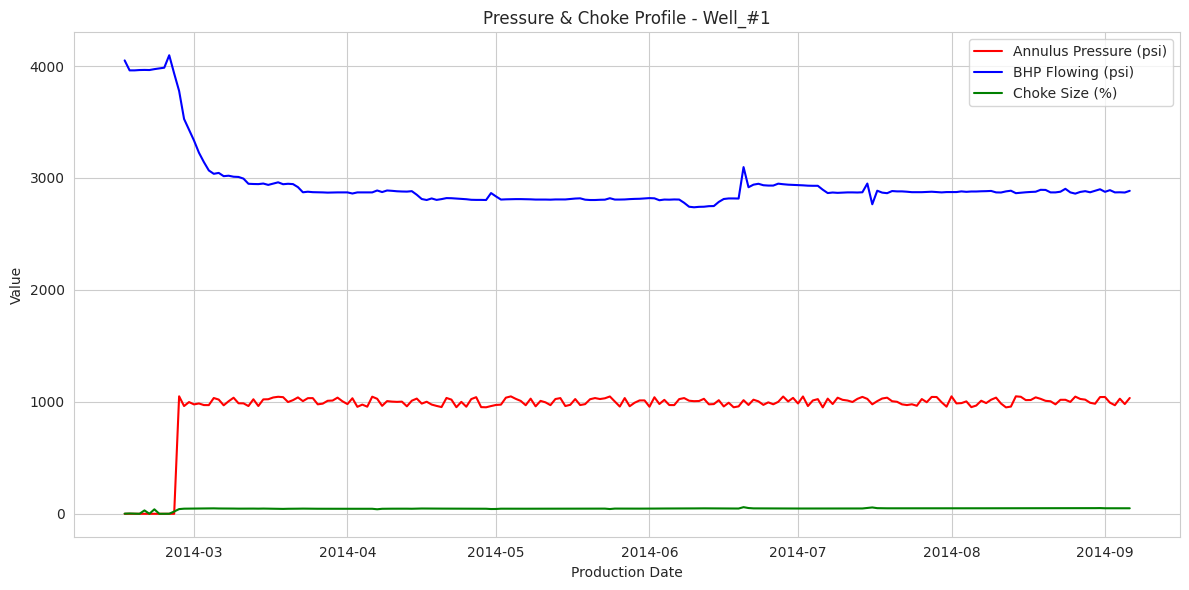

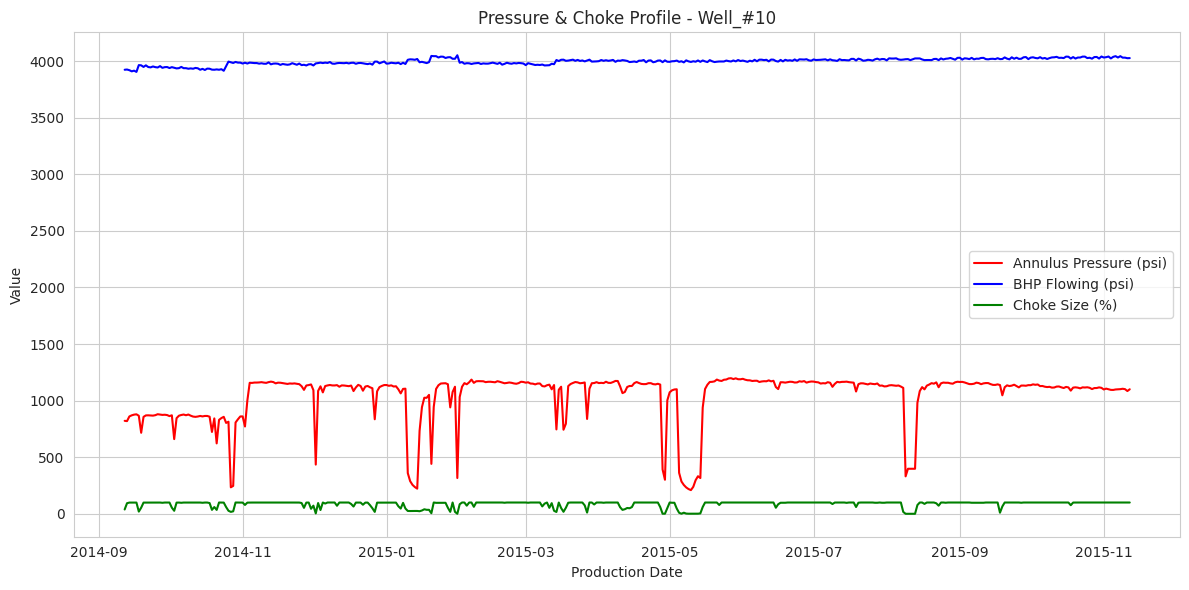

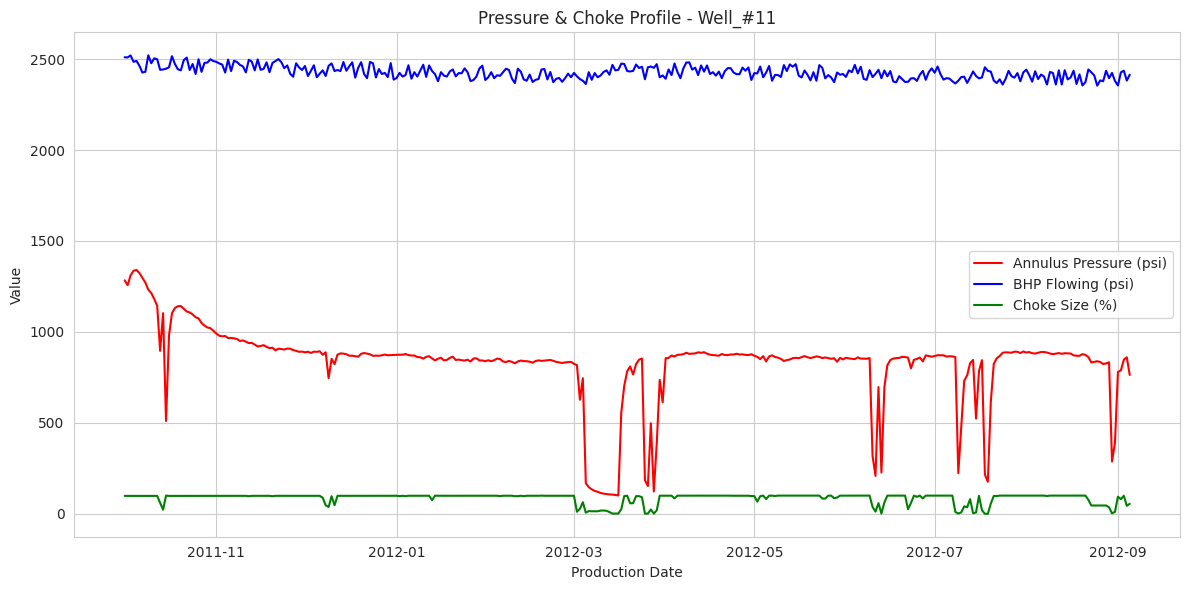

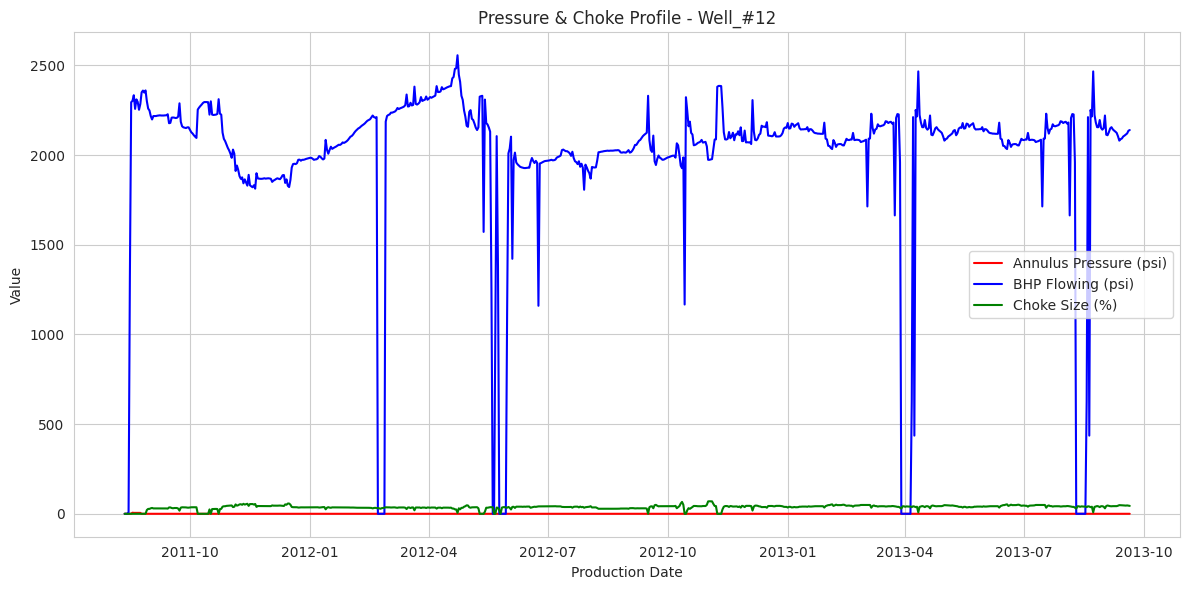

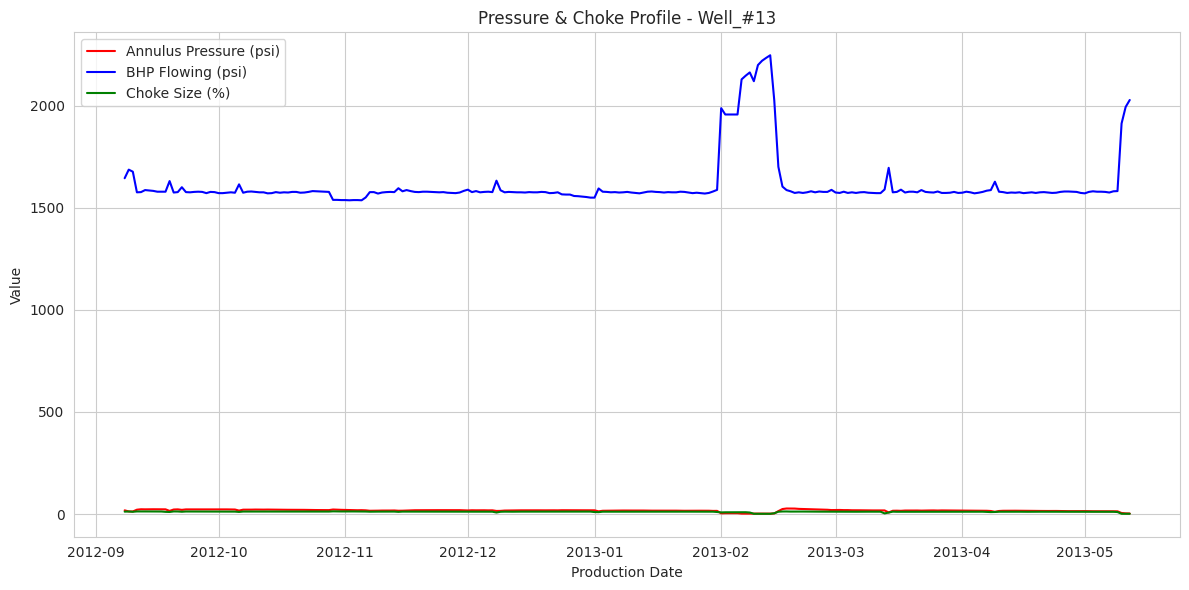

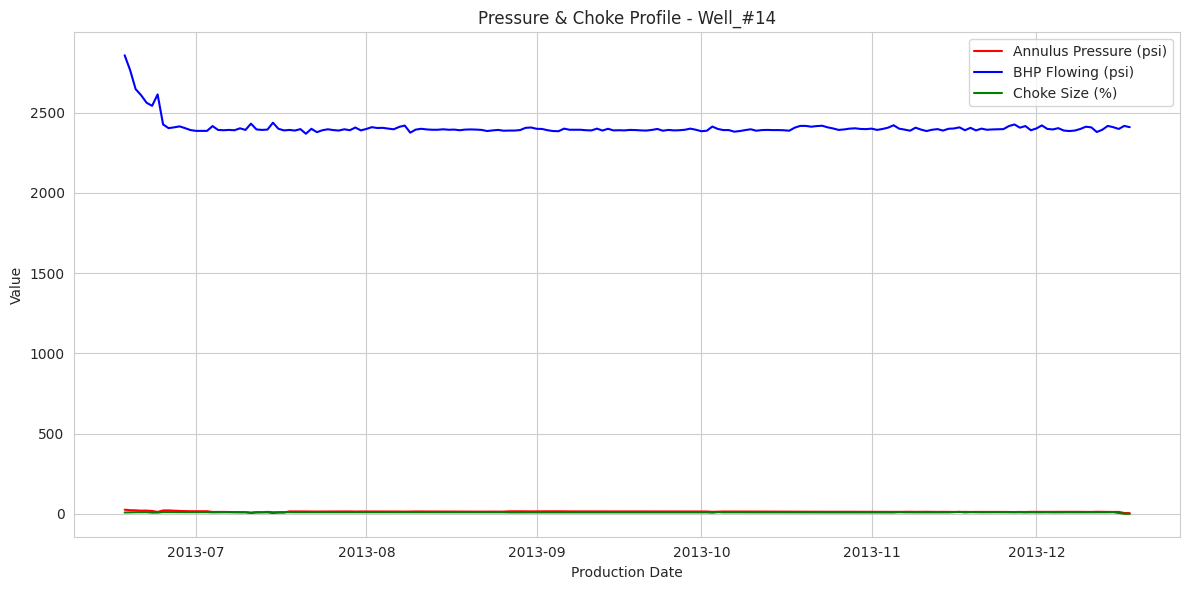

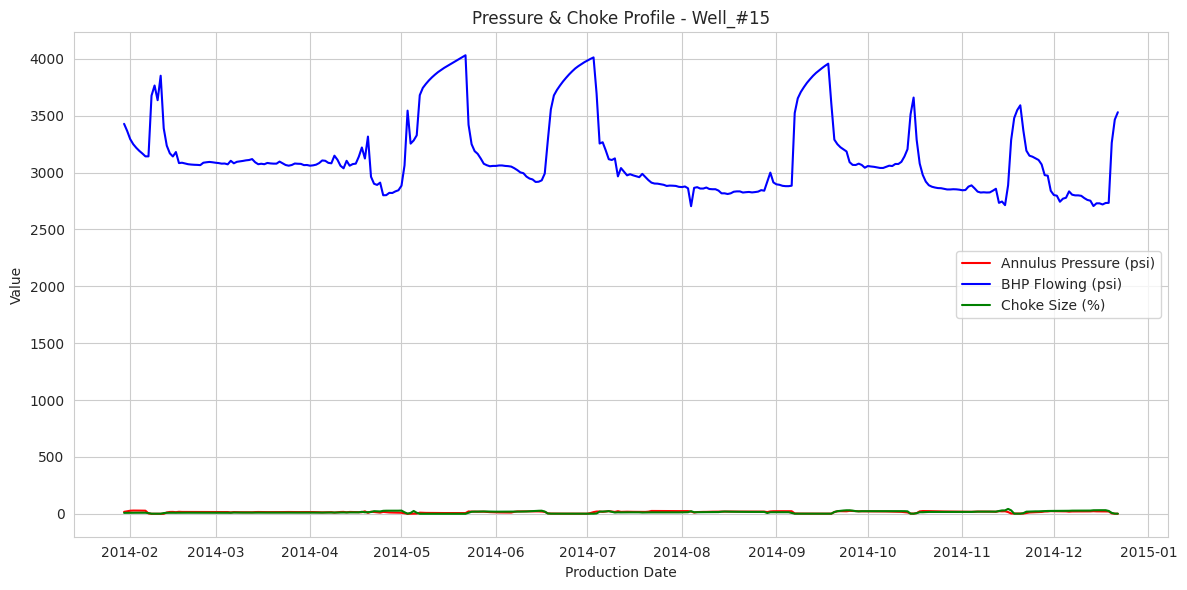

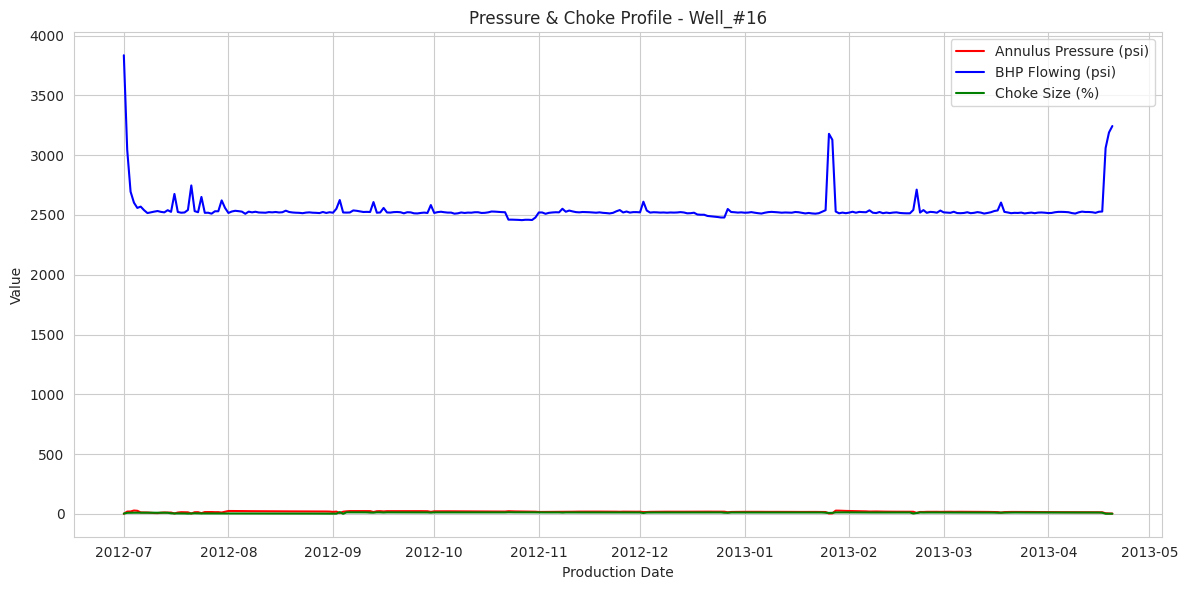

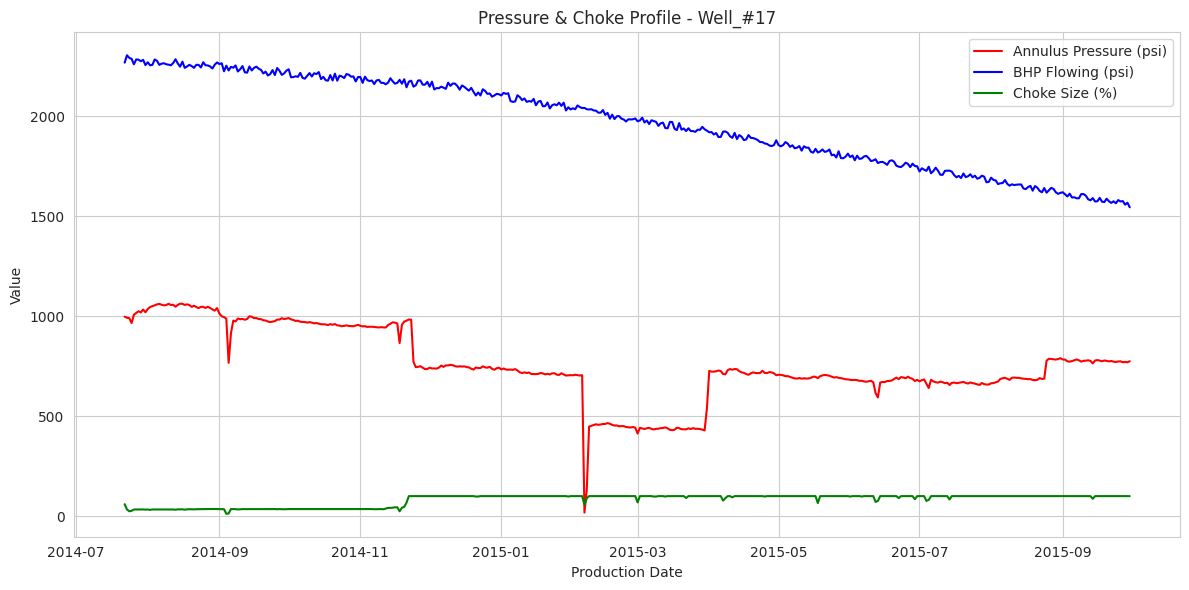

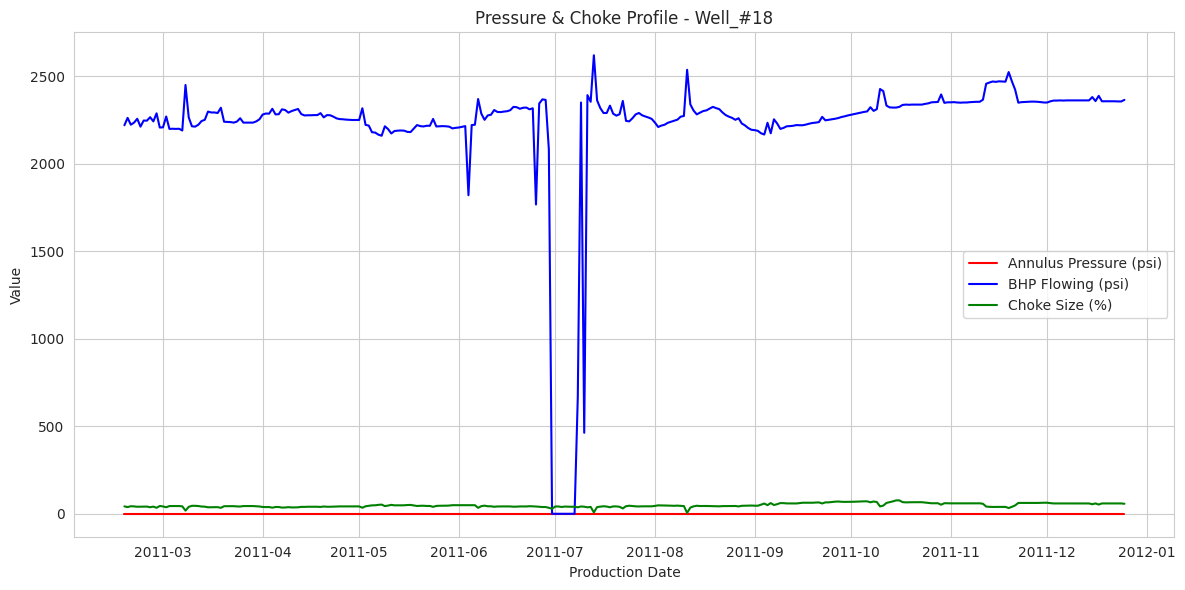

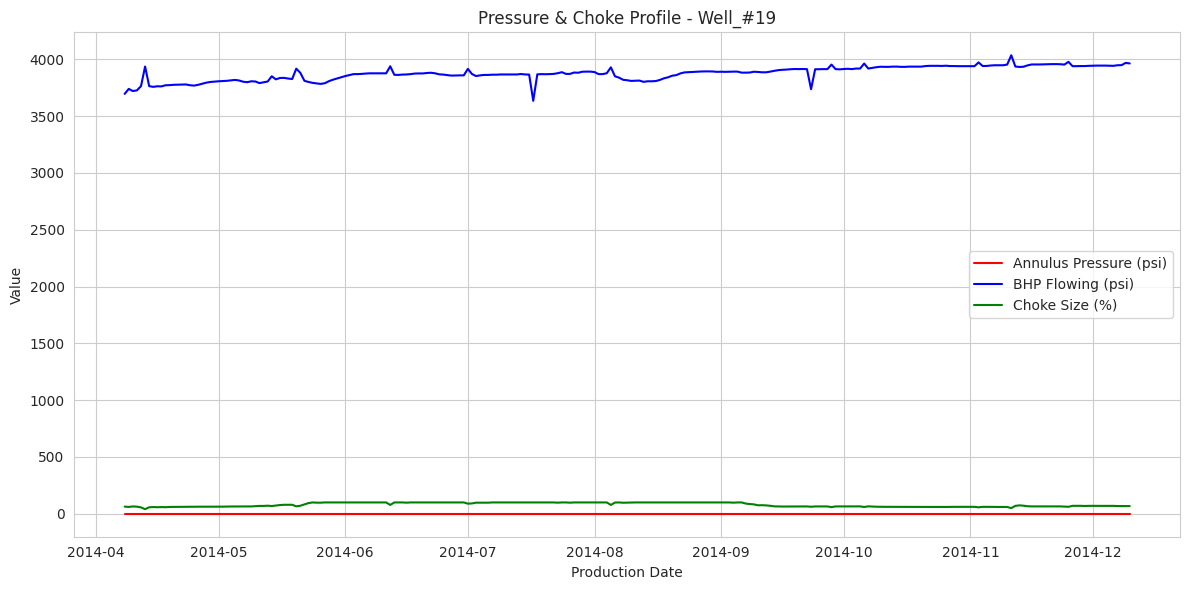

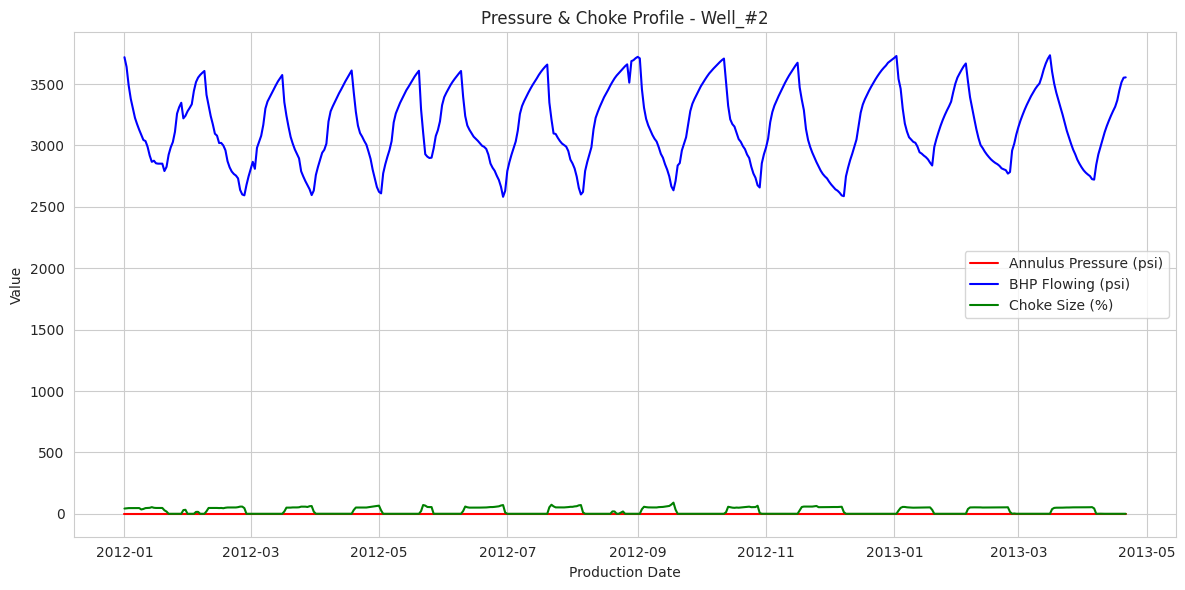

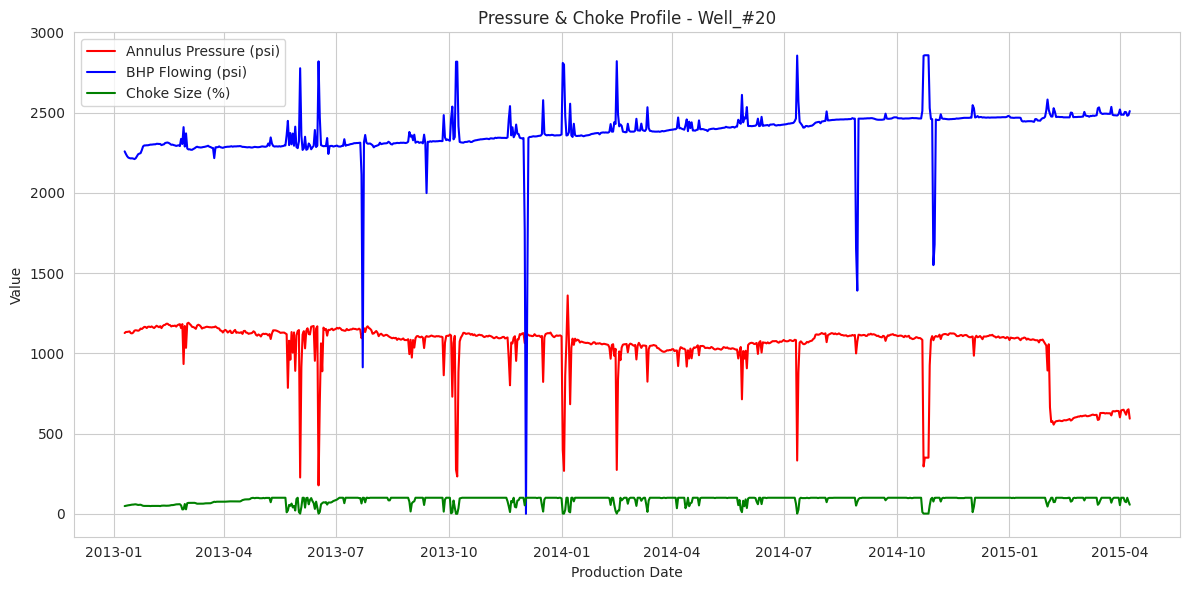

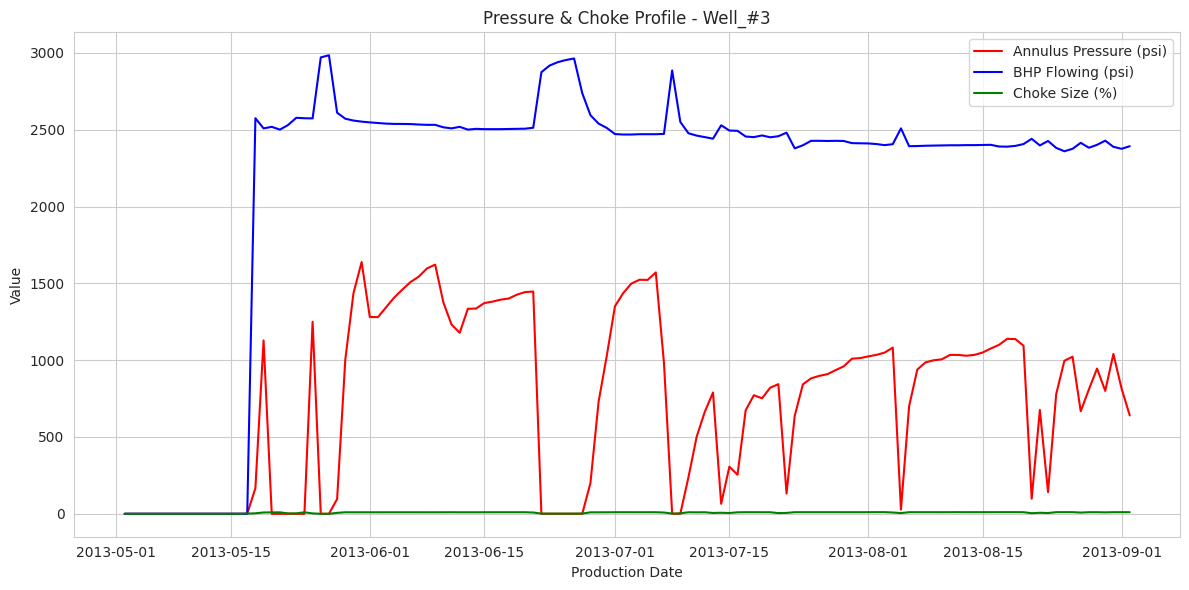

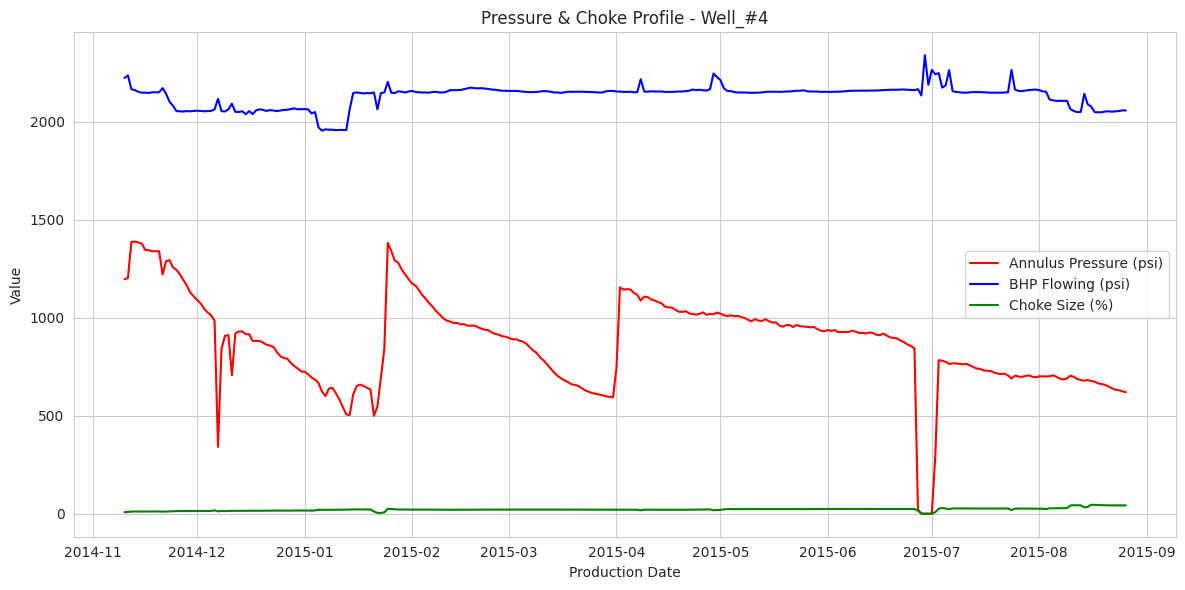

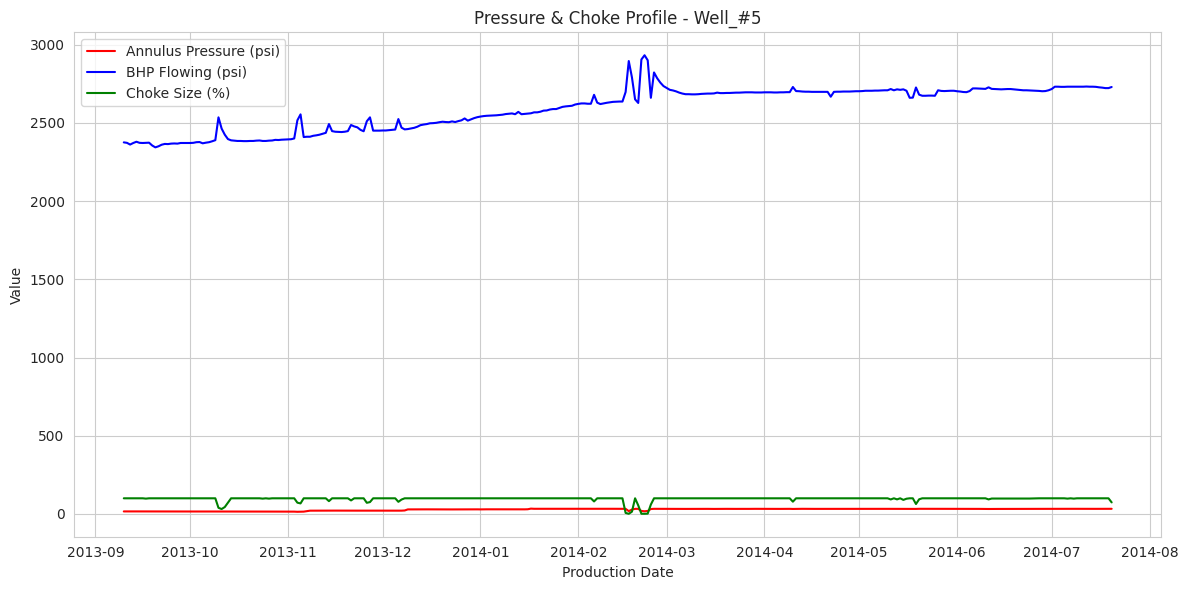

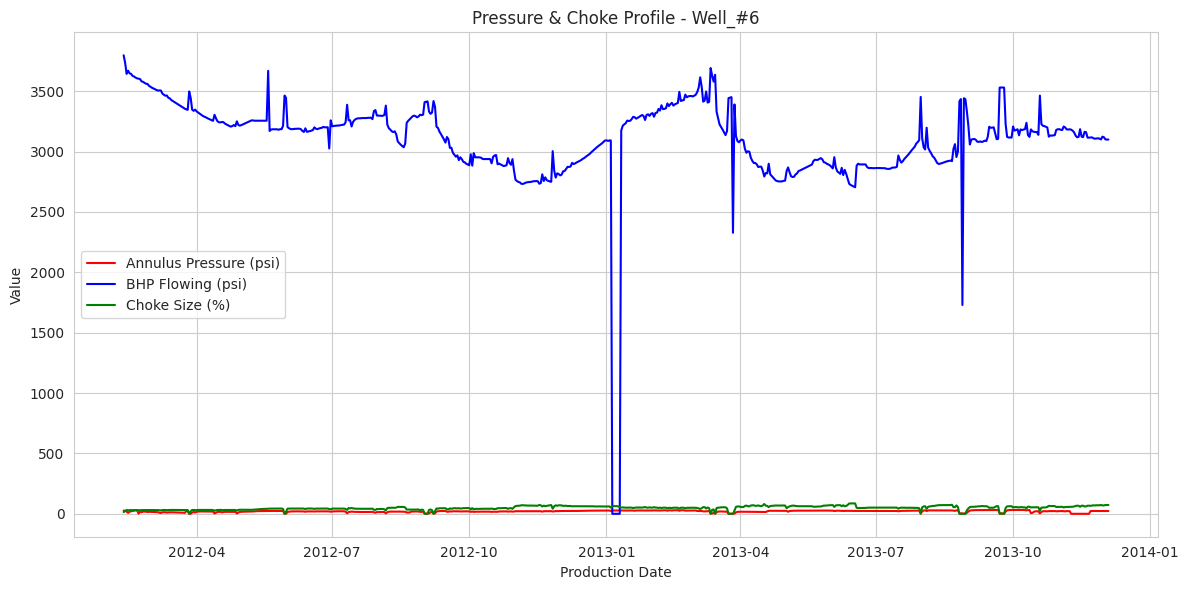

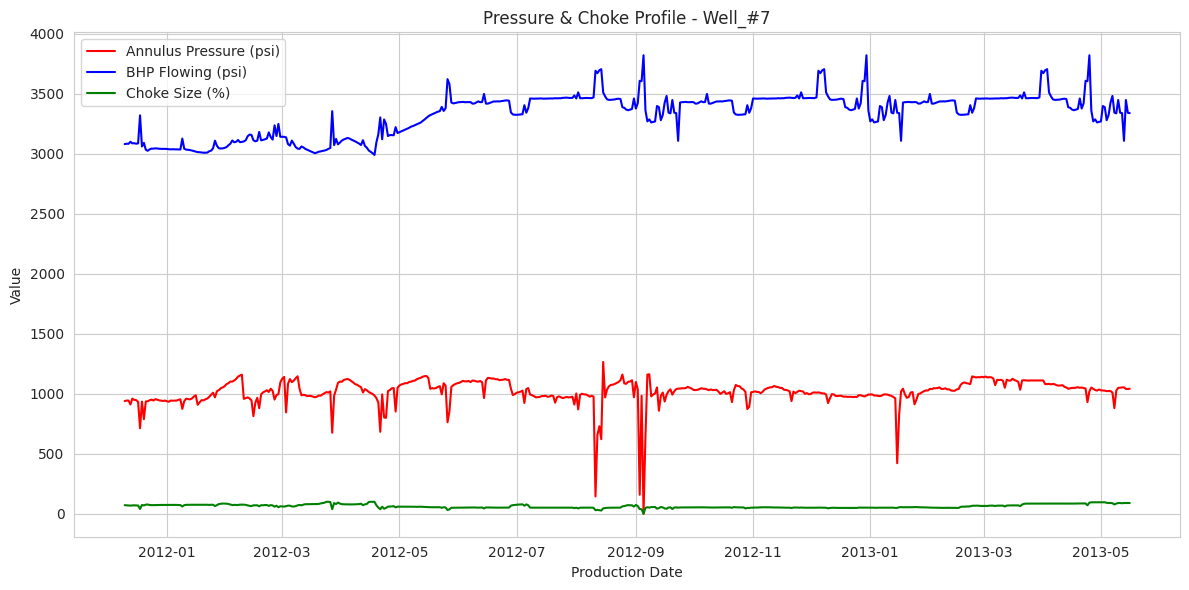

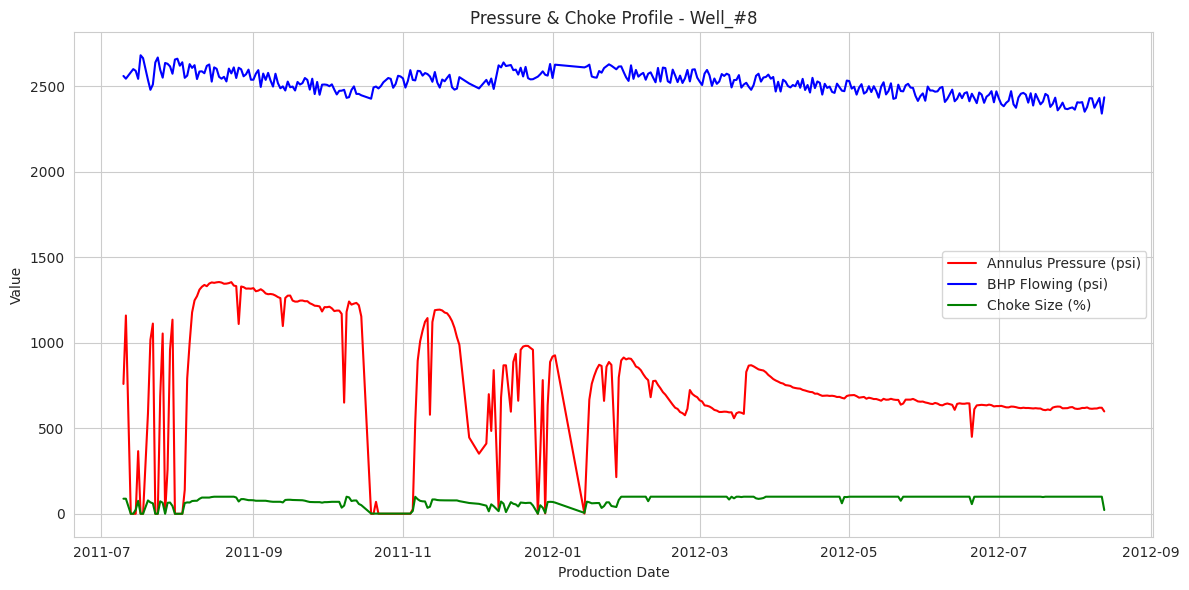

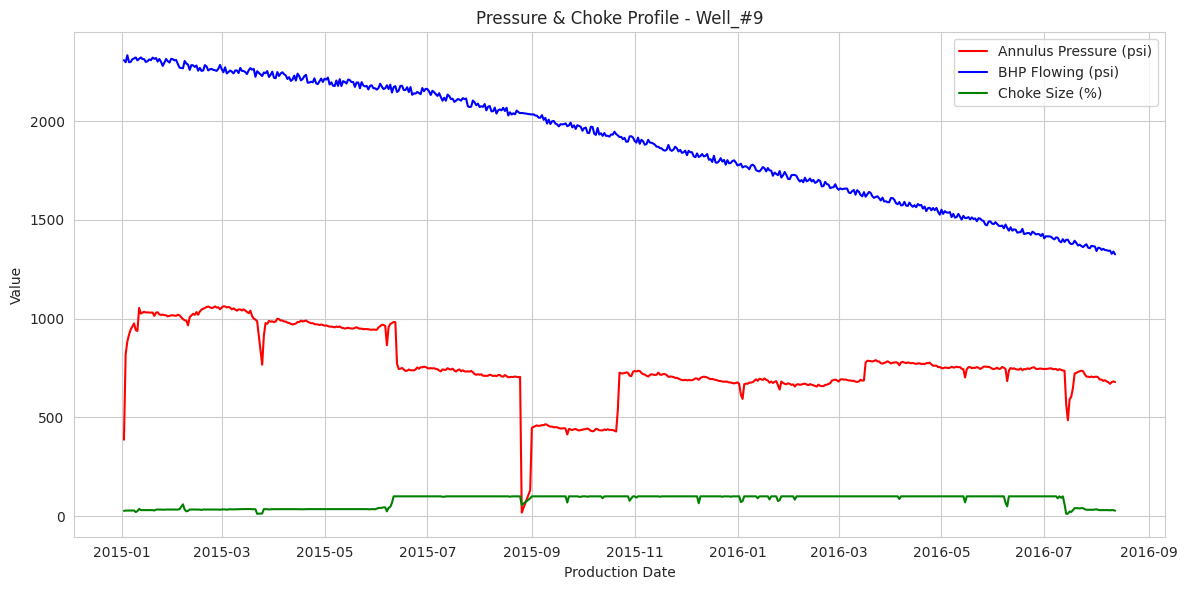

In [ ]:
# set plot style
sns.set_style("whitegrid")


wells = prod_df['WELL_NAME'].unique()

# We loop through wells and plot
for well in wells:
    df_well = prod_df[prod_df['WELL_NAME'] == well].copy()

    plt.figure(figsize=(12, 6))

    # Plot 1: Annulus Pressure
    plt.plot(df_well['PROD_DATE'], df_well['ANNULUS_PRESS (PSI)'], label='Annulus Pressure (psi)', color='red')

    # Plot 2: Bottomhole Flowing Pressure
    plt.plot(df_well['PROD_DATE'], df_well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'], label='BHP Flowing (psi)', color='blue')

    # Plot 3: Choke Size
    plt.plot(df_well['PROD_DATE'], df_well['CHOKE_SIZE (%)'], label='Choke Size (%)', color='green')

    plt.title(f'Pressure & Choke Profile - {well}')
    plt.xlabel('Production Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
prod_df["Well Type"] = np.where(prod_df["ANNULUS_PRESS (PSI)"] > 300,
                             "GL",    # Gas Lift
                             "NF")    # Flowing / non‑assisted
prod_df.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
0               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
1               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
2               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
3               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
4               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   

    BO  Reservoir Type Well Type  
0  1.3  Undersaturated        NF  
1  1.3  Undersaturated        NF  
2  1.3  Undersaturated        NF  
3  1.3  Undersaturated        NF  
4  1.3  Undersaturated        NF

# Task 4 - Production Type
**To determine if production from a well is steady or unsteady.**  
**Consider unsteady wells as those with more than 50% drop in oil production at least once every 3 to 6 months.**
  1. We resample oil production data to monthly totals.
  2. For each well:
     * We look at all rolling windows of 3–6 months.
     * In each window, we check if there is a >50% drop from any previous month's production to any later month.
     * If such a drop happens at least once, we classify as "Unsteady".
     * Else, we classify as "Steady".

In [ ]:
# We resample to monthly oil production per well
monthly_prod = prod_df.groupby(['WELL_NAME', pd.Grouper(key='PROD_DATE', freq='M')])['OIL_PROD (STB)'].sum().reset_index()

well_classification = {}

# We loop through each well
for well, df in monthly_prod.groupby('WELL_NAME'):
    df = df.sort_values('PROD_DATE').reset_index(drop=True)
    prod_series = df['OIL_PROD (STB)'].values

    unsteady = False
    n = len(prod_series)

    # Check all rolling windows of 3 to 6 months
    for window in range(3, 7):
        for i in range(n - window + 1):
            window_data = prod_series[i:i+window]
            for j in range(len(window_data)):
                for k in range(j+1, len(window_data)):
                    if window_data[j] > 0 and (window_data[k] / window_data[j]) < 0.5:
                        unsteady = True
                        break
                if unsteady:
                    break
            if unsteady:
                break
        if unsteady:
            break

    well_classification[well] = 'Unsteady' if unsteady else 'Steady'


well_stability = pd.DataFrame.from_dict(well_classification, orient='index', columns=['Production Type']).reset_index().rename(columns={'index': 'WELL_NAME'})

prod_df = prod_df.merge(well_stability, on='WELL_NAME', how='left')


In [ ]:
prod_df.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
0               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
1               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
2               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
3               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
4               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   

    BO  Reservoir Type Well Type Production Type  
0  1.3  Undersaturated        NF        Unsteady  
1  1.3  Undersaturated        NF        Unsteady  
2  1.3  Undersaturated        NF        Unsteady  
3  1.3  Undersaturated        NF        Unsteady  
4  1.3  Undersaturated        NF        Unsteady

In [ ]:
prod_df[prod_df['Production Type'] == 'Steady']['WELL_NAME'].unique()

array(['Well_#12', 'Well_#16', 'Well_#17', 'Well_#18', 'Well_#4'],
      dtype=object)

In [ ]:
display(monthly_prod)

WELL_NAME  PROD_DATE  OIL_PROD (STB)
0     Well_#1 2014-02-28          3348.0
1     Well_#1 2014-03-31         28990.0
2     Well_#1 2014-04-30         20817.0
3     Well_#1 2014-05-31         15373.0
4     Well_#1 2014-06-30         12200.0
..        ...        ...             ...
274   Well_#9 2016-04-30          6152.0
275   Well_#9 2016-05-31          5865.0
276   Well_#9 2016-06-30          5409.0
277   Well_#9 2016-07-31          4533.0
278   Well_#9 2016-08-31          1442.0

[279 rows x 3 columns]

## Production-Type Profile

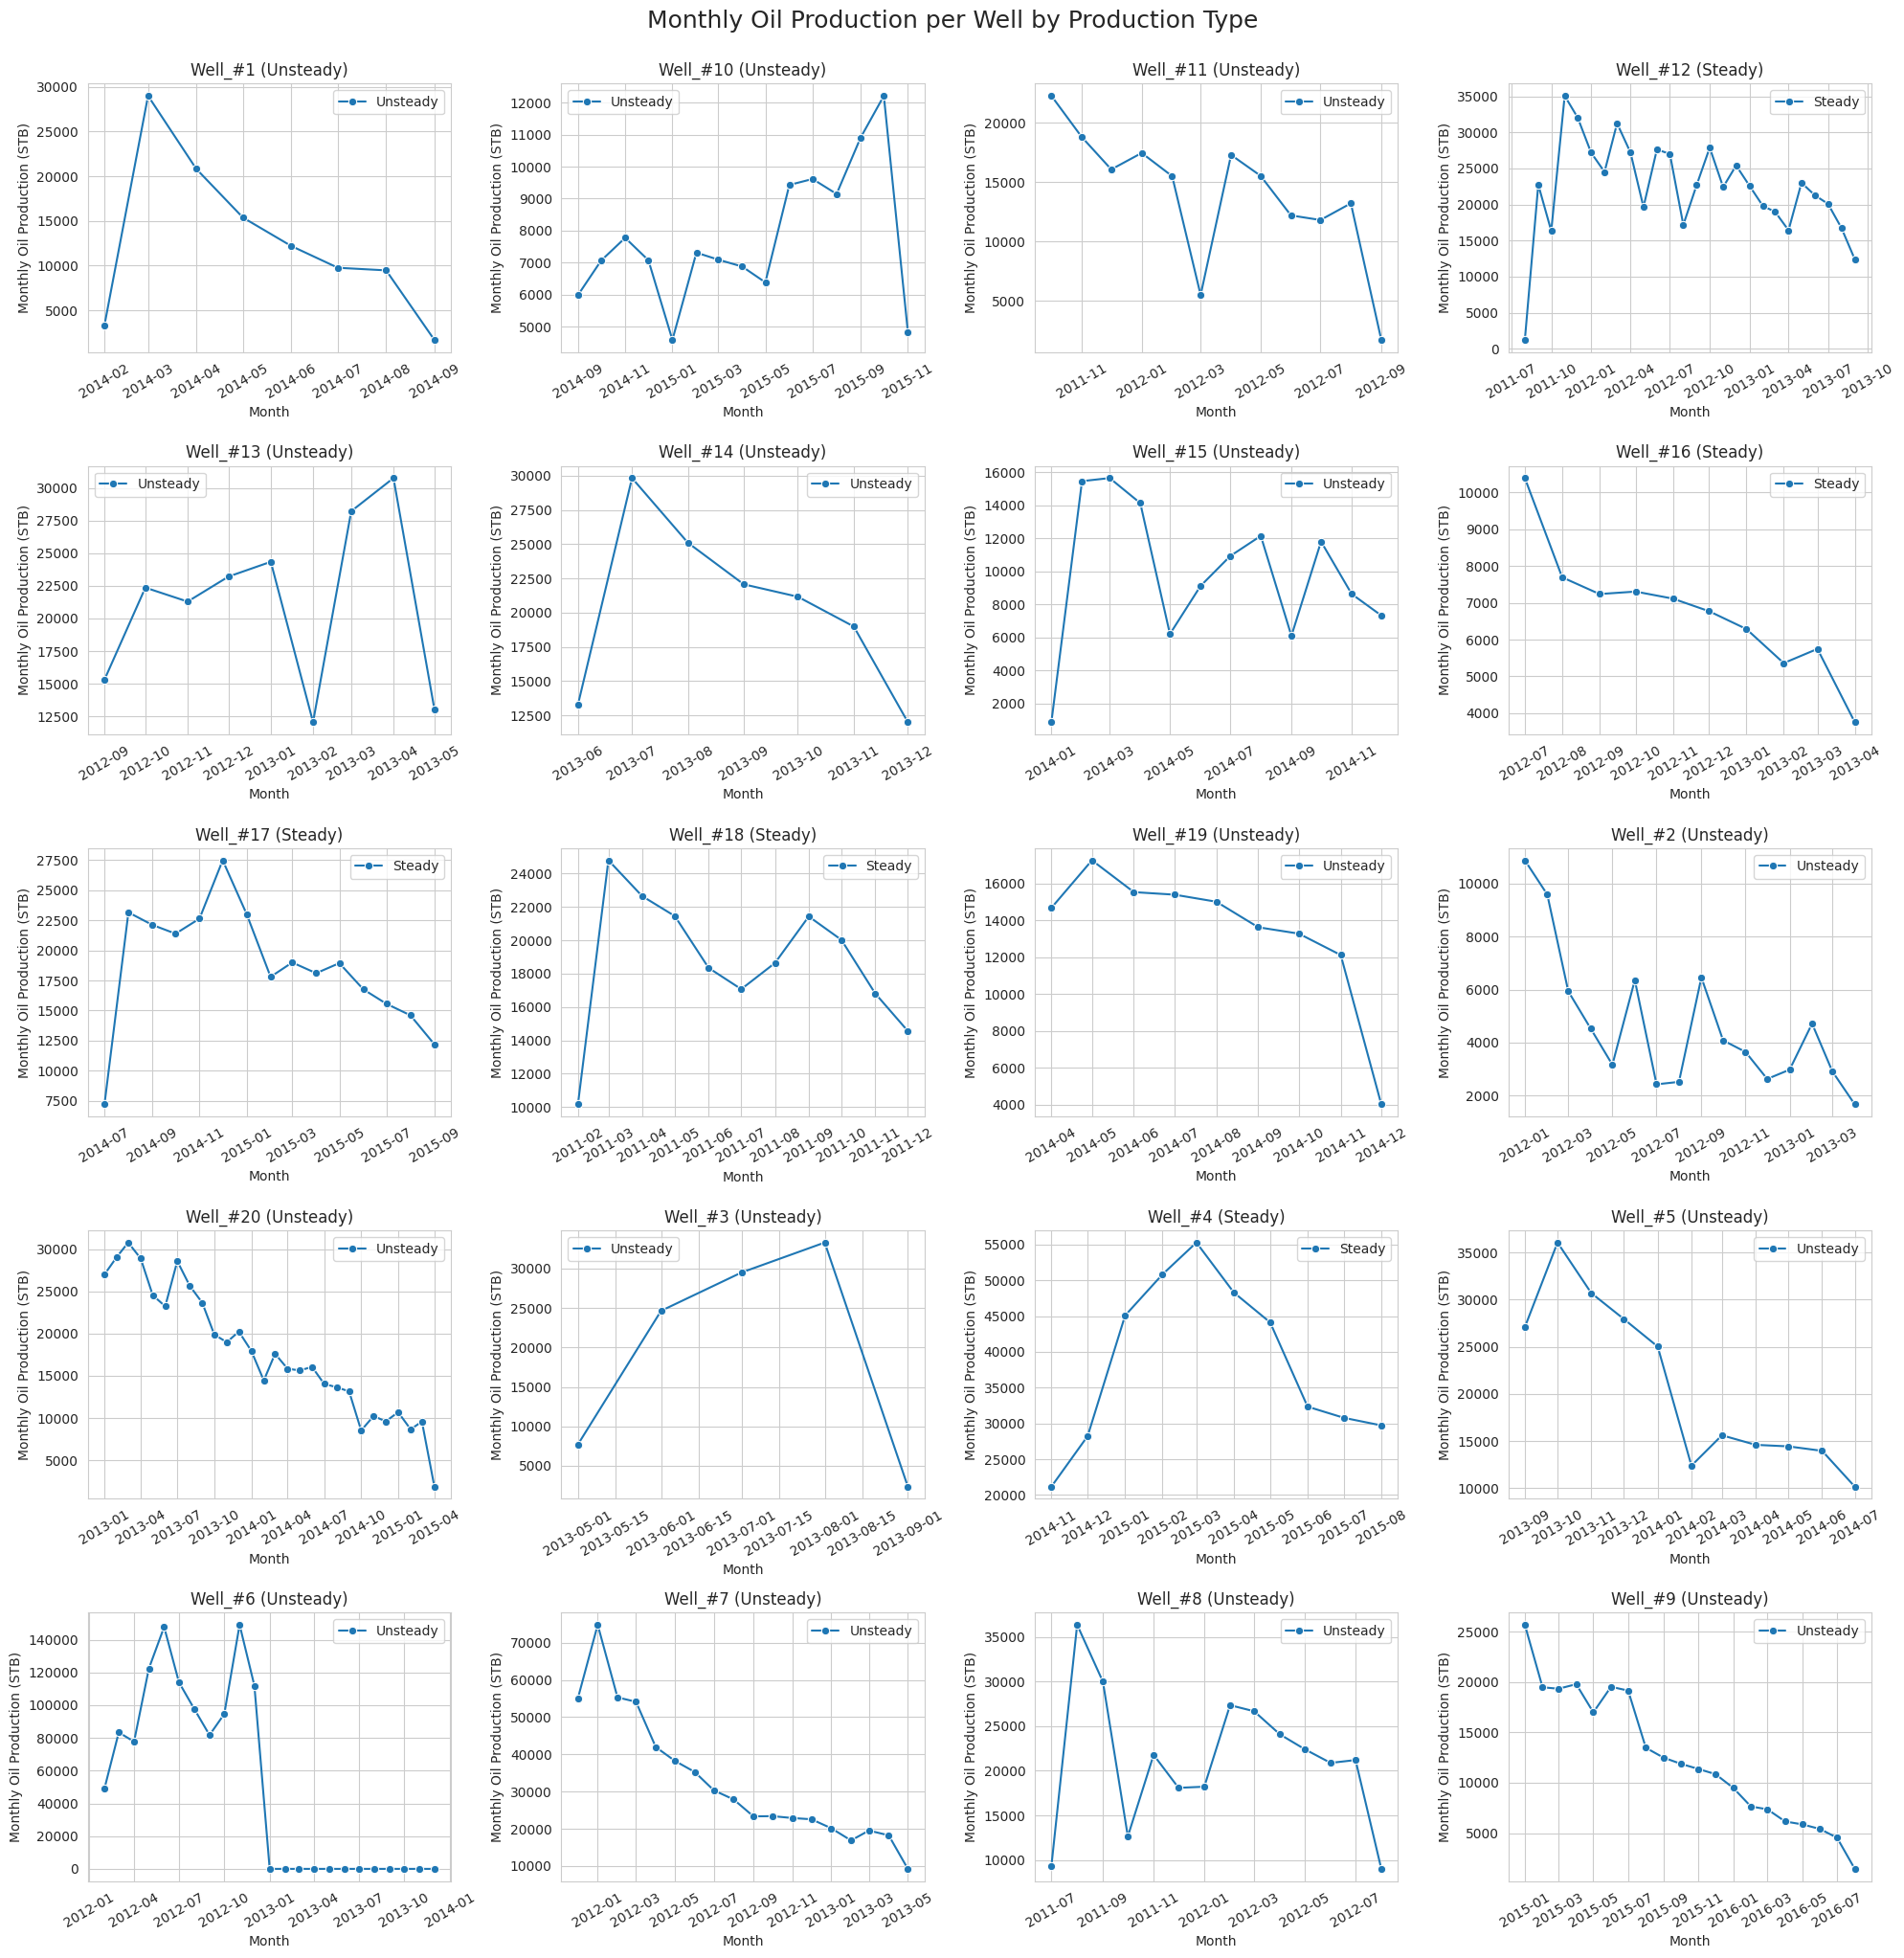

In [ ]:
# Create a new column for Year-Month
prod_df['MONTH'] = prod_df['PROD_DATE'].dt.to_period('M').dt.to_timestamp()

# Group to monthly production per well
monthly_prod = prod_df.groupby(['WELL_NAME', 'MONTH', 'Production Type'])['OIL_PROD (STB)'].sum().reset_index()

# Set up the plot grid
wells_to_plot = monthly_prod['WELL_NAME'].unique()
n_wells = len(wells_to_plot)
n_cols = 4
n_rows = (len(wells_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, well in enumerate(wells_to_plot, 1):
    well_data = monthly_prod[monthly_prod['WELL_NAME'] == well]
    prod_type = well_data['Production Type'].iloc[0]

    plt.subplot(n_rows, n_cols, i)
    sns.lineplot(
        data=well_data,
        x='MONTH',
        y='OIL_PROD (STB)',
        hue='Production Type',
        marker='o'
    )
    plt.title(f"{well} ({prod_type})")
    plt.xlabel("Month")
    plt.ylabel("Monthly Oil Production (STB)")
    plt.xticks(rotation=30)
    plt.legend().set_title("")  # Hide redundant title

plt.tight_layout()
plt.suptitle("Monthly Oil Production per Well by Production Type", fontsize=18, y=1.02)
plt.show()


# Task 5 - Formation GOR Trend    
**To determine from the formation GOR trend whether the well is either:**    
  1. Flowing above the solution GOR of the reservoir - aSolGOR
  2. Flowing below the solution GOR of the reservoir - bSolGOR
  3. Flowing above and below the solution GOR of the reservoir - Combo

       * We start by calculating the formation GOR using the formation gas produced and  rbl oil production (daily stb x bo)
       * We classify the gor trend based on the value of the formation gor and the solution gor per reservoir.
         

In [ ]:
prod_df.head(10)

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   
5 2014-02-20   Well_#1            0.0                             3964.0   
6 2014-02-21   Well_#1            0.0                             3972.0   
7 2014-02-22   Well_#1            0.0                             3978.0   
8 2014-02-23   Well_#1            0.0                             3985.0   
9 2014-02-24   Well_#1            0.0                             4096.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   
5                       190.181                  0.0         0.00000   
6                       189.939                  0.0        39.99891   
7                       189.609                  0.0         0.00000   
8                       189.435                  0.0         0.42376   
9                       189.343                  0.0         0.44066   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   
5                    58.036                         47.878   
6                   304.692                         47.938   
7                   453.734                         49.351   
8                   667.130                         49.351   
9                   440.036                         49.316   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   
5                        0.0                                   0.0   
6                        0.0                                   0.0   
7                        0.0                                   0.0   
8                        0.0                                   0.0   
9                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   
5                               0.0                          0.0   
6                               0.0                          0.0   
7                               0.0                          0.0   
8                               0.0                          0.0   
9                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.

In [ ]:
prod_df['Formation_GOR'] = np.where(
            prod_df["OIL_PROD (STB)"] > 0,
            (prod_df["FORM_GAS_PROD (MSCF)"] * 1000) / (prod_df["OIL_PROD (STB)"] * prod_df["BO"]),
                0
                )

In [ ]:
# We want the GOR comparison to be only made for valid values
valid_gor = prod_df[prod_df["Formation_GOR"] > 0].copy()

# Function to classify trend for each well
def classify_gor_trend(group):
    aSol = (group["Formation_GOR"] > group["SOL_GOR"]).any()
    bSol = (group["Formation_GOR"] <= group["SOL_GOR"]).any()

    if aSol and bSol:
        return "Combo"
    elif aSol:
        return "aSolGOR"
    elif bSol:
        return "bSolGOR"
    else:
        return "unknown_trend"

# Applying the function to each well
gor_trend = valid_gor.groupby("WELL_NAME").apply(classify_gor_trend).reset_index()
gor_trend.columns = ["WELL_NAME", "Formation GOR Trend"]

# Merge back to the main DataFrame
prod_df = prod_df.merge(gor_trend, on="WELL_NAME", how="left")


In [ ]:
prod_df['Formation GOR Trend'].unique()

array(['bSolGOR', 'Combo'], dtype=object)

## Profile of Formation GOR - Solution GOR

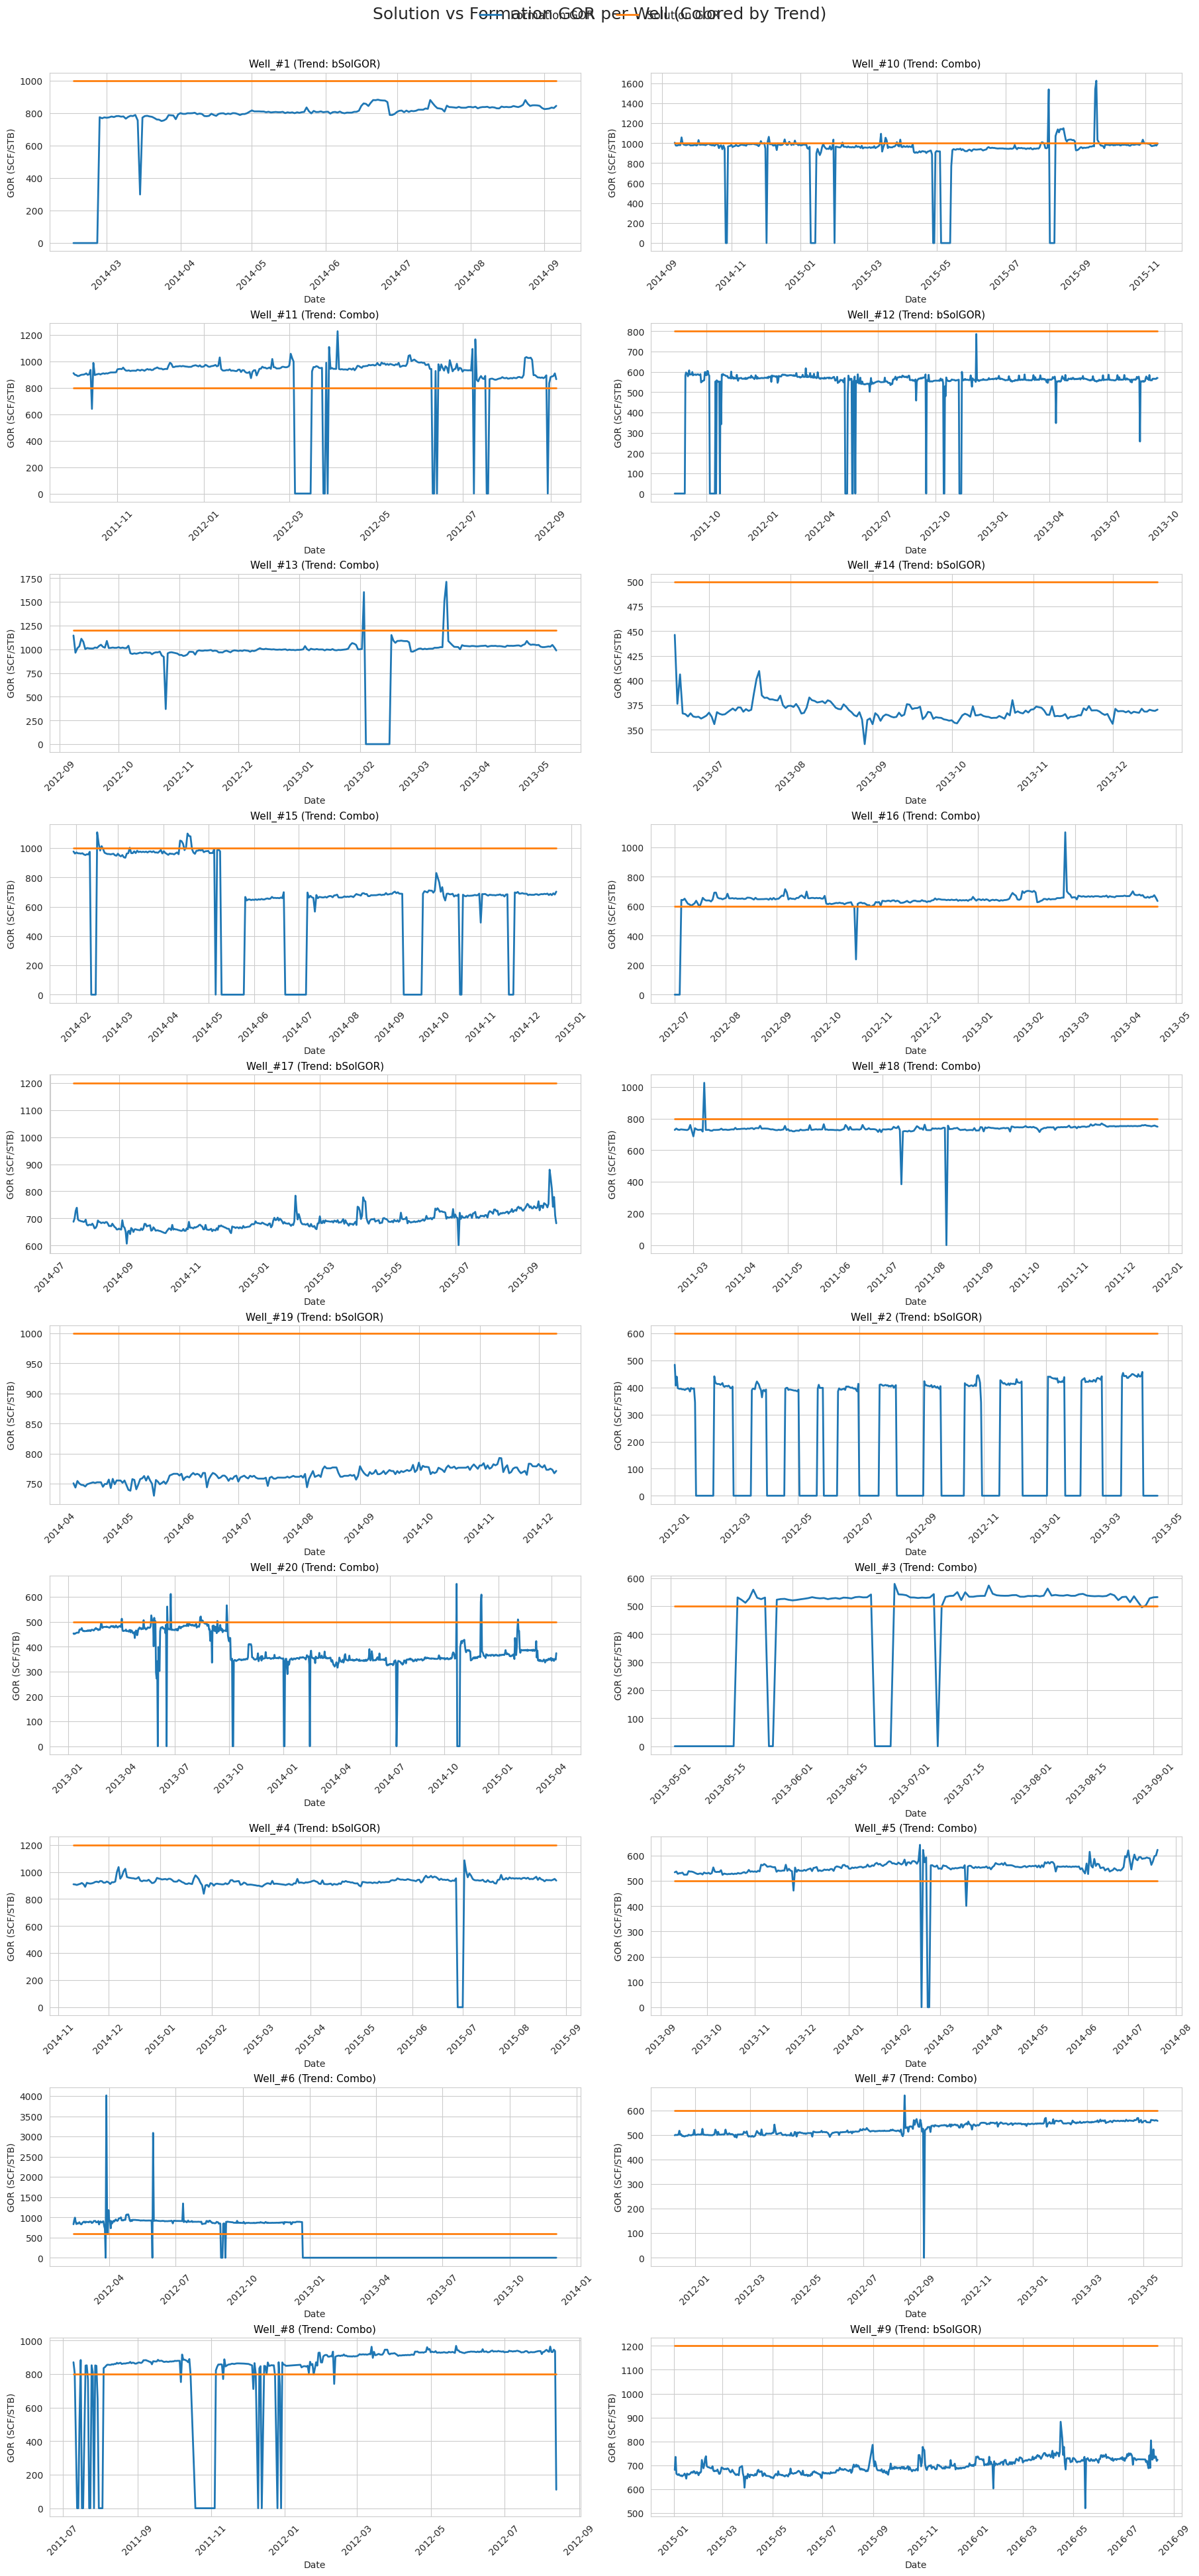

In [ ]:
formation_gor_col = "Formation_GOR"
solution_gor_col = "SOL_GOR"

well_list = sorted(prod_df["WELL_NAME"].unique())

fig, axes = plt.subplots(
    nrows=10,
    ncols=2,
    figsize=(18, 38),
    sharex=False,
    sharey=False,
    constrained_layout=True
)

axes = axes.flatten()

trend_colors = {
    "Increasing": "red",
    "Decreasing": "green",
    "Flat": "black"
}

for ax, well in zip(axes, well_list):
    d = prod_df[prod_df["WELL_NAME"] == well].sort_values("PROD_DATE")

    trend = d["Formation GOR Trend"].iloc[0] if "Formation GOR Trend" in d.columns else "Unknown"
    color = trend_colors.get(trend, "black")

    ax.plot(d["PROD_DATE"], d[formation_gor_col], label="Formation GOR", linewidth=2)
    ax.plot(d["PROD_DATE"], d[solution_gor_col], label="Solution GOR", linewidth=2)

    ax.set_title(f"{well} (Trend: {trend})", fontsize=11, color=color)
    ax.set_xlabel("Date")
    ax.set_ylabel("GOR (SCF/STB)")
    ax.tick_params(axis='x', rotation=45)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=2,
    frameon=False,
    fontsize="large"
)

plt.suptitle("Solution vs Formation GOR per Well (Colored by Trend)", fontsize=18, y=1.02)
plt.show()


# TASK 6 - Watercut Trend  
**To determine whether the watercut trend per well is either:**    
  1. A flat or fairly horizontal line trend - Flat
  2. An increasing trend - Incr
  3. A decreasing trend - Decr
  4. A combination of two or more trends - Combo

       * We start by calculating the water cut per well.
       * We divide the watercut into two segments, and fit a Linear Regression model per segment.
       * We classify the trend based on the slope per segment, and the flat(horizontal) threshold.

In [ ]:
prod_df['Watercut'] = np.where((prod_df['OIL_PROD (STB)'] > 0) | (prod_df['WATER_PROD (BBL)'] > 0),
                              prod_df['WATER_PROD (BBL)'] /
                               (prod_df['OIL_PROD (STB)'] + prod_df['WATER_PROD (BBL)']),
                               0
                              )

In [ ]:
# our sanity check that it worked accordingly
prod_df[(prod_df['OIL_PROD (STB)'] == 0) & (prod_df['WATER_PROD (BBL)'] > 0)]

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
2409 2014-09-22  Well_#15           24.0                             3223.0   
7153 2011-12-26   Well_#8            0.0                             2556.0   

      DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
2409                       205.656               22.781        26.21868   
7153                       144.587                0.000         0.32705   

      WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
2409                    26.155                         95.622   
7153                   135.192                         26.260   

      CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
2409                    87250.0                               95400.0   
7153                   125040.0                              129041.0   

      CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
2409                           95400.0                      73286.0   
7153                          206838.0                     103377.0   

      OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
2409             0.0                   0.0                    0.0   
7153             0.0                   0.0                    0.0   

      WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
2409               1.0    4032.0      JANI  4500.0    4300.0  4200.0   1000.0   
7153               3.0    2681.0      ACHI  3500.0    3300.0  2700.0    800.0   

       BO  Reservoir Type Well Type Production Type      MONTH  Formation_GOR  \
2409  1.3  Undersaturated        NF        Unsteady 2014-09-01            0.0   
7153  1.2  Undersaturated        NF        Unsteady 2011-12-01            0.0   

     Formation GOR Trend  Watercut  
2409               Combo       1.0  
7153               Combo       1.0

In [ ]:
# Function for slope classification
def classify_slope(slope, flat_threshold=0.00035):
    if abs(slope) < flat_threshold:
        return "Flat"
    elif slope > 0:
        return "Incr"
    else:
        return "Decr"

# segmentation and trend classification
def classify_watercut_trend_segments(well_df):
    watercut = well_df[['PROD_DATE', 'Watercut']].dropna().sort_values('PROD_DATE')
    # We filter out sudden zero or near-zero watercut values
    watercut = watercut[watercut['Watercut'] > 0.01]

    segments = np.array_split(watercut, 2)
    trends = []

    for seg in segments:
        if len(seg) < 2:
            continue
        X = np.arange(len(seg)).reshape(-1, 1)
        y = seg['Watercut'].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        trends.append(classify_slope(slope))

    if len(trends) == 0:
        return "Combo"

    unique_trends = set(trends)
    return list(unique_trends)[0] if len(unique_trends) == 1 else "Combo"

# We apply per well:
well_trends = prod_df.groupby('WELL_NAME').apply(classify_watercut_trend_segments)
prod_df['Watercut Trend'] = prod_df['WELL_NAME'].map(well_trends)


In [ ]:
prod_df['Watercut Trend'].unique()

array(['Incr', 'Flat', 'Combo', 'Decr'], dtype=object)

## Profile of Watercut

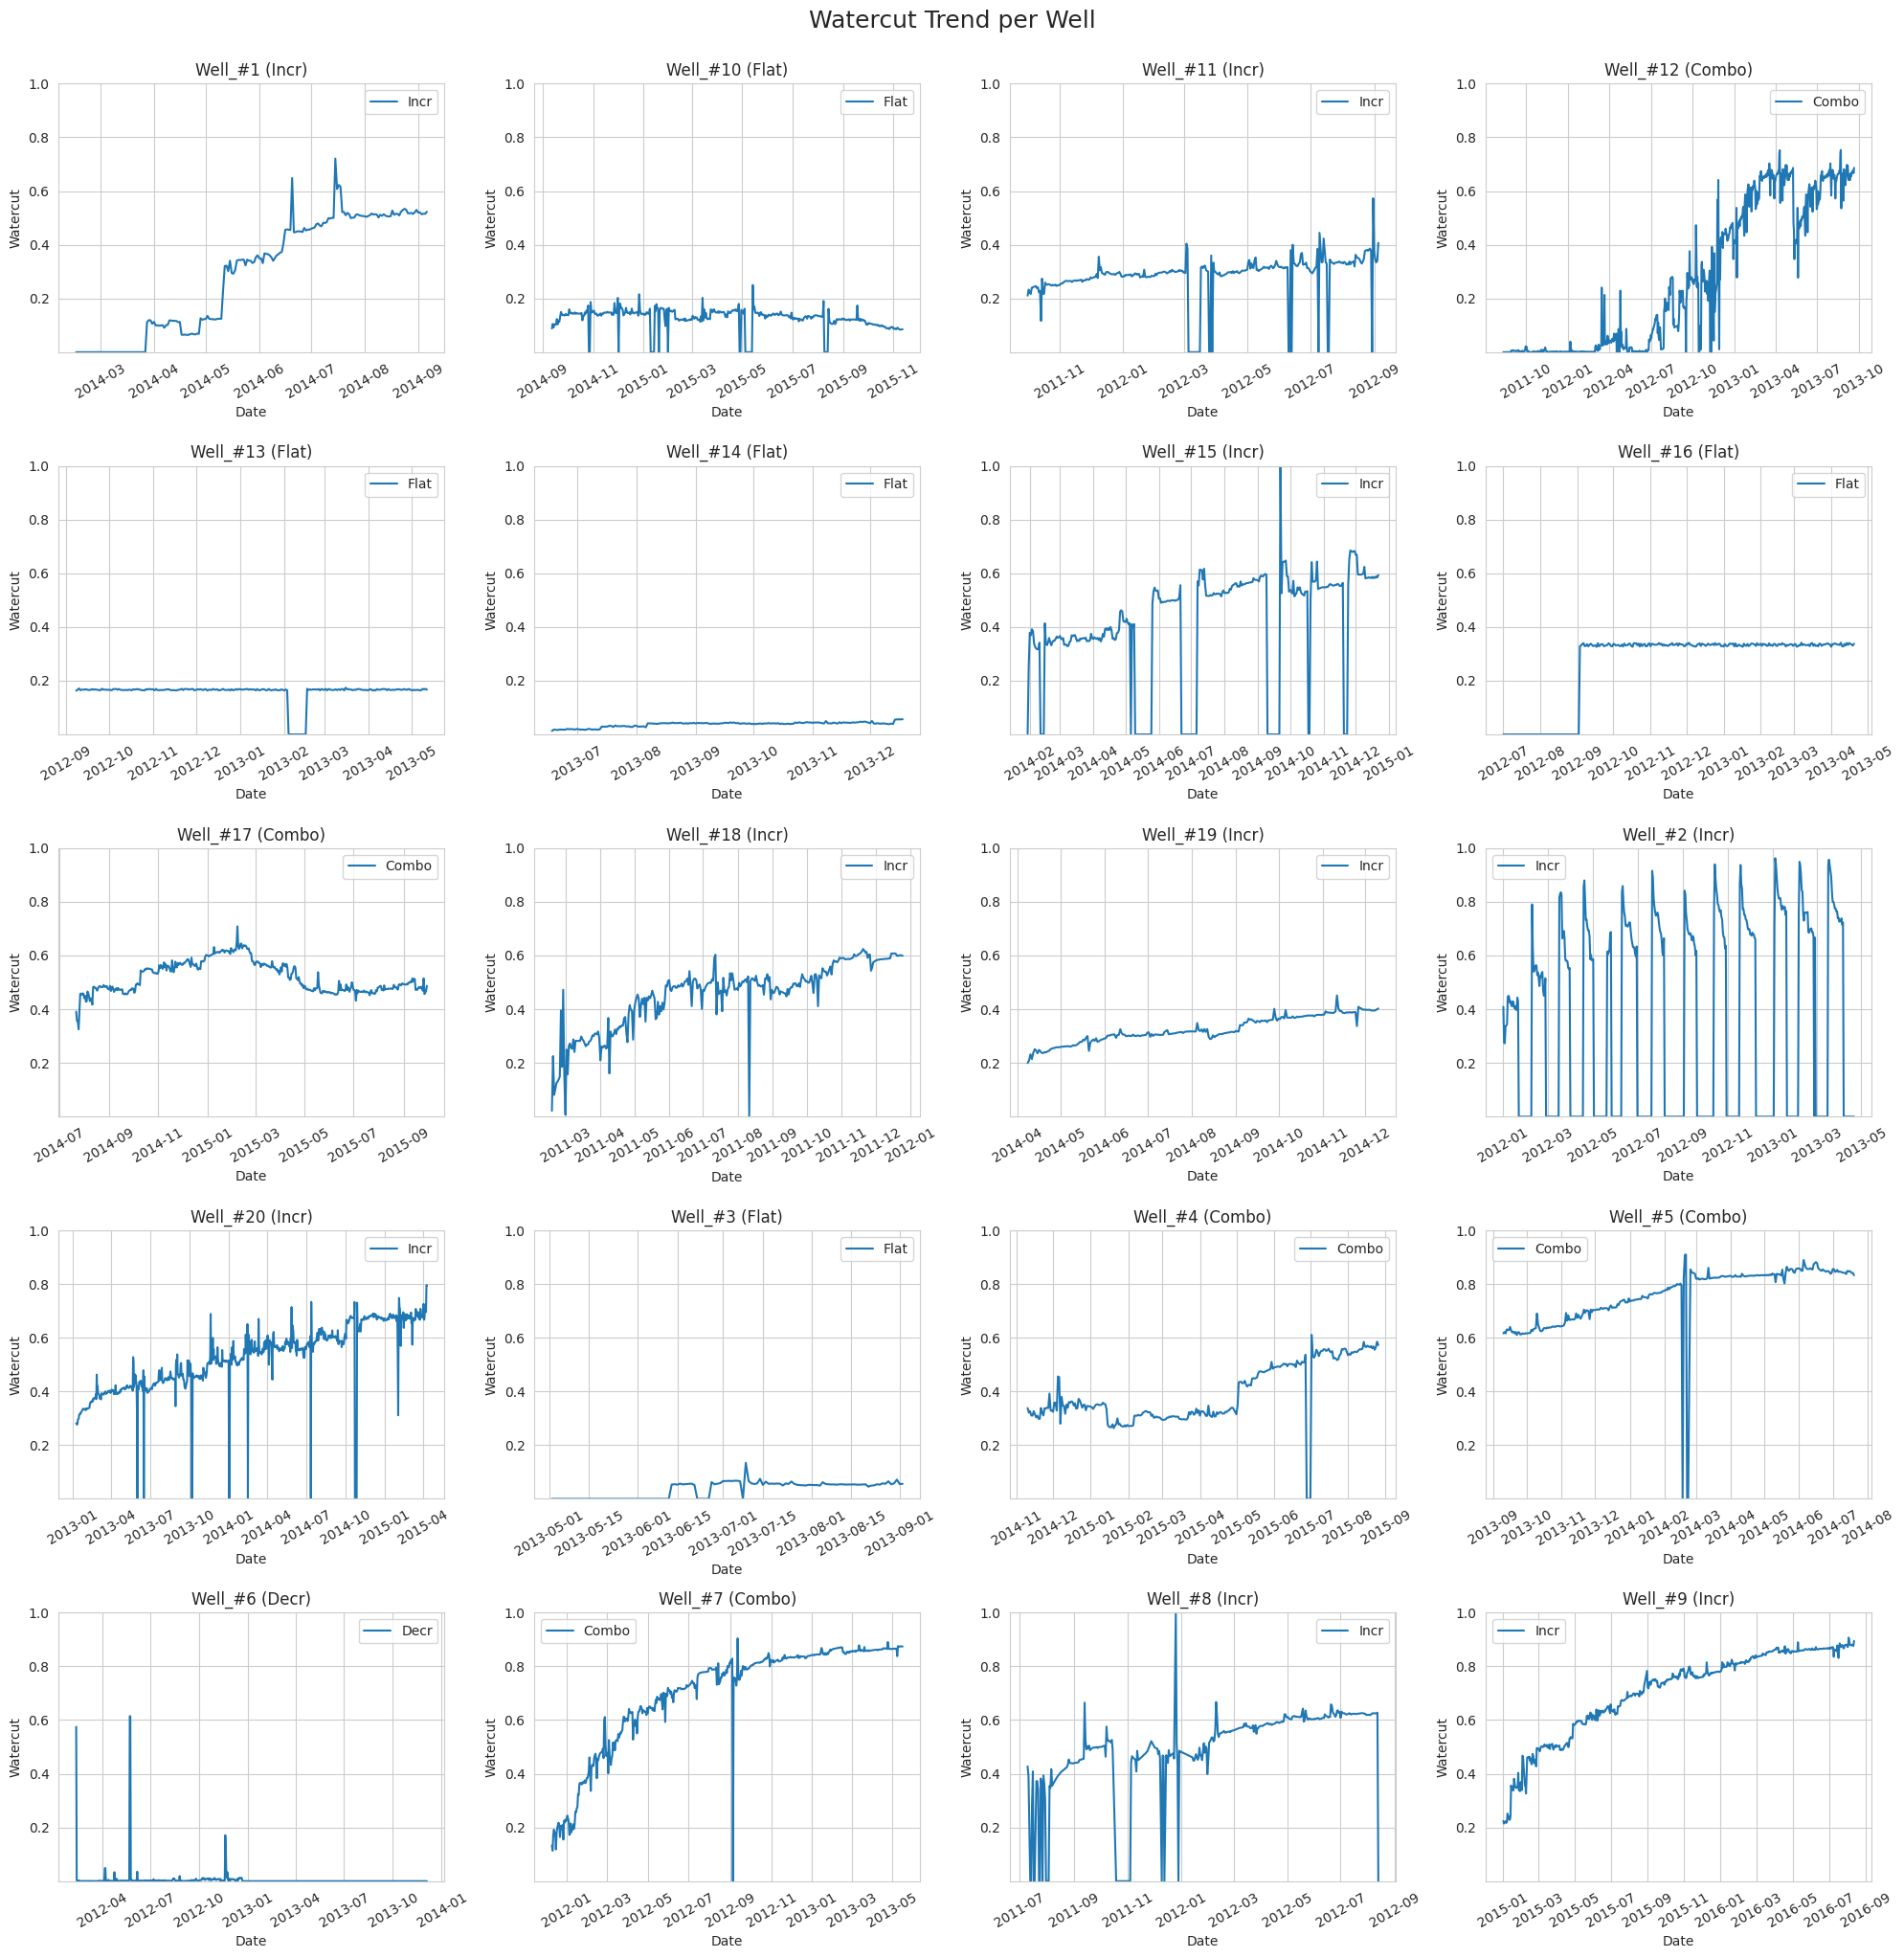

In [ ]:
well_trends = prod_df.groupby('WELL_NAME')['Watercut Trend'].first().reset_index()

wells_to_plot = well_trends['WELL_NAME'].unique()
n_wells = len(wells_to_plot)
n_cols = 4
n_rows = (n_wells + n_cols - 1) // n_cols

valid_wc = prod_df['Watercut'].replace(0, np.nan).dropna()
ymin, ymax = valid_wc.min(), valid_wc.max()

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, well in enumerate(wells_to_plot, 1):
    well_data = prod_df[prod_df['WELL_NAME'] == well]
    trend = well_data['Watercut Trend'].iloc[0]

    plt.subplot(n_rows, n_cols, i)
    sns.lineplot(data=well_data, x='PROD_DATE', y='Watercut', label=trend)
    plt.title(f"{well} ({trend})")
    plt.xlabel('Date')
    plt.ylabel('Watercut')
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.suptitle("Watercut Trend per Well", fontsize=18, y=1.02)
plt.show()


In [ ]:
prod_df.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
0               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
1               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
2               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
3               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
4               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   

    BO  Reservoir Type Well Type Production Type      MONTH  Formation_GOR  \
0  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
1  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
2  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
3  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
4  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   

  Formation GOR Trend  Watercut Watercut Trend  
0             bSolGOR       0.0           Incr  
1             bSolGOR       0.0           Incr  
2             bSolGOR       0.0           Incr  
3             bSolGOR       0.0           Incr  
4             bSolGOR       0.0           Incr

# TASK 7 - Oil Productivity Index Trend  
**To determine whether the oil productivity index trend per well is either:**    
  1. A flat or fairly horizontal line trend - Flat
  2. An increasing trend - Incr
  3. A decreasing trend - Decr
  4. A combination of two or more trends - Combo

       * We start by calculating the flowrate per well.
       * Next, we calculate the Productivity index using the flowrate and the drawdown.
       * We divide the productivity index into two segments, and fit a Linear Regression model per segment.
       * We classify the trend based on the slope per segment, and the flat(horizontal) threshold.
         

In [ ]:
prod_df['Qo'] = prod_df.apply(
    lambda row: ((row['OIL_PROD (STB)'] / row['ON_STREAM_HRS']) * 24)
    if row['ON_STREAM_HRS'] > 0 else 0, axis=1
)

prod_df['Pressure_drawdown'] = prod_df['P_AVG'] - prod_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']


prod_df['Oil Productivity Index'] = prod_df.apply(
    lambda row: (row['Qo'] / row['Pressure_drawdown'])
    if row['Pressure_drawdown'] > 0 else 0, axis=1
)

In [ ]:
# Function for slope classification
def classify_slope(slope, flat_threshold=0.0005):
    if abs(slope) < flat_threshold:
        return "Flat"
    elif slope > 0:
        return "Incr"
    else:
        return "Decr"

# segmentation and trend classification
def classify_productivity_index_trend_segments(well_df):
    PI = well_df[['PROD_DATE', 'Oil Productivity Index']].dropna().sort_values('PROD_DATE')


    PI = PI[PI['Oil Productivity Index'] > 0.01]

    segments = np.array_split(PI, 2)
    trends = []

    for seg in segments:
        if len(seg) < 2:
            continue
        X = np.arange(len(seg)).reshape(-1, 1)
        y = seg['Oil Productivity Index'].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        trends.append(classify_slope(slope))

    if len(trends) == 0:
        return "Combo"

    unique_trends = set(trends)
    return list(unique_trends)[0] if len(unique_trends) == 1 else "Combo"

# We apply per well:
well_trends = prod_df.groupby('WELL_NAME').apply(classify_productivity_index_trend_segments)
prod_df['Oil Productivity Index Trend'] = prod_df['WELL_NAME'].map(well_trends)


In [ ]:
prod_df['Oil Productivity Index Trend'].unique()

array(['Decr', 'Incr', 'Combo'], dtype=object)

In [ ]:
prod_df['Oil Productivity Index'].describe([0.90, 0.95, 0.99, 0.999])

count    7955.000000
mean        1.770788
std         2.277506
min         0.000000
50%         1.285319
90%         4.176449
95%         6.080434
99%         9.812678
99.9%      17.651103
max        90.997305
Name: Oil Productivity Index, dtype: float64

## Profile of Oil Productivity Index

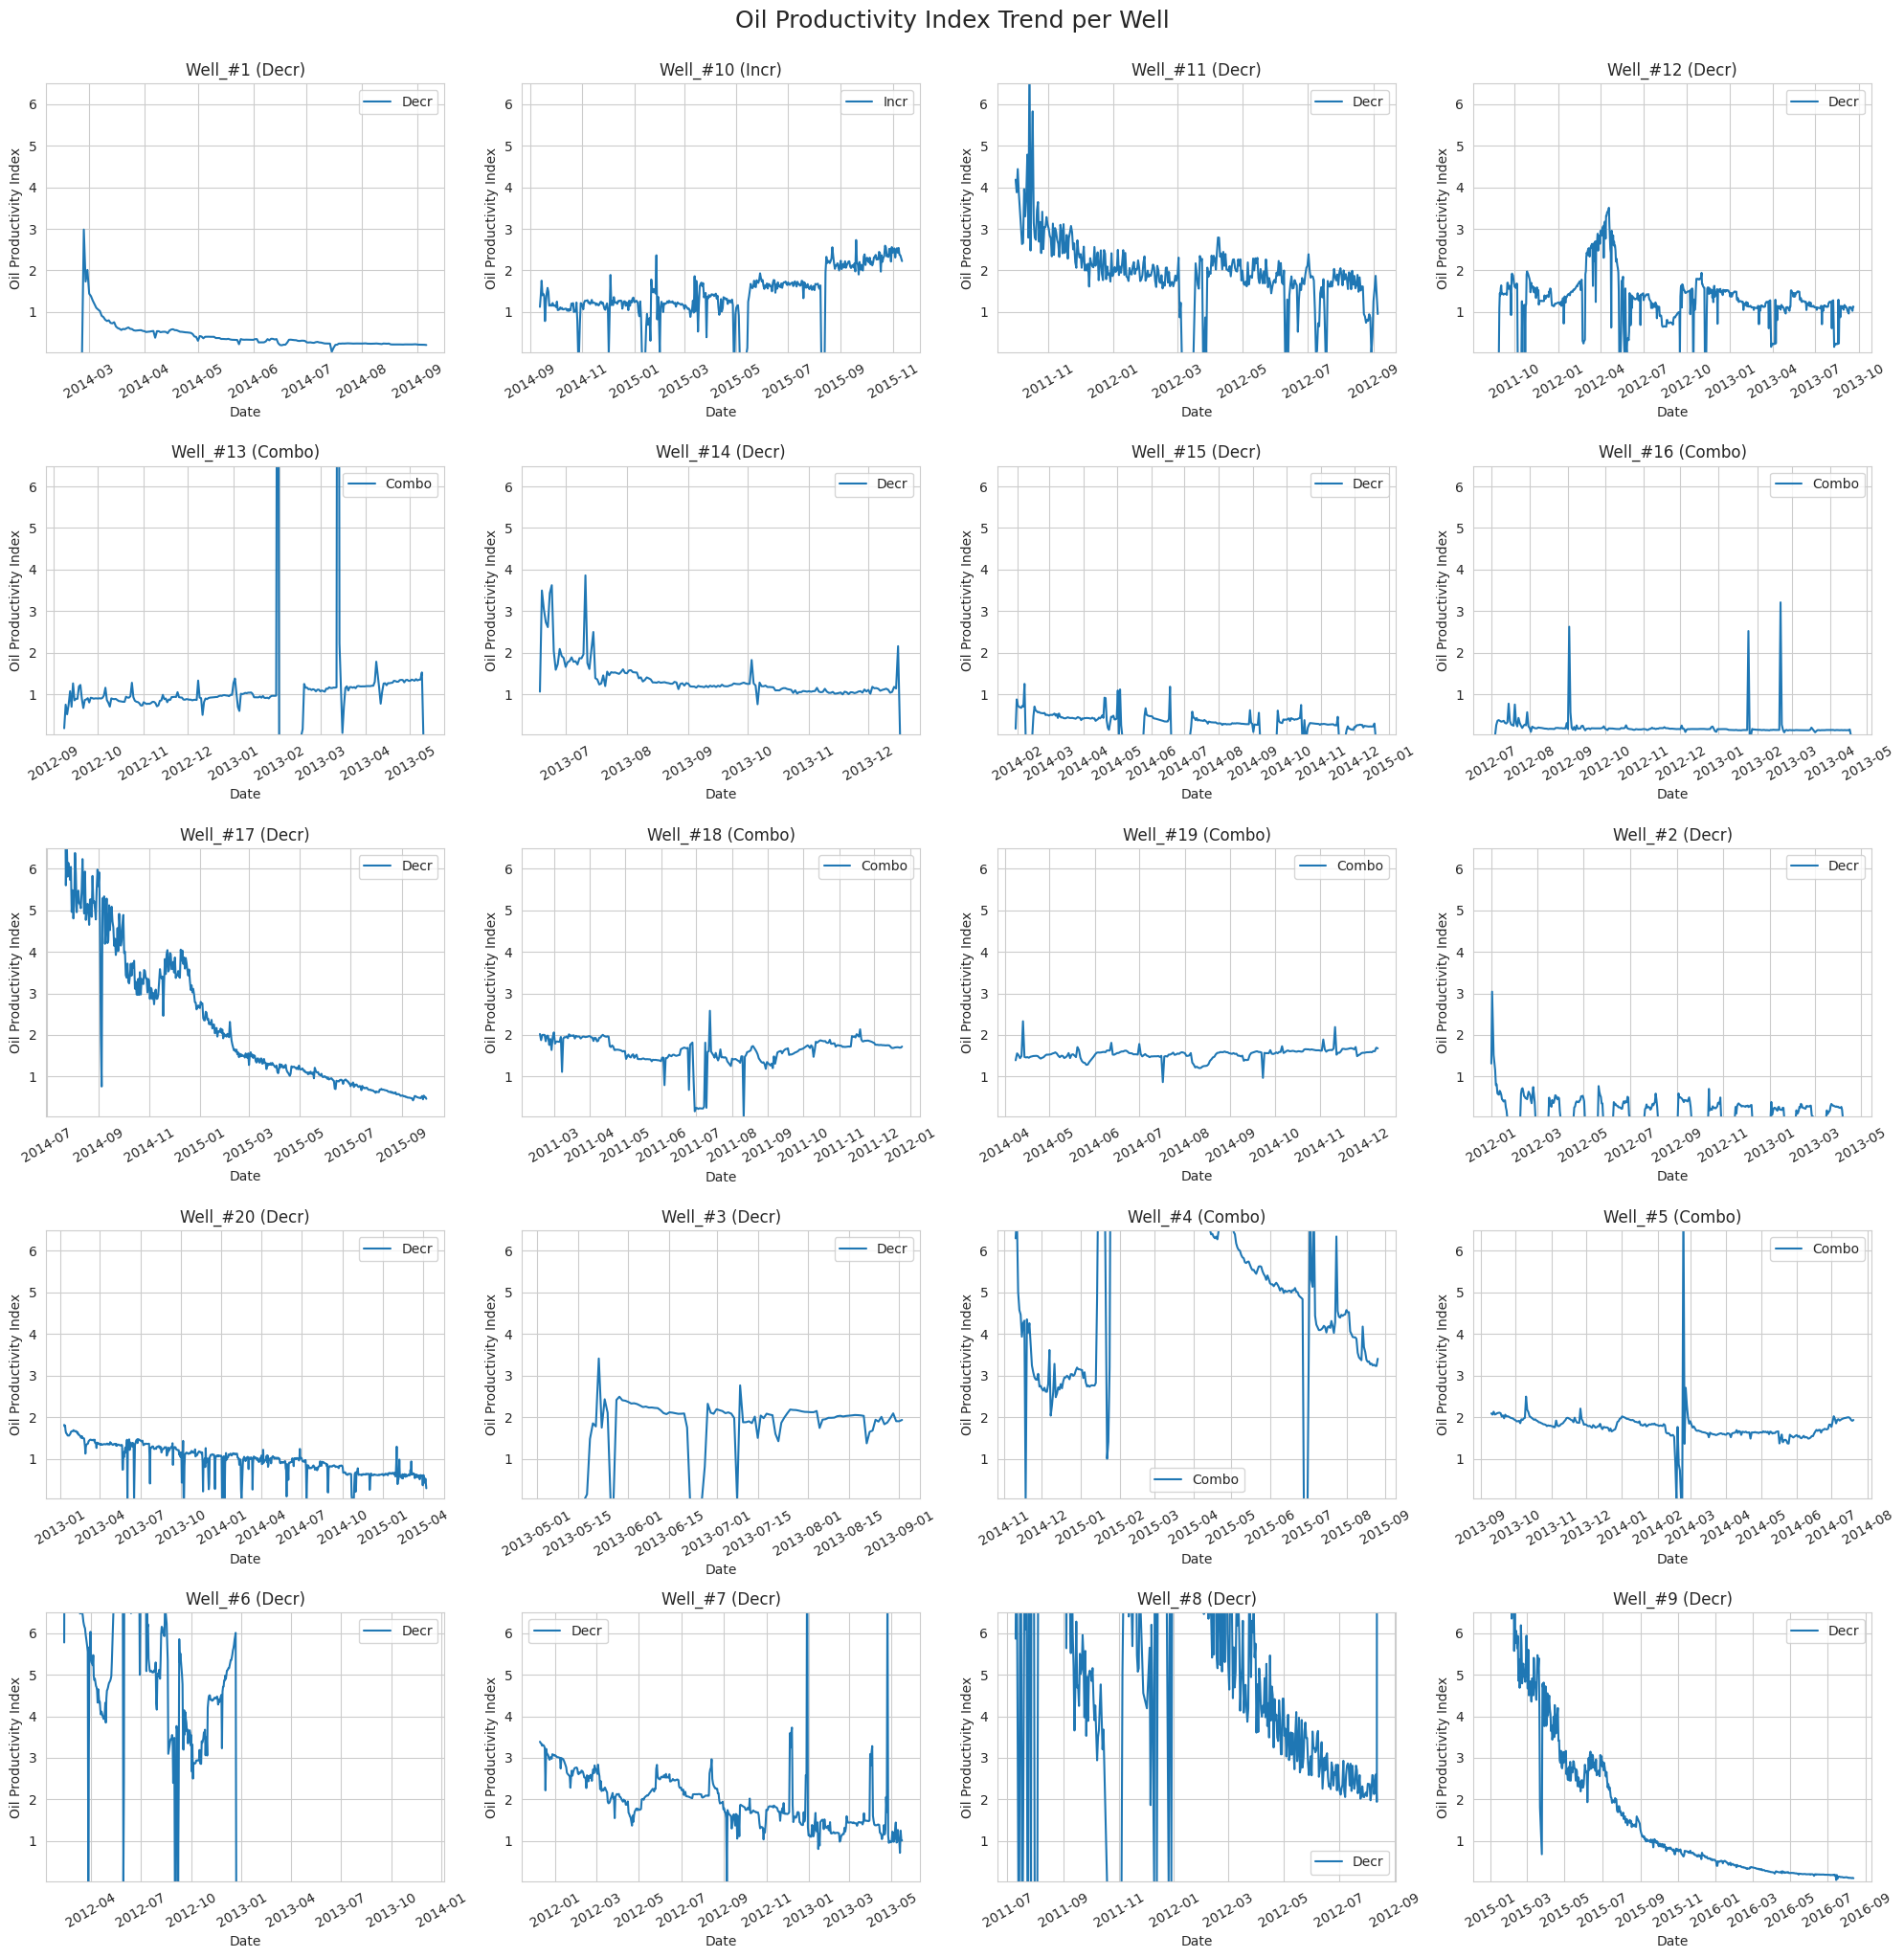

In [ ]:
well_trends = prod_df.groupby('WELL_NAME')['Oil Productivity Index Trend'].first().reset_index()

wells_to_plot = well_trends['WELL_NAME'].unique()
n_wells = len(wells_to_plot)
n_cols = 4
n_rows = (n_wells + n_cols - 1) // n_cols

# Compute more informative y-axis limits using percentiles (ignore 0 and NaNs)
valid_pi = prod_df['Oil Productivity Index'].replace(0, np.nan).dropna()
ymin = valid_pi.min()
ymax = np.percentile(valid_pi, 95)  # clip extreme highs because they affect the y-scale of our plot

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, well in enumerate(wells_to_plot, 1):
    well_data = prod_df[prod_df['WELL_NAME'] == well]
    trend = well_data['Oil Productivity Index Trend'].iloc[0]

    plt.subplot(n_rows, n_cols, i)
    sns.lineplot(data=well_data, x='PROD_DATE', y='Oil Productivity Index', label=trend)
    plt.title(f"{well} ({trend})")
    plt.xlabel('Date')
    plt.ylabel('Oil Productivity Index')
    plt.ylim(ymin, ymax)
    plt.xticks(rotation=30)

plt.tight_layout()
plt.suptitle("Oil Productivity Index Trend per Well", fontsize=18, y=1.02)
plt.show()


In [ ]:
prod_df.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX RESERVOIR  P_INIT  P_BUBBLE   P_AVG  SOL_GOR  \
0               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
1               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
2               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
3               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   
4               0.0    4096.0      JANI  4500.0    4300.0  4200.0   1000.0   

    BO  Reservoir Type Well Type Production Type      MONTH  Formation_GOR  \
0  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
1  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
2  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
3  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   
4  1.3  Undersaturated        NF        Unsteady 2014-02-01            0.0   

  Formation GOR Trend  Watercut Watercut Trend   Qo  Pressure_drawdown  \
0             bSolGOR       0.0           Incr  0.0              150.0   
1             bSolGOR       0.0           Incr  0.0              239.0   
2             bSolGOR       0.0           Incr  0.0              239.0   
3             bSolGOR       0.0           Incr  0.0              236.0   
4             bSolGOR       0.0           Incr  0.0              235.0   

   Oil Productivity Index Oil Productivity Index Trend  
0                     0.0                         Decr  
1               

# Total Reservoir Oil Production

* For each unique RESERVOIR, we group by WELL_NAME.
* For each well, we pick the last recorded CUMULATIVE_OIL_PROD (STB), which is equivalent to the sum of oil production for that well.
* We multiply this value by the formation volume factor BO (a constant per reservoir).
* Finally, we sum across all wells in that reservoir.

In [ ]:
# We want to ensure dates are sorted so the last cumulative production is the latest
prod_df_sorted = prod_df.sort_values(by=['WELL_NAME', 'PROD_DATE'])

# We get the last cumulative oil production per well
last_cum_prod = prod_df_sorted.groupby(['RESERVOIR', 'WELL_NAME']).last().reset_index()

# Calculate the oil in reservoir barrels (RB) for each well
last_cum_prod['Reservoir_Oil_RB'] = last_cum_prod['CUMULATIVE_OIL_PROD (STB)'] * last_cum_prod['BO']

# Sum reservoir oil per reservoir
reservoir_summary = (
    last_cum_prod
    .groupby('RESERVOIR')['Reservoir_Oil_RB']
    .sum()
    .reset_index()
    .rename(columns={'Reservoir_Oil_RB': 'Total_Reservoir_Oil_RB'})
)

# Display result
reservoir_summary.head()


RESERVOIR  Total_Reservoir_Oil_RB
0      ACHI              1500147.60
1      DEPU              1513123.90
2      JANI               594413.30
3      KEMA              1060802.60
4      MAKO              1110914.95

In [ ]:
reservoir_summary['Total_Reservoir_Oil_RB (MM)'] = reservoir_summary['Total_Reservoir_Oil_RB']/1e6
display(reservoir_summary)

RESERVOIR  Total_Reservoir_Oil_RB  Total_Reservoir_Oil_RB (MM)
0      ACHI              1500147.60                     1.500148
1      DEPU              1513123.90                     1.513124
2      JANI               594413.30                     0.594413
3      KEMA              1060802.60                     1.060803
4      MAKO              1110914.95                     1.110915

## Total Reservoir Oil Production Plot

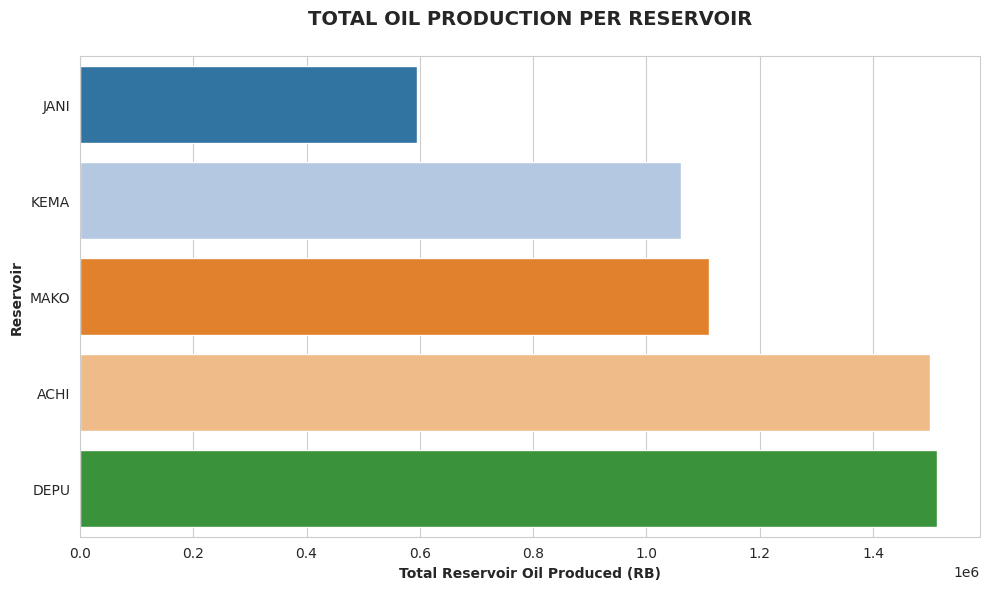

In [ ]:
reservoir_summary_sorted = reservoir_summary.sort_values("Total_Reservoir_Oil_RB", ascending=True)

palette = sns.color_palette("tab20", n_colors=len(reservoir_summary_sorted))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=reservoir_summary_sorted,
    x="Total_Reservoir_Oil_RB",
    y="RESERVOIR",
    palette=palette
)

plt.xlabel("Total Reservoir Oil Produced (RB)", fontweight='bold')
plt.ylabel("Reservoir", fontweight='bold')
plt.title("TOTAL OIL PRODUCTION PER RESERVOIR", fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


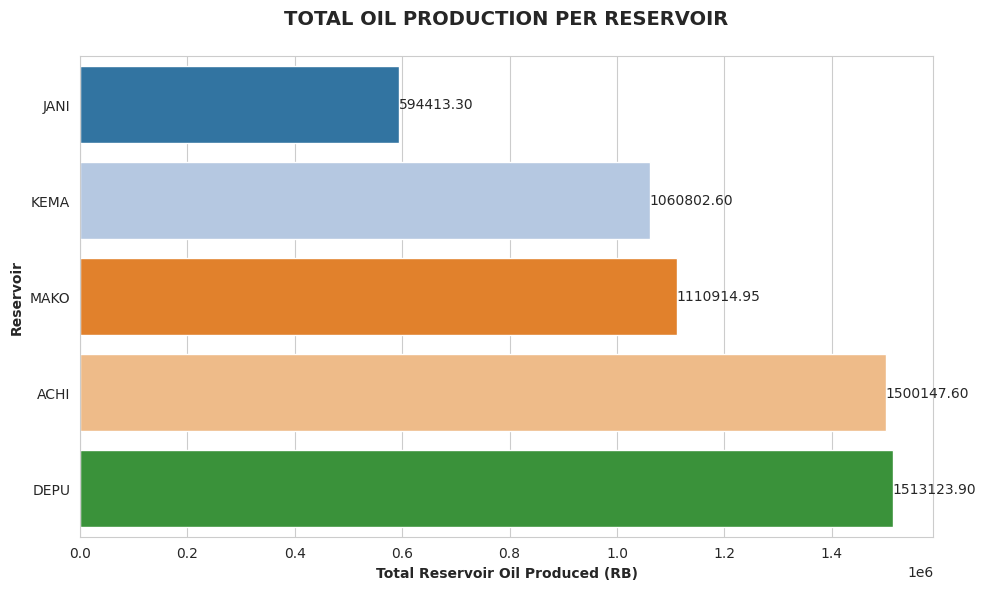

In [ ]:
reservoir_summary_sorted = reservoir_summary.sort_values("Total_Reservoir_Oil_RB", ascending=True)

palette = sns.color_palette("tab20", n_colors=len(reservoir_summary_sorted))

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=reservoir_summary_sorted,
    x="Total_Reservoir_Oil_RB",
    y="RESERVOIR",
    palette=palette
)

# Add the exact values next to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f') # Format the number to 2 decimal places

plt.xlabel("Total Reservoir Oil Produced (RB)", fontweight='bold')
plt.ylabel("Reservoir", fontweight='bold')
plt.title("TOTAL OIL PRODUCTION PER RESERVOIR", fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


# Final CSV File For Submission

In [ ]:
prod_df['WELL_NAME'].unique()

array(['Well_#1', 'Well_#10', 'Well_#11', 'Well_#12', 'Well_#13',
       'Well_#14', 'Well_#15', 'Well_#16', 'Well_#17', 'Well_#18',
       'Well_#19', 'Well_#2', 'Well_#20', 'Well_#3', 'Well_#4', 'Well_#5',
       'Well_#6', 'Well_#7', 'Well_#8', 'Well_#9'], dtype=object)

In [ ]:
# Extract numeric well number
prod_df['WELL_NAME'] = prod_df['WELL_NAME'].str.extract(r'#(\d+)').astype(int)

# Sort by WELL_NAME and PROD_DATE
prod_df_sorted = prod_df.sort_values(by=['WELL_NAME', 'PROD_DATE'])


# Rename columns
prod_df_sorted = prod_df_sorted.rename(columns={
    "WELL_NAME": "Well",
    "RESERVOIR": "Reservoir Name"
})

# Reset the index
prod_df_sorted = prod_df_sorted.reset_index(drop=True)


In [ ]:
prod_df_sorted.head()

PROD_DATE  Well  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15     1            0.0                             4050.0   
1 2014-02-16     1            0.0                             3961.0   
2 2014-02-17     1            0.0                             3961.0   
3 2014-02-18     1            0.0                             3964.0   
4 2014-02-19     1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

   CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   

   OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
0             0.0                   0.0                    0.0   
1             0.0                   0.0                    0.0   
2             0.0                   0.0                    0.0   
3             0.0                   0.0                    0.0   
4             0.0                   0.0                    0.0   

   WATER_PROD (BBL)  BHFP_MAX Reservoir Name  P_INIT  P_BUBBLE   P_AVG  \
0               0.0    4096.0           JANI  4500.0    4300.0  4200.0   
1               0.0    4096.0           JANI  4500.0    4300.0  4200.0   
2               0.0    4096.0           JANI  4500.0    4300.0  4200.0   
3               0.0    4096.0           JANI  4500.0    4300.0  4200.0   
4               0.0    4096.0           JANI  4500.0    4300.0  4200.0   

   SOL_GOR   BO  Reservoir Type Well Type Production Type      MONTH  \
0   1000.0  1.3  Undersaturated        NF        Unsteady 2014-02-01   
1   1000.0  1.3  Undersaturated        NF        Unsteady 2014-02-01   
2   1000.0  1.3  Undersaturated        NF        Unsteady 2014-02-01   
3   1000.0  1.3  Undersaturated        NF        Unsteady 2014-02-01   
4   1000.0  1.3  Undersaturated        NF        Unsteady 2014-02-01   

   Formation_GOR Formation GOR Trend  Watercut Watercut Trend   Qo  \
0            0.0             bSolGOR       0.0           Incr  0.0   
1            0.0             bSolGOR       0.0           Incr  0.0   
2            0.0             bSolGOR       0.0           Incr  0.0   
3            0.0             bSolGOR       0.0           Incr  0.0   
4            0.0             bSolGOR       0.0           Incr  0.0   

   Pressure_drawdown  Oil Productivity Index Oil Productivity Index Trend  
0              150.0                     0.0                         Decr  
1              239.0                     0.0                         Decr  
2         

In [ ]:
selected_columns = [
    'Well', 'Reservoir Name', 'Reservoir Type', 'Well Type',
    'Production Type', 'Formation GOR Trend',
    'Watercut Trend', 'Oil Productivity Index Trend'
]

# We group by 'Well' and take the first row from each group
sub_file = prod_df_sorted[selected_columns].groupby('Well', as_index=False).first()


sub_file = sub_file.sort_values(by=['Well']).reset_index(drop=True)
sub_file.head(20)


Well Reservoir Name  Reservoir Type Well Type Production Type  \
0      1           JANI  Undersaturated        NF        Unsteady   
1      2           KEMA  Undersaturated        NF        Unsteady   
2      3           MAKO       Saturated        NF        Unsteady   
3      4           DEPU       Saturated        GL          Steady   
4      5           MAKO       Saturated        NF        Unsteady   
5      6           KEMA  Undersaturated        NF        Unsteady   
6      7           KEMA  Undersaturated        GL        Unsteady   
7      8           ACHI  Undersaturated        GL        Unsteady   
8      9           DEPU       Saturated        GL        Unsteady   
9     10           JANI  Undersaturated        GL        Unsteady   
10    11           ACHI  Undersaturated        GL        Unsteady   
11    12           ACHI  Undersaturated        NF          Steady   
12    13           DEPU       Saturated        NF        Unsteady   
13    14           MAKO       Saturated        NF        Unsteady   
14    15           JANI  Undersaturated        NF        Unsteady   
15    16           KEMA  Undersaturated        NF          Steady   
16    17           DEPU       Saturated        GL          Steady   
17    18           ACHI  Undersaturated        NF          Steady   
18    19           JANI  Undersaturated        NF        Unsteady   
19    20           MAKO       Saturated        GL        Unsteady   

   Formation GOR Trend Watercut Trend Oil Productivity Index Trend  
0              bSolGOR           Incr                         Decr  
1              bSolGOR           Incr                         Decr  
2                Combo           Flat                         Decr  
3              bSolGOR          Combo                        Combo  
4                Combo          Combo                        Combo  
5                Combo           Decr                         Decr  
6                Combo          Combo                         Decr  
7                Combo           Incr                         Decr  
8              bSolGOR           Incr                         Decr  
9                Combo           Flat                         Incr  
10               Combo           Incr                         Decr  
11             bSolGOR          Combo                         Decr  
12               Combo           Flat                        Combo  
13             bSolGOR           Flat                         Decr  
14               Combo           Incr                         Decr  
15               Combo           Flat                        Combo  
16             bSolGOR          Combo                         Decr  
17               Combo           Incr                        Combo  
18             bSolGOR           Incr                        Combo  
19               Combo           Incr                         Decr

In [ ]:
sub_file.to_csv("PetroPulse_DSEATS_Africa_2025_Classification.csv", index=False)

In [ ]:
# Saving the completely classified data for futher analysis
# prod_df_sorted.to_csv("FA_data.csv", index=False)

# Model Development

In [ ]:
!pip install pytorch_tabnet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
prod_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   PROD_DATE                             7955 non-null   datetime64[ns]
 1   Well                                  7955 non-null   int64         
 2   ON_STREAM_HRS                         7955 non-null   float64       
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   float64       
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64       
 5   ANNULUS_PRESS (PSI)                   7955 non-null   float64       
 6   CHOKE_SIZE (%)                        7955 non-null   float64       
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   float64       
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64       
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   float64       
 10  

In [ ]:
ml_data = prod_df_sorted.copy()

# Define categorical target variables
target_columns = ['Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR Trend',
                 'Watercut Trend', 'Oil Productivity Index Trend']

# Separate features and targets
X = ml_data.drop(target_columns, axis=1)
y = ml_data[target_columns]

# Convert categorical features to numeric using LabelEncoder
for column in target_columns:
    le = LabelEncoder()
    y[column] = le.fit_transform(y[column])

# Handle numerical columns (excluding datetime)
numeric_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64'] and col != 'PROD_DATE' and col != 'MONTH']
X_numeric = X[numeric_columns]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert scaled features back to DataFrame
X_processed = pd.DataFrame(X_scaled, columns=numeric_columns, index=X.index)

#Removing columns closely associated with the target variables and datetime
X_processed.drop(columns = ['Oil Productivity Index', 'Watercut', 'Formation_GOR'], axis=1, inplace = True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [ ]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Well                                  7955 non-null   float64
 1   ON_STREAM_HRS                         7955 non-null   float64
 2   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   float64
 3   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 4   ANNULUS_PRESS (PSI)                   7955 non-null   float64
 5   CHOKE_SIZE (%)                        7955 non-null   float64
 6   WELL_HEAD_PRESSURE (PSI)              7955 non-null   float64
 7   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 8   CUMULATIVE_OIL_PROD (STB)             7955 non-null   float64
 9   CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   float64
 10  CUMULATIVE_TOTAL_GAS_PROD (MSCF)      7955 non-null   float64
 11  CUMULATIVE_WATER_

In [ ]:
X_train.head()

Well  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
2420 -0.696317       0.361863                           1.239443   
4309  0.013405      -0.454288                          -0.318245   
4353  0.190835       0.361863                          -0.588768   
1039 -1.228608      -0.591328                          -0.539318   
3038 -0.341456       0.361863                          -0.532045   

      DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
2420                      1.063598             1.109098       -0.116835   
4309                     -0.949951             0.750877       -0.580157   
4353                     -0.370551            -0.978679       -0.681835   
1039                     -0.661066            -0.370643       -1.372972   
3038                     -0.386656             1.181792       -0.588487   

      WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
2420                  0.338520                       0.391985   
4309                 -0.080475                      -0.412248   
4353                 -0.251263                      -0.434371   
1039                  2.783482                      -0.573966   
3038                 -0.296997                      -0.238568   

      CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
2420                   1.752613                              1.213542   
4309                  -0.040360                              0.238447   
4353                  -0.913327                             -0.790133   
1039                   0.879939                              1.548711   
3038                  -0.670956                             -0.546055   

      CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  \
2420                          1.780749                     3.166446   
4309                          0.312423                    -0.330517   
4353                         -0.870333                    -0.642128   
1039                          2.005475                     0.185142   
3038                         -0.540697                    -0.476072   

      OIL_PROD (STB)  FORM_GAS_PROD (MSCF)  TOTAL_GAS_PROD (MSCF)  \
2420        0.034374             -0.086043               0.074662   
4309       -0.661758             -0.467773              -0.504462   
4353        0.093480             -0.126498              -0.249023   
1039       -0.343902             -0.006170               0.157534   
3038       -0.006343             -0.026916               0.123410   

      WATER_PROD (BBL)  BHFP_MAX    P_INIT  P_BUBBLE     P_AVG   SOL_GOR  \
2420          3.394986  1.070567  0.889391  0.859602  1.004778 -0.813351   
4309         -0.644633 -0.875897 -0.323851 -0.514819 -0.763587 -0.019461   
4353         -0.785509 -0.821995 -0.323851 -0.514819 -0.763587 -0.019461   
1039          0.035094 -1.146905 -1.537092 -1.496548 -1.205678  1.568321   
3038          0.056225 -1.157386 -1.537092 -1.496548 -1.205678  1.568321   

            BO        Qo  Pressure_drawdown  
2420  1.317131 -0.002395          -0.426676  
4309 -0.890111 -0.546753          -0.749777  
4353 -0.890111  0.049608          -0.283910  
1039  0.610814 -0.152932          -1.120467  
3038  0.610814 -0.038219          -1.132990

In [ ]:
# Initialize models for each target variable
rf_models = {}
xgb_models = {}
stacking_models = {}
tabnet_models = {}

# Define base estimators for Stacking
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))

# TabNet model
tabnet_model = TabNetClassifier(verbose=0, seed=42)

In [ ]:
# Fit models for each target variable
for target in target_columns:
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train[target])
    rf_models[target] = rf

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train[target])
    xgb_models[target] = xgb

    # Stacking
    stacking_clf.fit(X_train, y_train[target])
    stacking_models[target] = stacking_clf

    # TabNet
    tabnet_model.fit(X_train.values, y_train[target].values)
    tabnet_models[target] = tabnet_model

In [ ]:
# Function to predict all targets for a given model dictionary
def predict_all_targets(models, X):
    predictions = {}
    for target in target_columns:
        if isinstance(models[target], TabNetClassifier):
            X_array = np.asarray(X).astype(np.float32)
            predictions[target] = models[target].predict(X_array)
        else:
            predictions[target] = models[target].predict(X)
    return predictions

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Generate predictions for X_test
rf_predictions = predict_all_targets(rf_models, X_test)
xgb_predictions = predict_all_targets(xgb_models, X_test)
stacking_predictions = predict_all_targets(stacking_models, X_test)
tabnet_predictions = predict_all_targets(tabnet_models, X_test)

In [ ]:
# Function to evaluate all metrics for a given model and target
def evaluate_model(y_true, y_pred, target_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    return pd.DataFrame(metrics, index=[target_name])

In [ ]:
# Evaluate all models for each target variable
results = {}

for target in target_columns:
    # Get predictions for each model
    rf_pred = rf_predictions[target]
    xgb_pred = xgb_predictions[target]
    stacking_pred = stacking_predictions[target]
    tabnet_pred = tabnet_predictions[target]

    # True labels from test set
    y_true = y_test[target].values

    # Evaluate Random Forest
    rf_df = evaluate_model(y_true, rf_pred, f"{target} (RF)")
    # Evaluate XGBoost
    xgb_df = evaluate_model(y_true, xgb_pred, f"{target} (XGB)")
    # Evaluate Stacking
    stacking_df = evaluate_model(y_true, stacking_pred, f"{target} (Stacking)")
    # Evaluate TabNet
    tabnet_df = evaluate_model(y_true, tabnet_pred, f"{target} (TabNet)")

    # Combine results for this target
    results[target] = pd.concat([rf_df, xgb_df, stacking_df, tabnet_df])

In [ ]:
for target, df in results.items():
    print(f"\nEvaluation Results for {target}:")
    print(df)


Evaluation Results for Reservoir Type:
                           Accuracy  Precision    Recall  F1 Score
Reservoir Type (RF)        1.000000   1.000000  1.000000  1.000000
Reservoir Type (XGB)       1.000000   1.000000  1.000000  1.000000
Reservoir Type (Stacking)  0.565053   0.571515  0.565053  0.551404
Reservoir Type (TabNet)    0.565053   0.571515  0.565053  0.551404

Evaluation Results for Well Type:
                      Accuracy  Precision    Recall  F1 Score
Well Type (RF)        1.000000   1.000000  1.000000  1.000000
Well Type (XGB)       0.999371   0.999372  0.999371  0.999371
Well Type (Stacking)  0.360779   0.303885  0.360779  0.312789
Well Type (TabNet)    0.360779   0.303885  0.360779  0.312789

Evaluation Results for Production Type:
                            Accuracy  Precision    Recall  F1 Score
Production Type (RF)        1.000000    1.00000  1.000000  1.000000
Production Type (XGB)       1.000000    1.00000  1.000000  1.000000
Production Type (Stacking)  0.71338

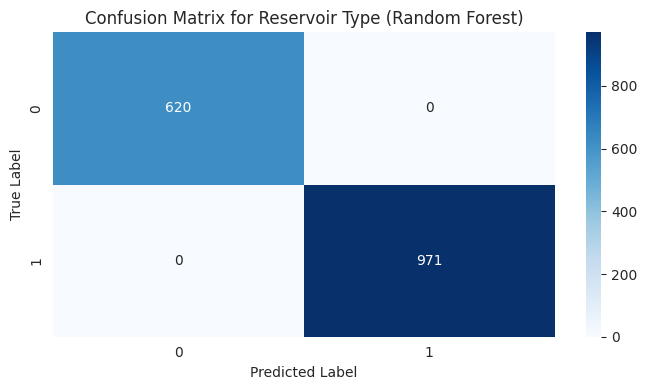

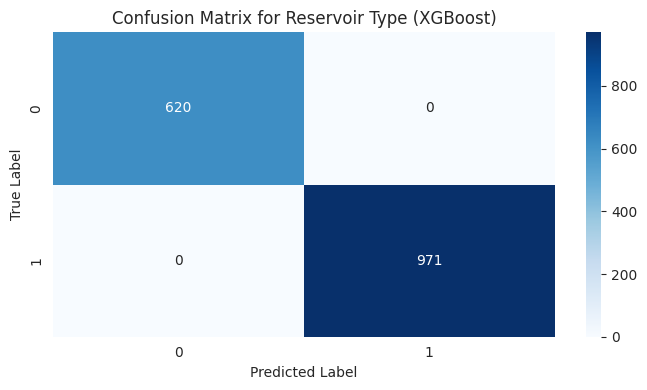

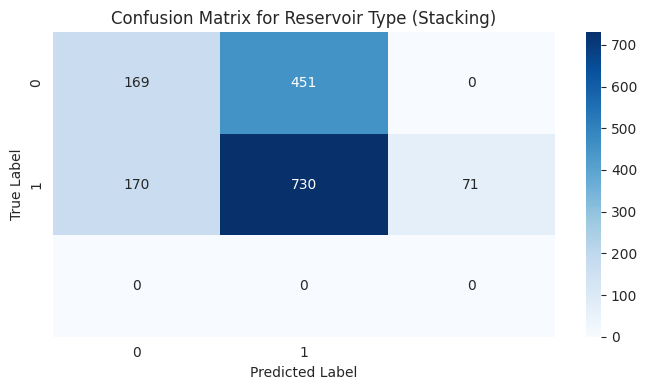

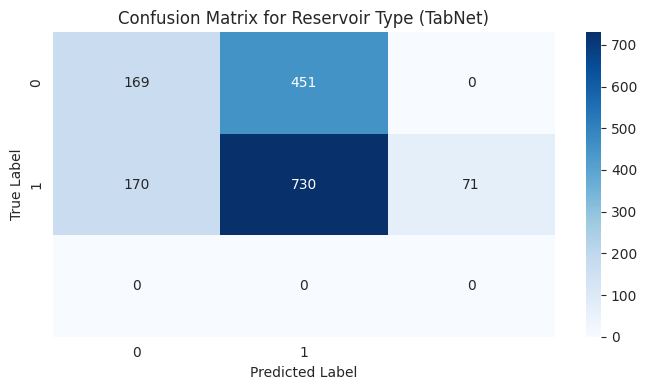

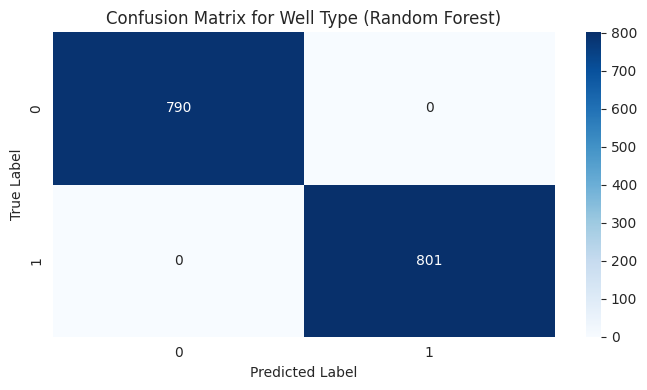

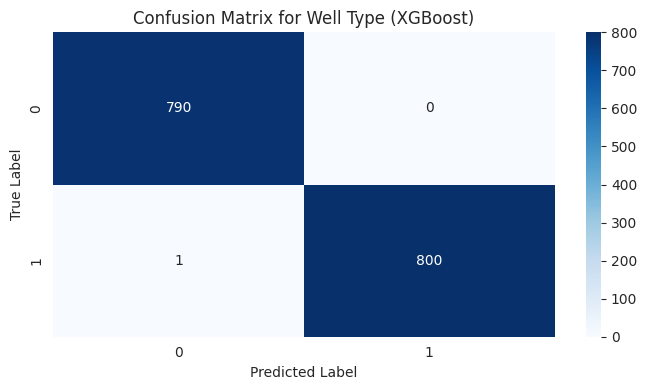

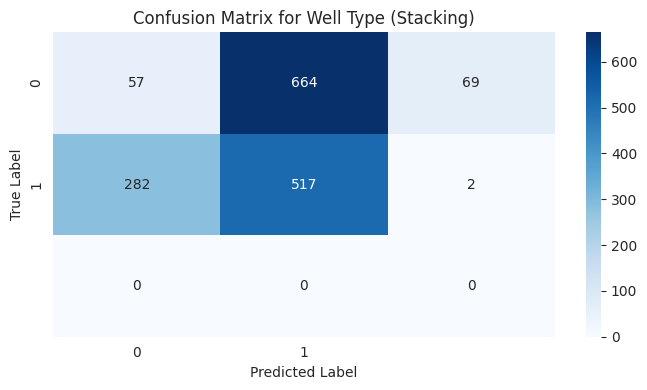

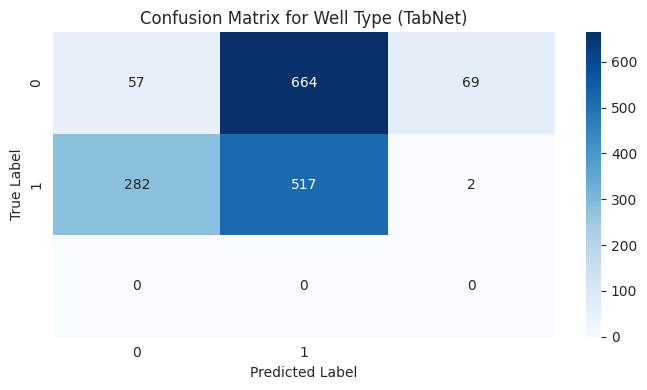

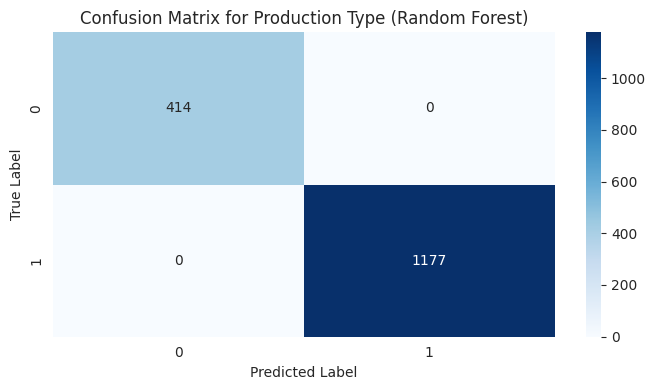

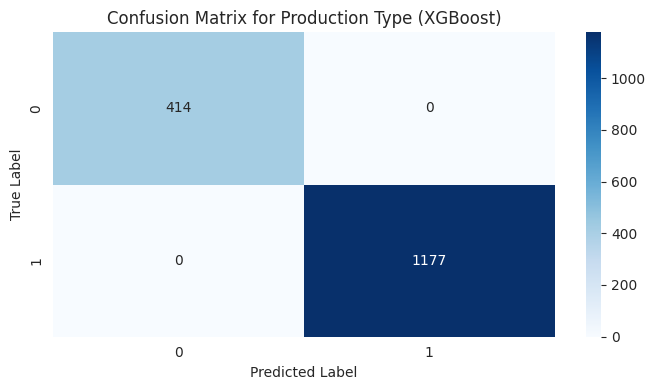

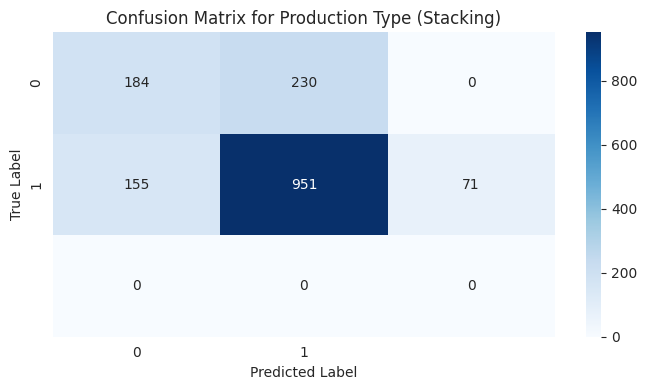

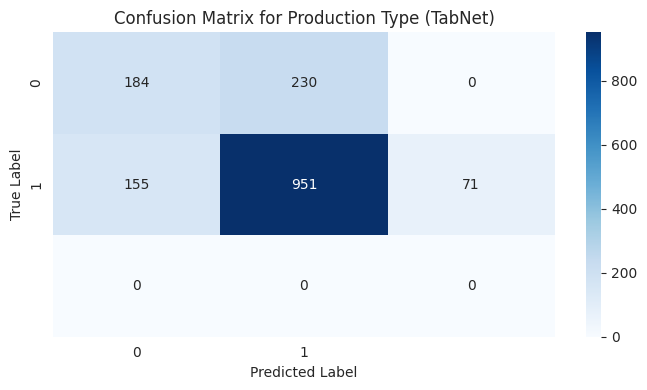

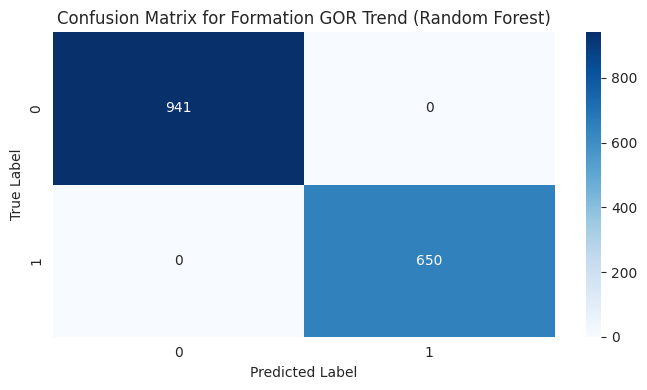

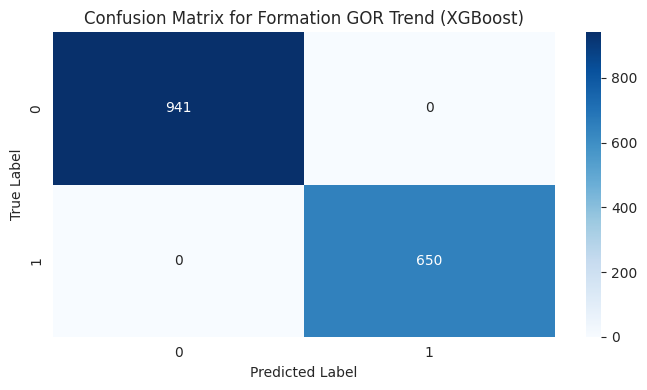

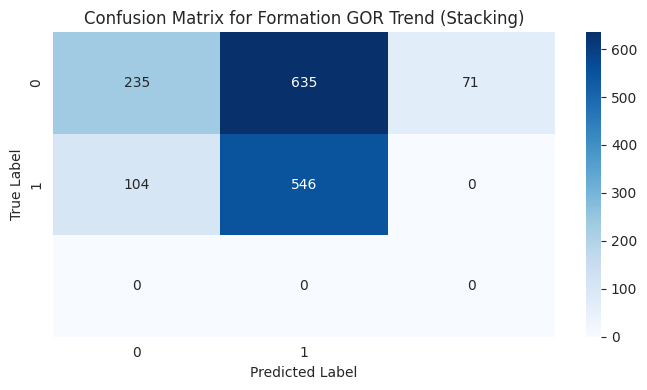

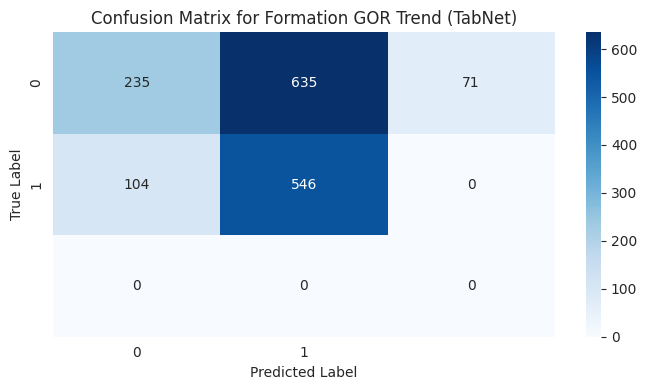

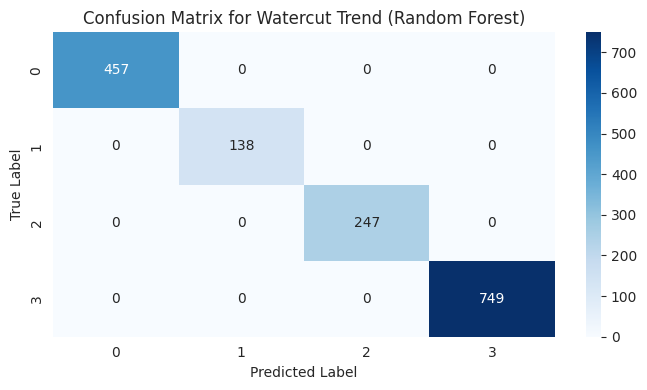

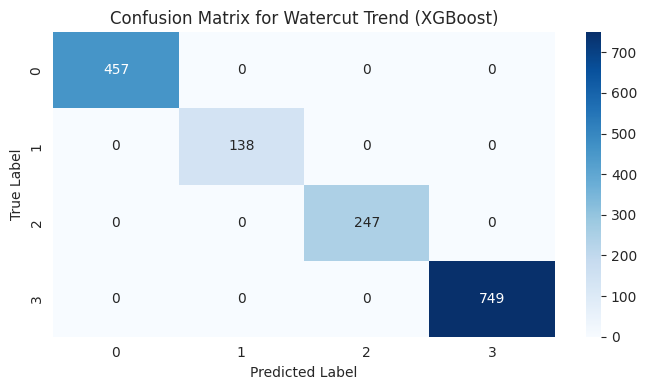

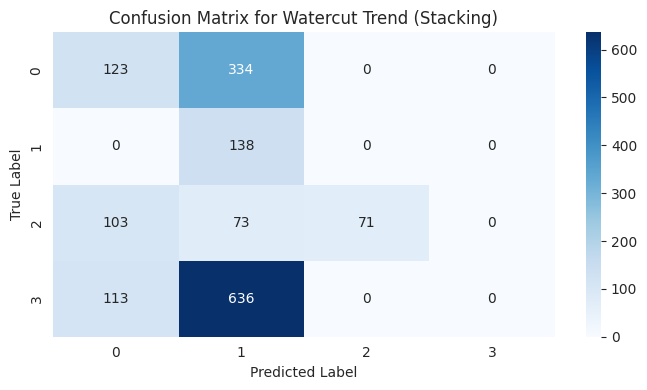

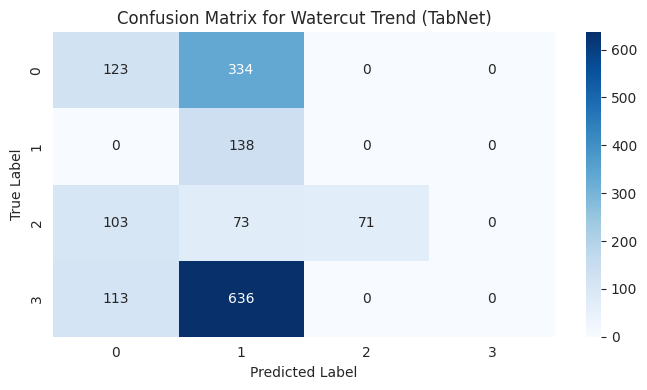

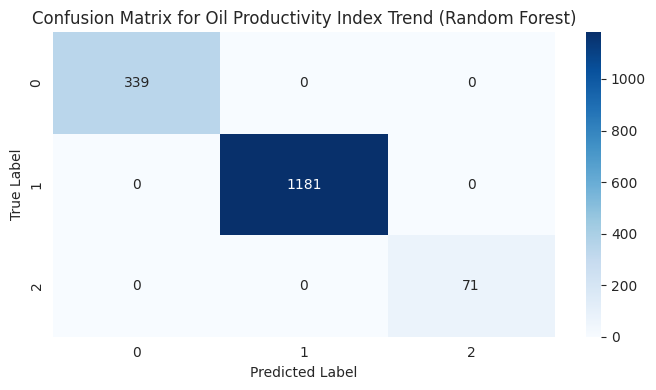

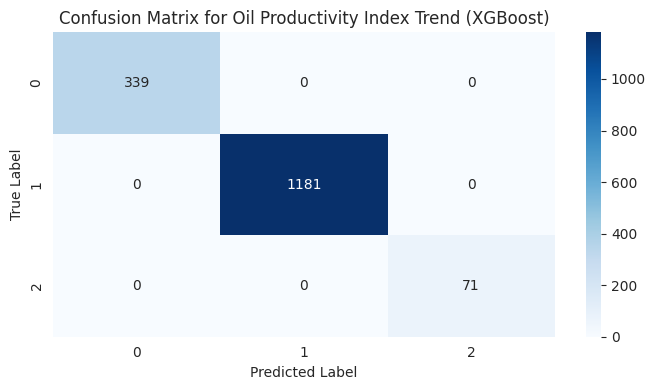

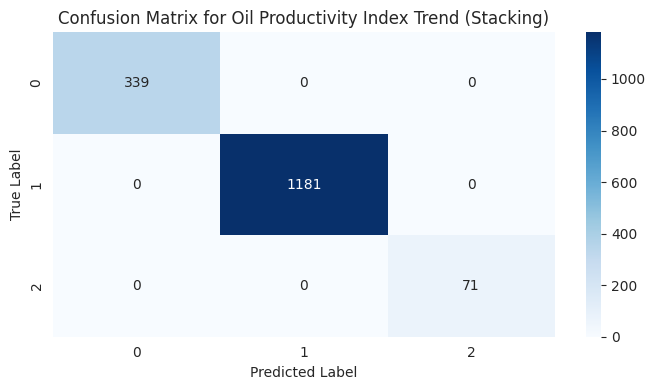

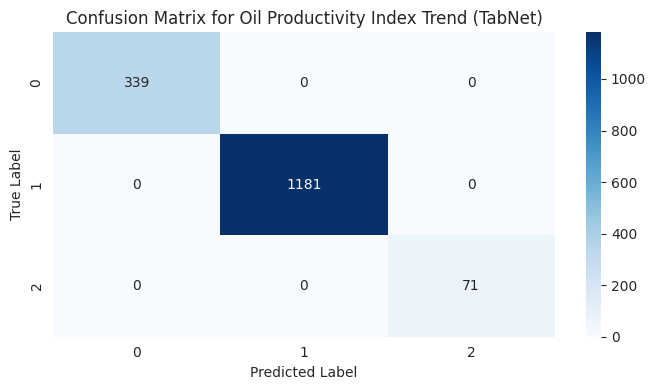

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Function to plot confusion matrix for a given target and model
def plot_confusion_matrix(y_true, y_pred, target_name, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Get unique class labels
    classes = np.unique(y_true)

    # Create figure
    plt.figure(figsize=(7, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {target_name} ({model_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for each model and target using precomputed predictions
for target in target_columns:
    try:
        # True labels
        y_true = y_test[target].values

        # Random Forest
        rf_pred = rf_predictions[target]
        plot_confusion_matrix(y_true, rf_pred, target, "Random Forest")

        # XGBoost
        xgb_pred = xgb_predictions[target]
        plot_confusion_matrix(y_true, xgb_pred, target, "XGBoost")

        # Stacking
        stacking_pred = stacking_predictions[target]
        plot_confusion_matrix(y_true, stacking_pred, target, "Stacking")

        # TabNet
        tabnet_pred = tabnet_predictions[target]
        plot_confusion_matrix(y_true, tabnet_pred, target, "TabNet")

    except Exception as e:
        print(f"Error plotting confusion matrix for {target} with some model: {str(e)}")
        continue

### Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Function to plot feature importance for a given target
def plot_feature_importance(model, feature_names, target_name):
    # Get feature importance
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {target_name}')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.tight_layout()
    plt.show()

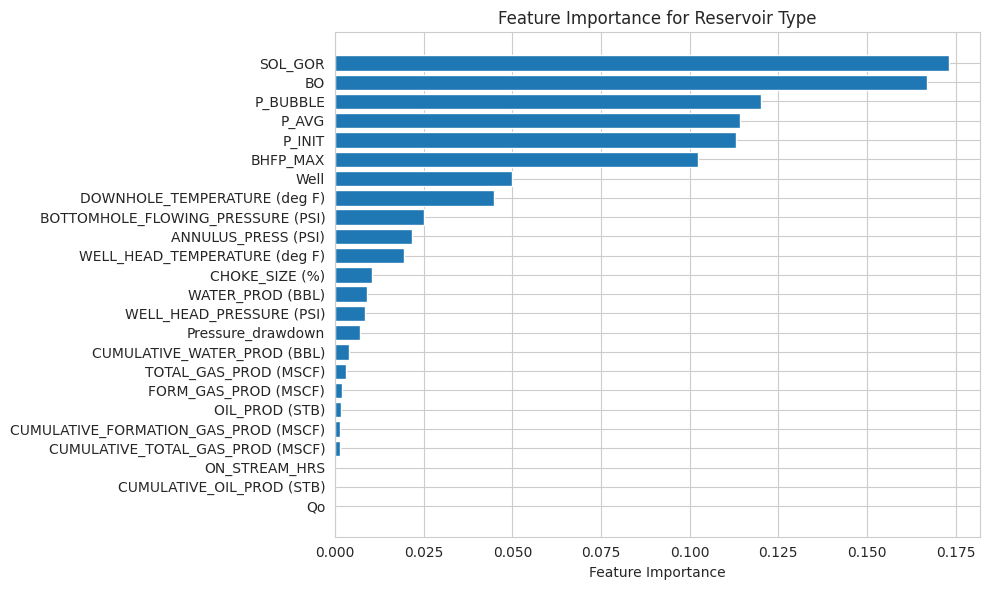

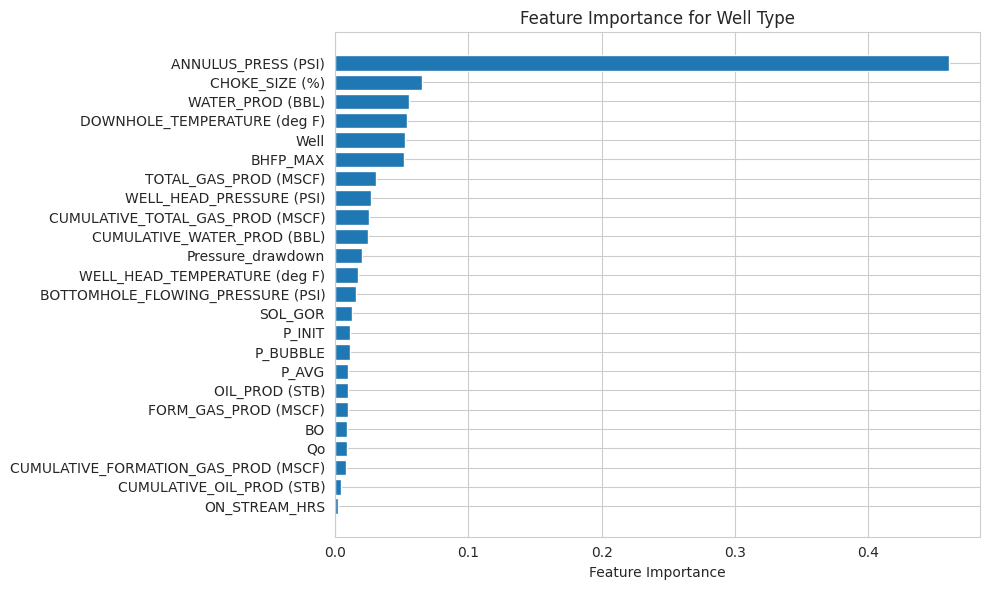

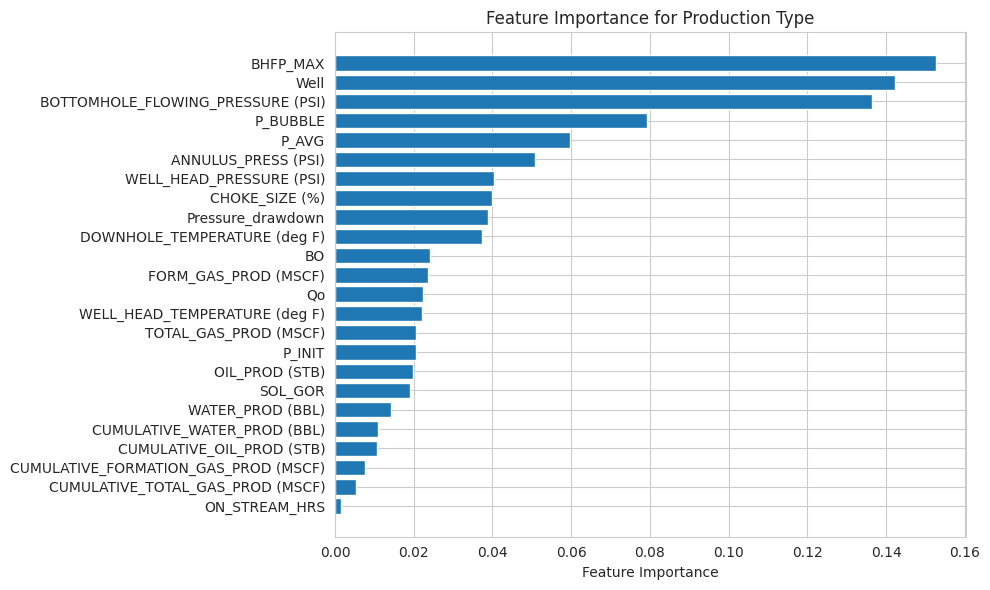

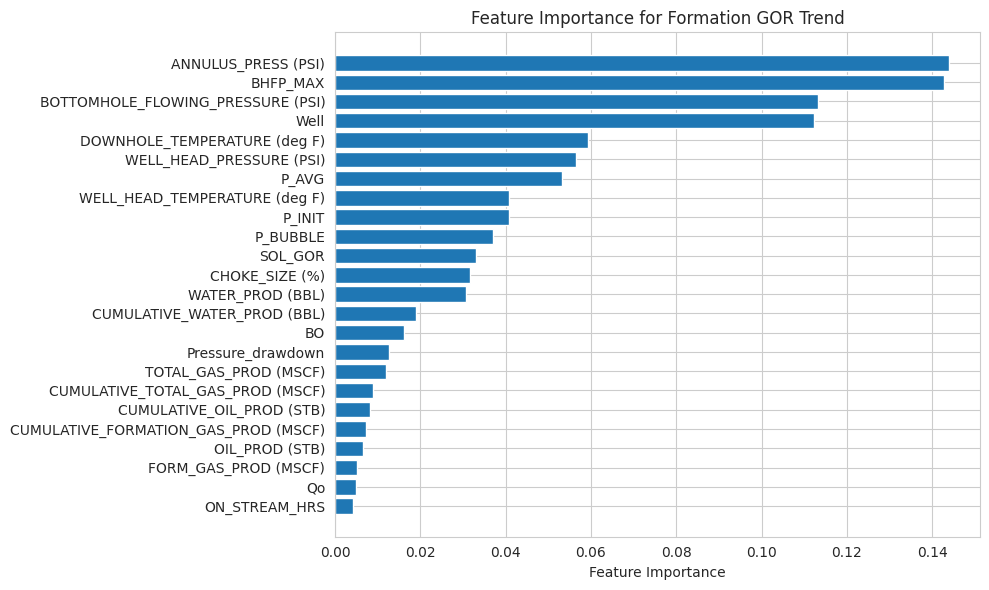

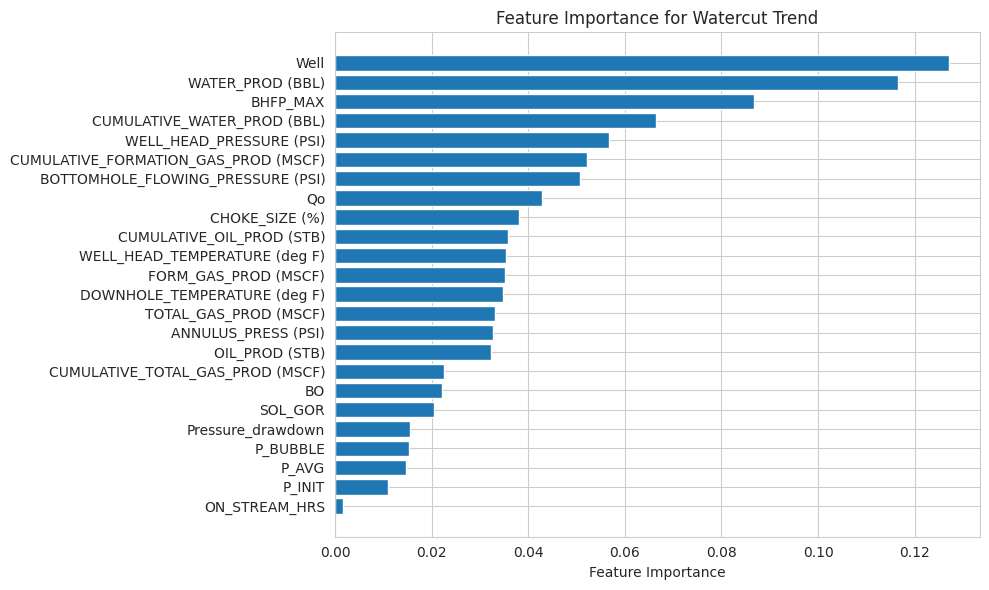

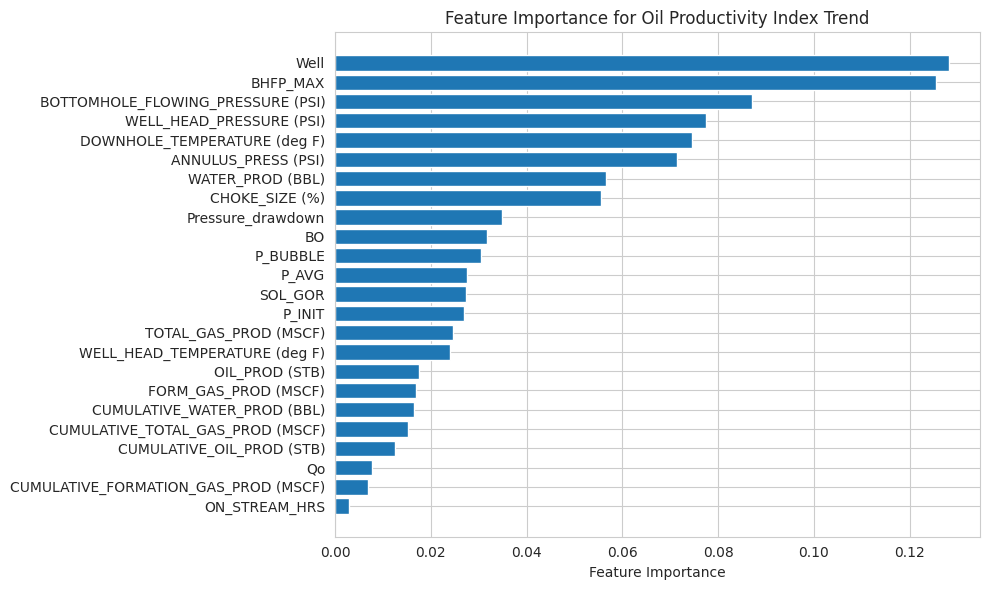

In [ ]:
feature_names = X_processed.columns

# Plot feature importance for each target variable
for target in target_columns:
    plot_feature_importance(rf_models[target], feature_names, target)

## Experimentation - TabTransformer

In [ ]:
!pip install pytorch-tabular torch tensorboard

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
import torch.serialization
from omegaconf import DictConfig  # Import DictConfig

In [ ]:
# Helper function for evaluation
def evaluate_model(y_true, y_pred, target_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    return pd.DataFrame(metrics, index=[target_name])

In [ ]:
# Initialize TabTransformer models for each target
tabtransformer_models = {}
for target in target_columns:
    # Define DataConfig specific to the current target
    data_config = DataConfig(
        target=[target],  # Use only the current target
        continuous_cols=X_train.columns.tolist(),
        continuous_feature_transform="quantile_normal",
        normalize_continuous_features=True
    )
    trainer_config = TrainerConfig(
        batch_size=64,
        max_epochs=50,
        accelerator="auto",
        checkpoints=None  # Disable checkpointing to avoid the issue
    )
    optimizer_config = OptimizerConfig()

    model_config = TabTransformerConfig(
        task="classification",
        metrics=["accuracy"],
        metrics_params=[{}]
    )

    # Convert to DataFrame for TabularModel with the current target
    train_df = pd.DataFrame(X_train, columns=X_train.columns)
    train_df[target] = y_train[target]
    test_df = pd.DataFrame(X_test, columns=X_test.columns)
    test_df[target] = y_test[target]

    # Use context manager with explicit safe globals
    with torch.serialization.safe_globals([DictConfig]):  # Allow DictConfig as a safe global
        # Train model
        tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config
        )
        tabular_model.fit(train=train_df)
        tabtransformer_models[target] = tabular_model

INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     50 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     50 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     50 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     50 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │    100 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     75 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 119                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed


In [ ]:
# Evaluate and store results
tabtransformer_results = {}
for target in target_columns:
    print(f"Evaluating model for target: {target}")
    try:
        test_df = pd.DataFrame(X_test, columns=X_test.columns)
        test_df[target] = y_test[target]  # Ensure target is included for prediction
        pred_df = tabtransformer_models[target].predict(test_df)
        y_true = y_test[target].values
        y_pred = pred_df[f'{target}_prediction'].values
        tabtransformer_results[target] = evaluate_model(y_true, y_pred, f"{target} (TabTransformer)")
        print(f"Completed evaluation for {target}")
    except Exception as e:
        print(f"Error evaluating model for {target}: {str(e)}")
        continue

Evaluating model for target: Reservoir Type
Completed evaluation for Reservoir Type
Evaluating model for target: Well Type
Completed evaluation for Well Type
Evaluating model for target: Production Type
Completed evaluation for Production Type
Evaluating model for target: Formation GOR Trend
Completed evaluation for Formation GOR Trend
Evaluating model for target: Watercut Trend
Completed evaluation for Watercut Trend
Evaluating model for target: Oil Productivity Index Trend
Completed evaluation for Oil Productivity Index Trend


In [ ]:
# Print results
for target, df in tabtransformer_results.items():
    print(f"\nEvaluation Results for {target}:")
    print(df)


Evaluation Results for Reservoir Type:
                                 Accuracy  Precision    Recall  F1 Score
Reservoir Type (TabTransformer)  0.998743   0.998746  0.998743  0.998743

Evaluation Results for Well Type:
                            Accuracy  Precision    Recall  F1 Score
Well Type (TabTransformer)  0.992458   0.992485  0.992458  0.992457

Evaluation Results for Production Type:
                                  Accuracy  Precision    Recall  F1 Score
Production Type (TabTransformer)  0.946574   0.947136  0.946574  0.946799

Evaluation Results for Formation GOR Trend:
                                      Accuracy  Precision    Recall  F1 Score
Formation GOR Trend (TabTransformer)  0.921433   0.922781  0.921433  0.921704

Evaluation Results for Watercut Trend:
                                 Accuracy  Precision    Recall  F1 Score
Watercut Trend (TabTransformer)  0.868008   0.867749  0.868008  0.867672

Evaluation Results for Oil Productivity Index Trend:
             

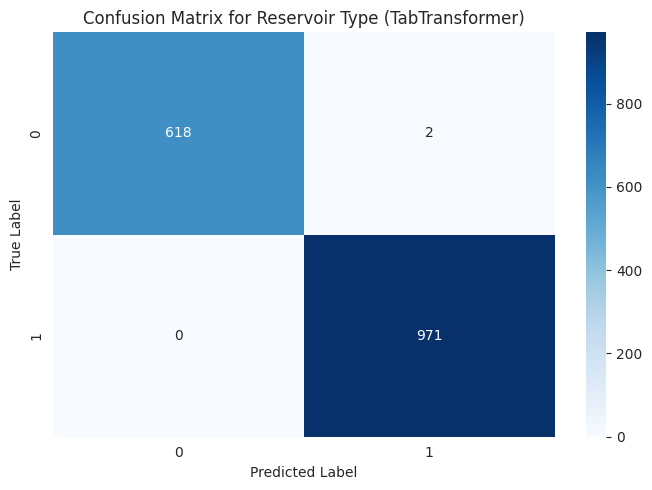

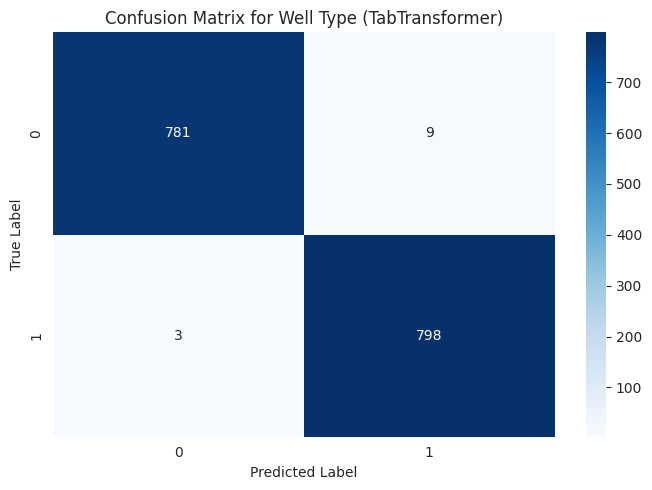

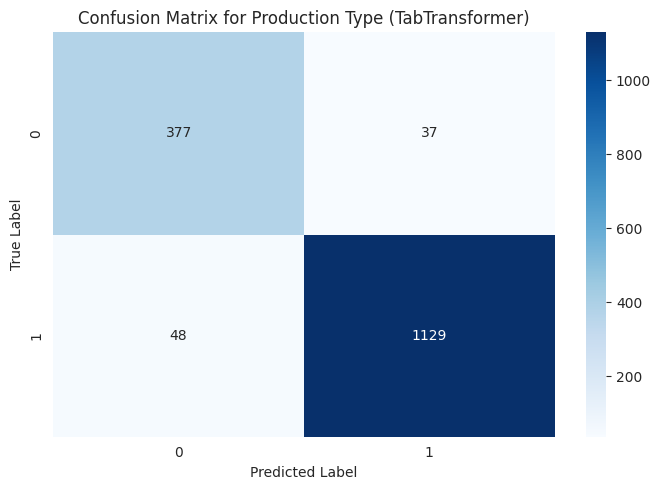

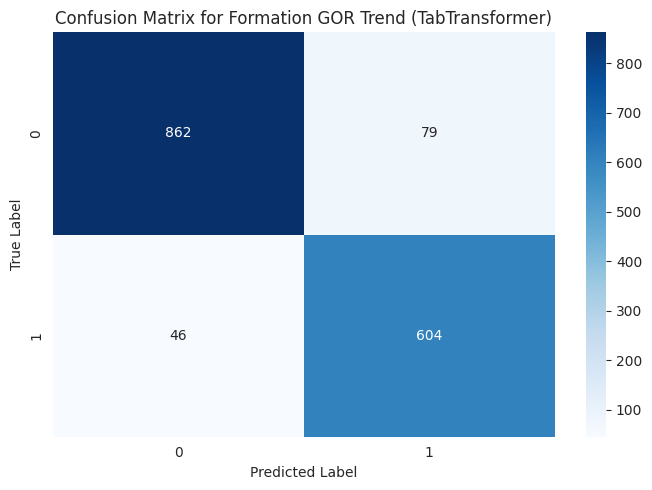

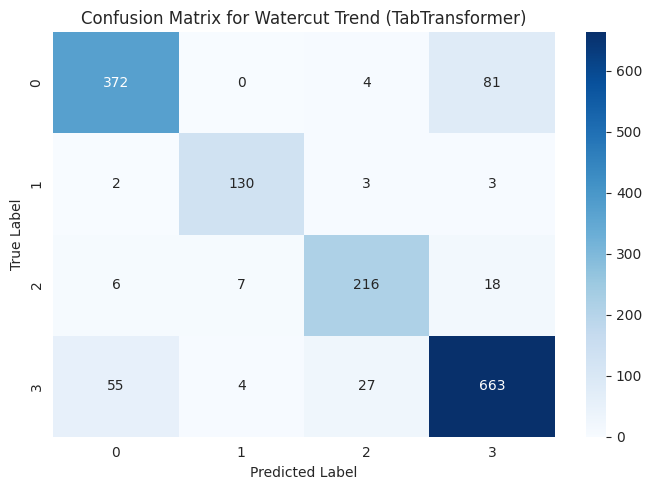

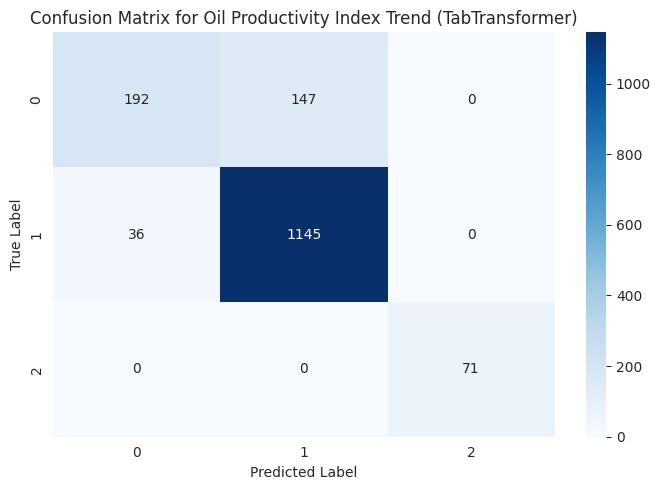

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix for a given target
def plot_confusion_matrix(y_true, y_pred, target_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Get unique class labels
    classes = np.unique(y_true)

    # Create figure
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {target_name} (TabTransformer)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for each target
for target in target_columns:
    try:
        # Get true and predicted labels
        test_df = pd.DataFrame(X_test, columns=X_test.columns)
        test_df[target] = y_test[target]
        pred_df = tabtransformer_models[target].predict(test_df)
        y_true = y_test[target].values
        y_pred = pred_df[f'{target}_prediction'].values

        # Plot the confusion matrix
        plot_confusion_matrix(y_true, y_pred, target)
    except Exception as e:
        print(f"Error plotting confusion matrix for {target}: {str(e)}")
        continue

# Average Results Across All Labels

In [ ]:
import pandas as pd

# Original results
results = {
    'Reservoir Type': {
        'RF': [1.000000, 1.000000, 1.000000, 1.000000],
        'XGB': [1.000000, 1.000000, 1.000000, 1.000000],
        'Stacking': [0.565053, 0.571515, 0.565053, 0.551404],
        'TabNet': [0.565053, 0.571515, 0.565053, 0.551404],
        'TabTransformer': [0.998743, 0.998746, 0.998743, 0.998743]
    },
    'Well Type': {
        'RF': [1.000000, 1.000000, 1.000000, 1.000000],
        'XGB': [0.999371, 0.999372, 0.999371, 0.999371],
        'Stacking': [0.360779, 0.303885, 0.360779, 0.312789],
        'TabNet': [0.360779, 0.303885, 0.360779, 0.312789],
        'TabTransformer': [0.992458, 0.992485, 0.992458, 0.992457]
    },
    'Production Type': {
        'RF': [1.000000, 1.00000, 1.000000, 1.000000],
        'XGB': [1.000000, 1.00000, 1.000000, 1.000000],
        'Stacking': [0.713388, 0.73695, 0.713388, 0.723893],
        'TabNet': [0.713388, 0.73695, 0.713388, 0.723893],
        'TabTransformer': [0.946574, 0.947136, 0.946574, 0.946799]
    },
    'Formation GOR Trend': {
        'RF': [1.000000, 1.000000, 1.000000, 1.00000],
        'XGB': [1.000000, 1.000000, 1.000000, 1.00000],
        'Stacking': [0.490886, 0.598884, 0.490886, 0.46083],
        'TabNet': [0.490886, 0.598884, 0.490886, 0.46083],
        'TabTransformer': [0.921433, 0.922781, 0.921433, 0.921704]
    },
    'Watercut Trend': {
        'RF': [1.000000, 1.000000, 1.000000, 1.000000],
        'XGB': [1.000000, 1.000000, 1.000000, 1.000000],
        'Stacking': [0.208674, 0.269604, 0.208674, 0.176245],
        'TabNet': [0.208674, 0.269604, 0.208674, 0.176245],
        'TabTransformer': [0.868008, 0.867749, 0.868008, 0.867672]
    },
    'Oil Productivity Index Trend': {
        'RF': [1.0, 1.0, 1.0, 1.0],
        'XGB': [1.0, 1.0, 1.0, 1.0],
        'Stacking': [1.0, 1.0, 1.0, 1.0],
        'TabNet': [1.0, 1.0, 1.0, 1.0],
        'TabTransformer': [0.884978, 0.8819, 0.884978, 0.876301]
    }
}

# Initialize a dictionary to store average metrics for each model
model_metrics = {
    'RF': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []},
    'XGB': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []},
    'Stacking': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []},
    'TabNet': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []},
    'TabTransformer': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
}

# Collect metrics for each model
for target in results:
    for model in results[target]:
        accuracy, precision, recall, f1 = results[target][model]
        model_metrics[model]['Accuracy'].append(accuracy)
        model_metrics[model]['Precision'].append(precision)
        model_metrics[model]['Recall'].append(recall)
        model_metrics[model]['F1 Score'].append(f1)

# Calculate averages
average_metrics = {}
for model in model_metrics:
    avg_acc = sum(model_metrics[model]['Accuracy']) / len(model_metrics[model]['Accuracy'])
    avg_prec = sum(model_metrics[model]['Precision']) / len(model_metrics[model]['Precision'])
    avg_rec = sum(model_metrics[model]['Recall']) / len(model_metrics[model]['Recall'])
    avg_f1 = sum(model_metrics[model]['F1 Score']) / len(model_metrics[model]['F1 Score'])

    average_metrics[model] = {
        'Average Accuracy': avg_acc,
        'Average Precision': avg_prec,
        'Average Recall': avg_rec,
        'Average F1 Score': avg_f1
    }

# Create DataFrame
average_df = pd.DataFrame.from_dict(average_metrics, orient='index')
average_df = average_df[['Average Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score']]

# Format for better display
average_df_styled = average_df.style.format({
    'Average Accuracy': '{:.3f}',
    'Average Precision': '{:.3f}',
    'Average Recall': '{:.3f}',
    'Average F1 Score': '{:.3f}'
}).set_caption('Average Metrics Across All Targets for Each Model')

average_df_styled